In [1]:
import pandas as pd
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import os
from scipy import stats
import seaborn as sns

# Utils

## Data Processing

In [2]:
def process(path): 
# Return transpose array of the csv file given
    if 'div' not in path and 'subs' not in path:
        return []
    else:
        print(path)
    df = pd.read_csv(path,header = None)
    Z = np.transpose(np.array(df))
    return Z

In [3]:
def shapiro_test(data):
# Test the given data whether is normal distributed or not
    try:
        shapiro_test = stats.shapiro(data)
    except:
        #print("Shapiro test fails")
        return
    if shapiro_test.pvalue<0.01:
        #print(f"Reject: p-value {shapiro_test.pvalue}")
        return False # Reject H0:data is normal distributed
    else:
        return True # Cannot reject H0: data may be normal distributed

In [136]:
def find_threshold(Z):
# Find a suitable threshold for data given to splitted into 2 normal distributed groups
    bins = [(np.max(Z)-np.min(Z))/2+np.min(Z)]
    return bins
    bins = []
    step = (np.max(Z)-np.min(Z))/1000
    for i in np.arange(np.min(Z)+step,np.max(Z),step):
        z_dig = np.digitize(Z,[i])
        D = (1-z_dig)*Z
        class1 = (z_dig*Z).flatten()
        class2 = ((1-z_dig)*Z).flatten()
        class1 = class1[class1 != 0]
        class2 = class2[class2 != 0]
        if shapiro_test(class1) and shapiro_test(class2):
            bins.append(i)
    return bins

In [5]:
# Transform value map into dataframe with column: [value, X-coordinate, Y-coordinate]
def transform(Z):
    values = Z.flatten()
    
    x_coor = []
    y_coor = []
    # x-coordinates
    for i in range(len(Z)):
        x_coor.append(np.arange(len(Z[0])))
    for i in range(len(Z)):
        y_coor.append(i*np.ones(len(Z[0])))
    df = {'value':values,'x':np.array(x_coor).flatten(),'y':np.array(y_coor).flatten().astype(int)}
    df = pd.DataFrame(df)
    return df

## Plot Function

In [36]:
def plot_colormap(data,title = "AUT and QUARTZ",path = ""):
    """
    Helper function to plot data with associated colormap.
    """
   # fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=True, squeeze=False)
    figure, axes = plt.subplots(figsize=(data.shape[1]/5,data.shape[0]/5))
    psm = axes.pcolormesh(data, cmap='rainbow',rasterized=True)
    figure.colorbar(psm, ax=axes)
    axes.invert_yaxis()
    if abs(data.shape[1]-data.shape[0])<=1:
        print(data.shape[1],data.shape[0])
        axes.set_aspect('equal', adjustable='box')
    plt.title(title)
    #plt.savefig(path+" "+title)
    plt.show()

In [134]:
def plot_2stat(Z,z_dig):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(Z.shape[1]/2,Z.shape[0]/5))
    psm = ax1.pcolormesh(z_dig, cmap='cool',rasterized=True)
    fig.colorbar(psm, ax=ax1)
    ax1.set_title("After process")
    
    
    class1 = (z_dig*Z).flatten()
    class2 = ((1-z_dig)*Z).flatten()
    class1 = class1[class1 != 0]
    class2 = class2[class2 != 0]
    mean1 = np.mean(class1)
    std1 = np.std(class1)
    mean2 = np.mean(class2)
    std2 = np.std(class2)
    print(len(class1))
    ax2.hist((class1,class2),bins=100,label = ("{:.3f} +- {:.3f}".format(mean1,std1),"{:.3f} +- {:.3f}".format(mean2,std2)),color = ('aqua','magenta'))
    ax2.legend(prop={'size': 30})

    plt.show()

In [166]:
def plot_labels(Z,label,dim1 = 49,dim2 = 50):
    # Reshape into dim1*dim2
    label = label.reshape(dim1,dim2)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 7))
    sns.heatmap(Z,ax=ax1)
    sns.heatmap(label,ax = ax2)
    plt.show()
    #p = sns.scatterplot(data=Zt['value'], x=Zt['x'], y=Zt['y'], hue=clf.predict(Zt), legend="full", palette="deep")
    #sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
    #plt.show()

In [127]:
def plot_3d(Z,ele_deg=60,azi_deg=35):
    X = np.linspace(0, Z.shape[1]-1, Z.shape[1])
    Y = np.linspace(0, Z.shape[0]-1, Z.shape[0])
    
    fig = plt.figure(figsize = (10,20))
    for i in range(2):
        ax = fig.add_subplot(1,2,i+1,projection='3d')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.view_init(ele_deg, azi_deg)
        ax.invert_xaxis()
        if i==0:
            ax.contour3D(X, Y, Z,50, cmap='rainbow')
        if i==1:
            Zt = transform(Z)
            ax.scatter(Zt['x'], Zt['y'],Zt['value'], c=Z, cmap='rainbow')
    plt.show()

In [99]:
def plot_3d_scatter(Z,ele_deg = 60,azi_deg = 35):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    X = np.linspace(0, 48, 49)
    Y = np.linspace(0, 59, 50)
    ax.scatter(X,Y, Z, cmap='rainbow',linewidth = 0.5)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(ele_deg, azi_deg);
    plt.show()

# Main

In [9]:
# Find all the files
data_dir = "../data/221115_review/"
lst=os.listdir(data_dir)
files = []
for l in lst:
    if l[0] != '.':
        f_lst = os.listdir(data_dir+l)
        for f in f_lst:
            if '.png' not in f:
                files.append(data_dir+l+'/'+f)

../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_div-pqty=25.csv with threshold 0.9865907457239519
1084


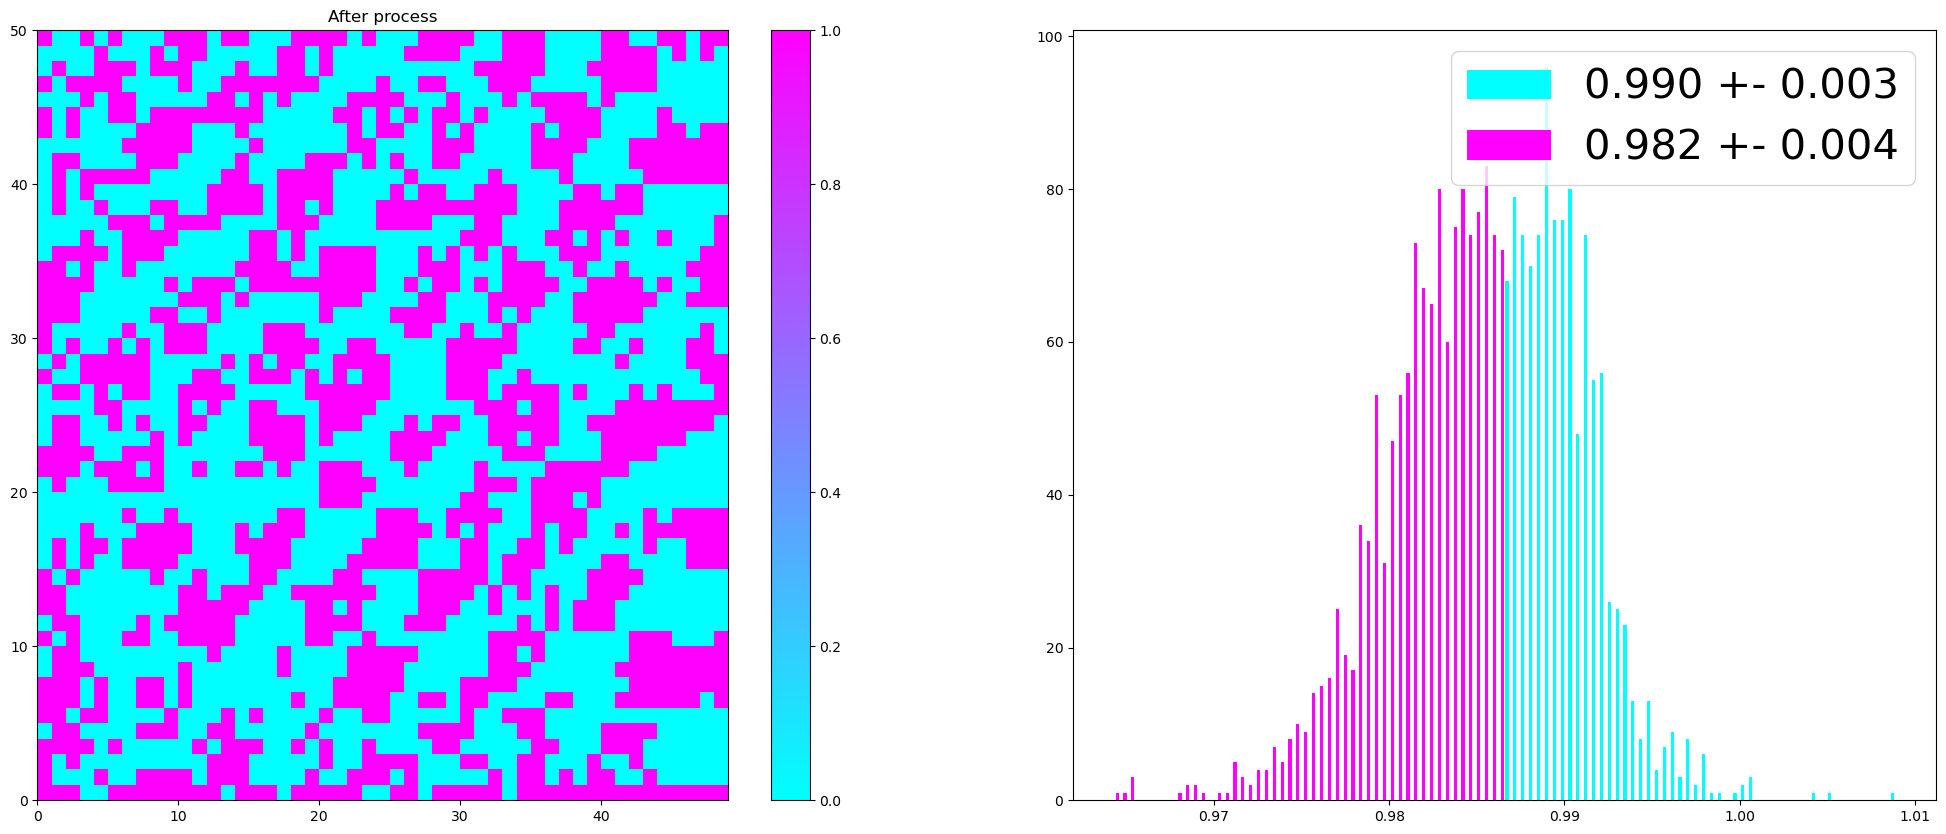

../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_subs-pqty=25.csv with threshold 0.033294677734375
1341


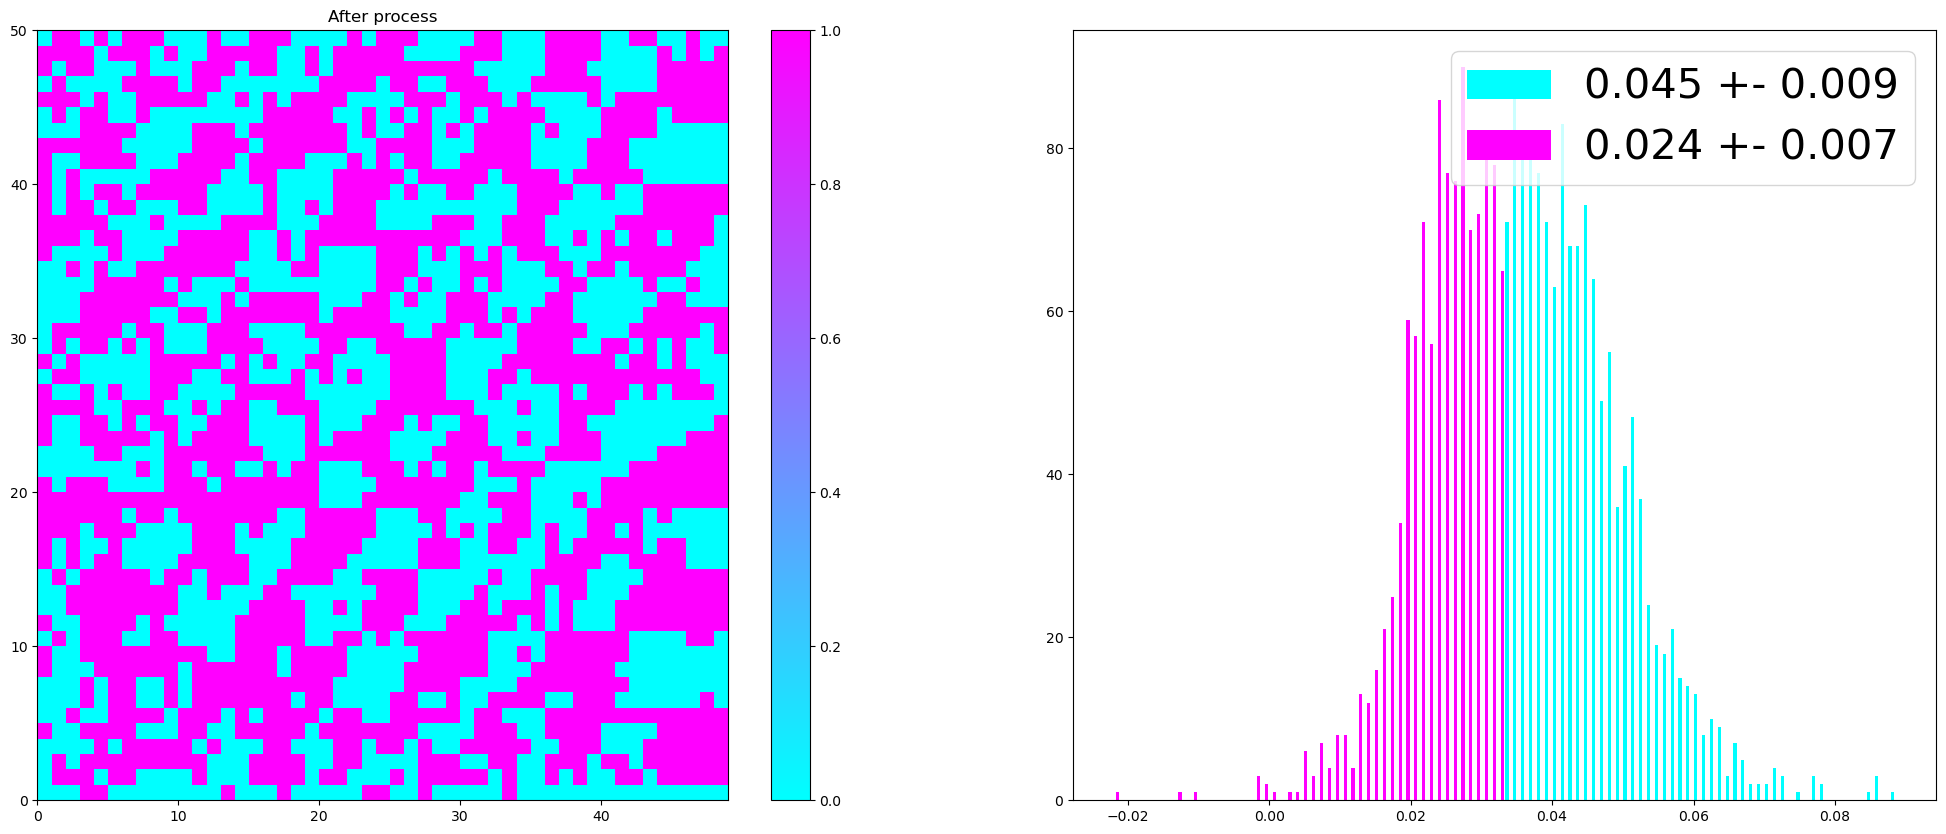

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv with threshold 3.132834159029243
35


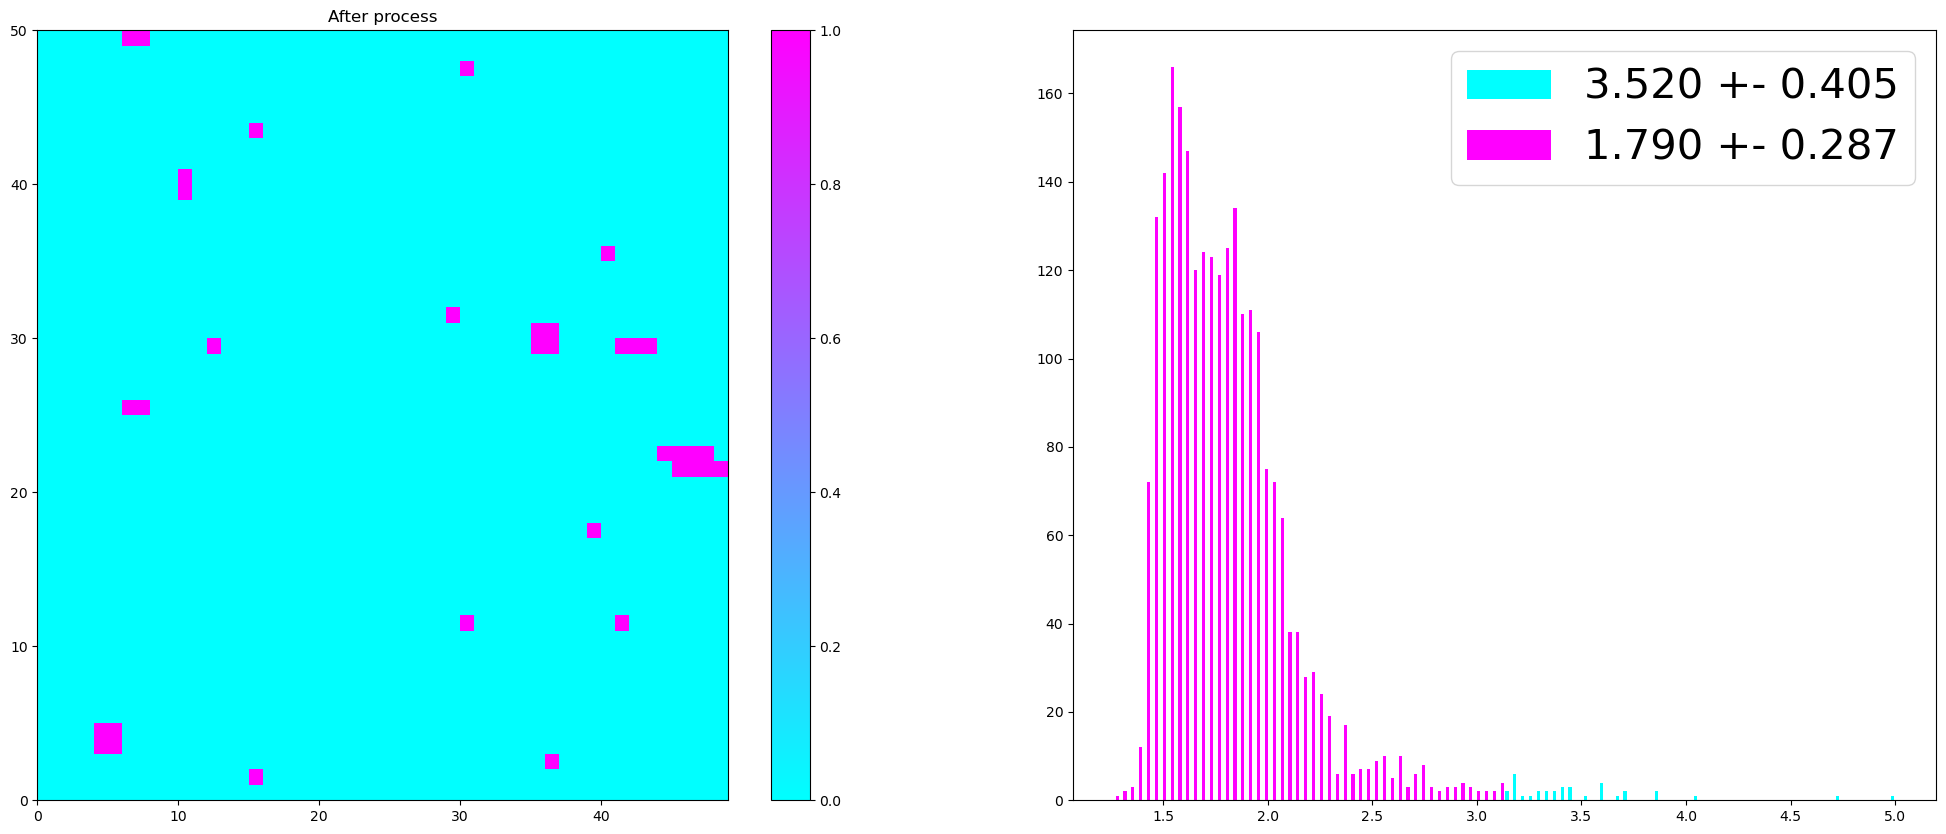

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_subs-pqty=25.csv with threshold -2180.60302734375
2416


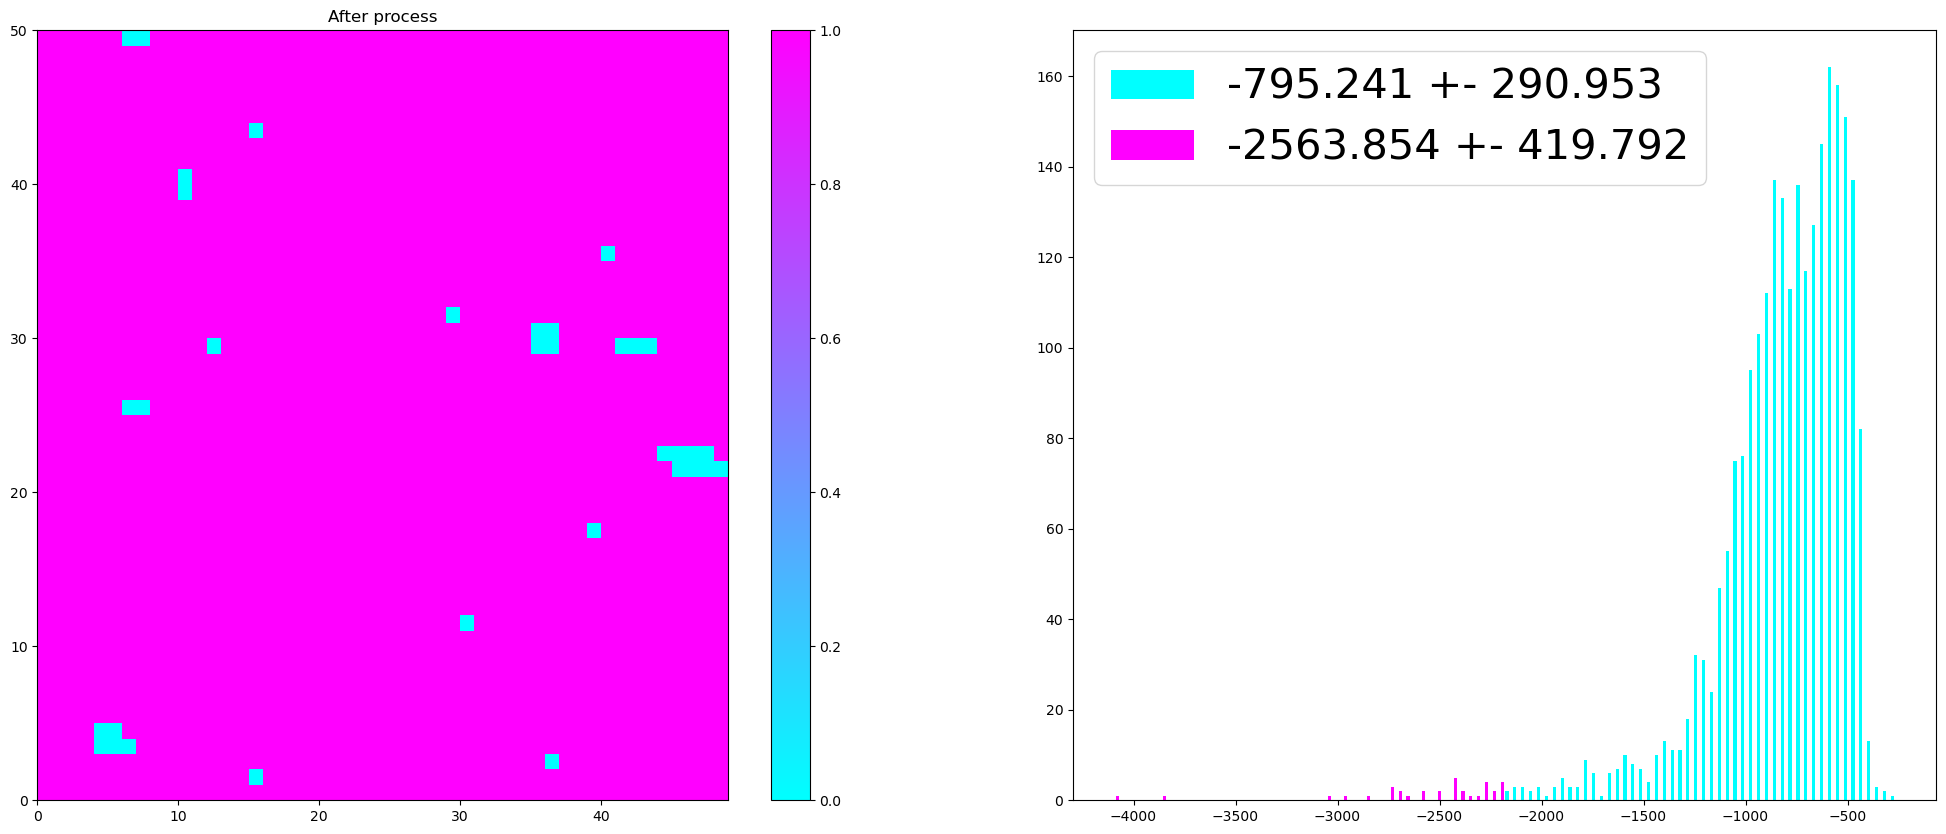

../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_div-pqty=25.csv with threshold 0.9720390215373493
1864


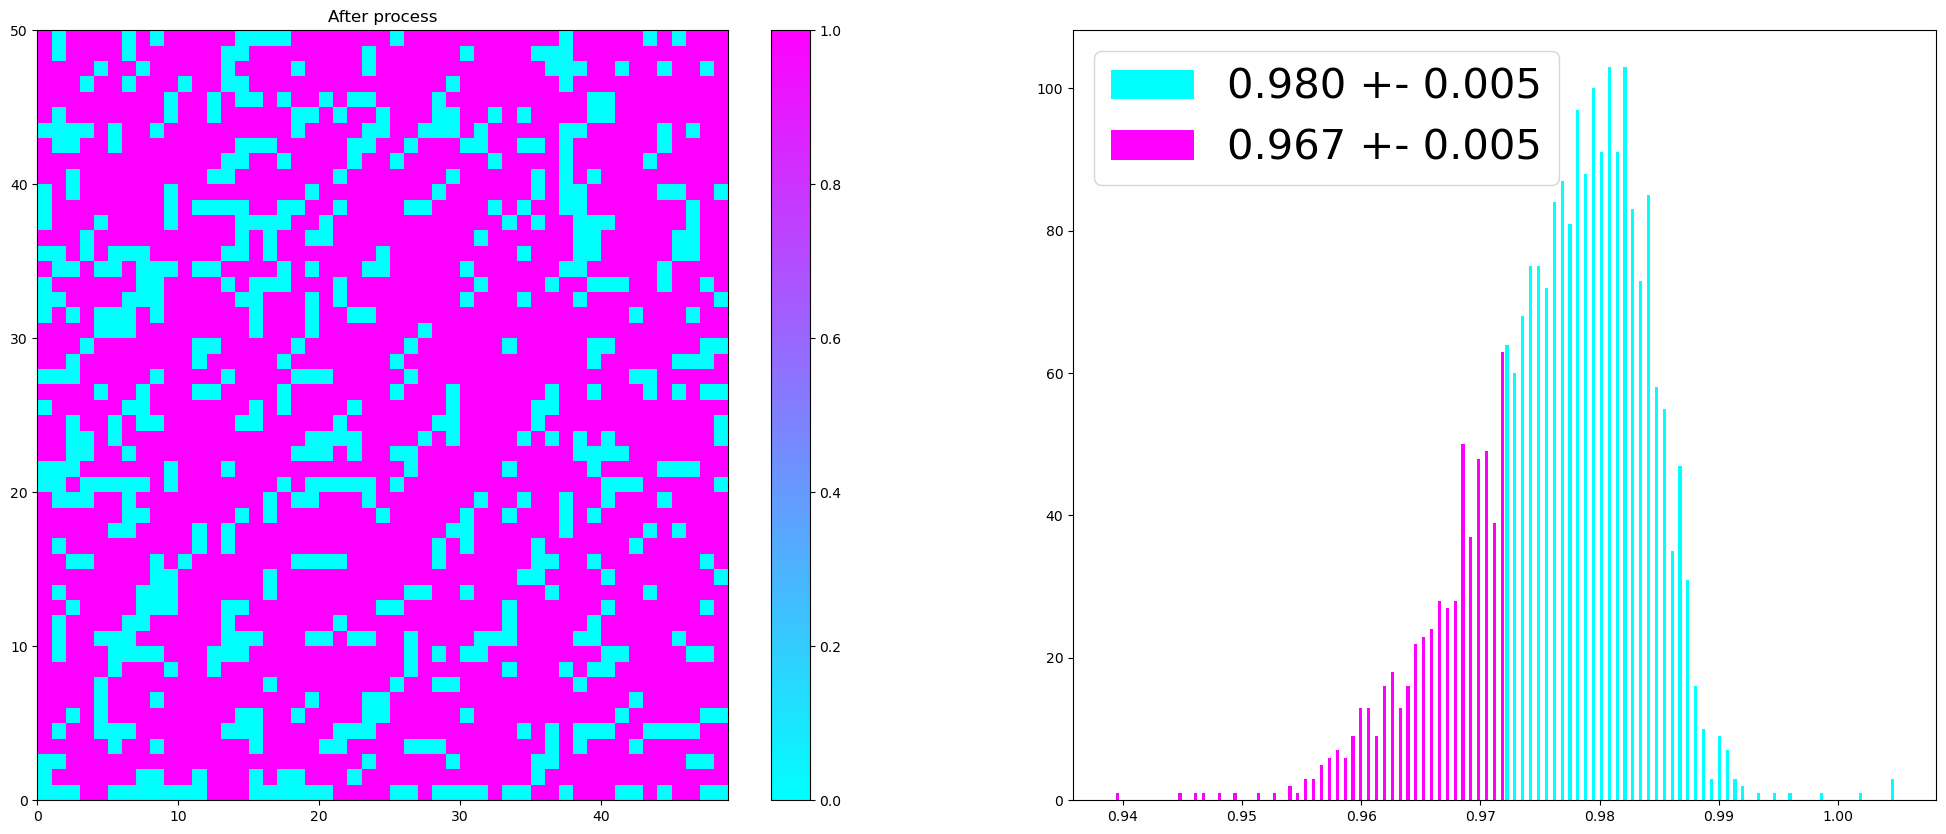

../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_subs-pqty=25.csv with threshold -0.0623779296875
1890


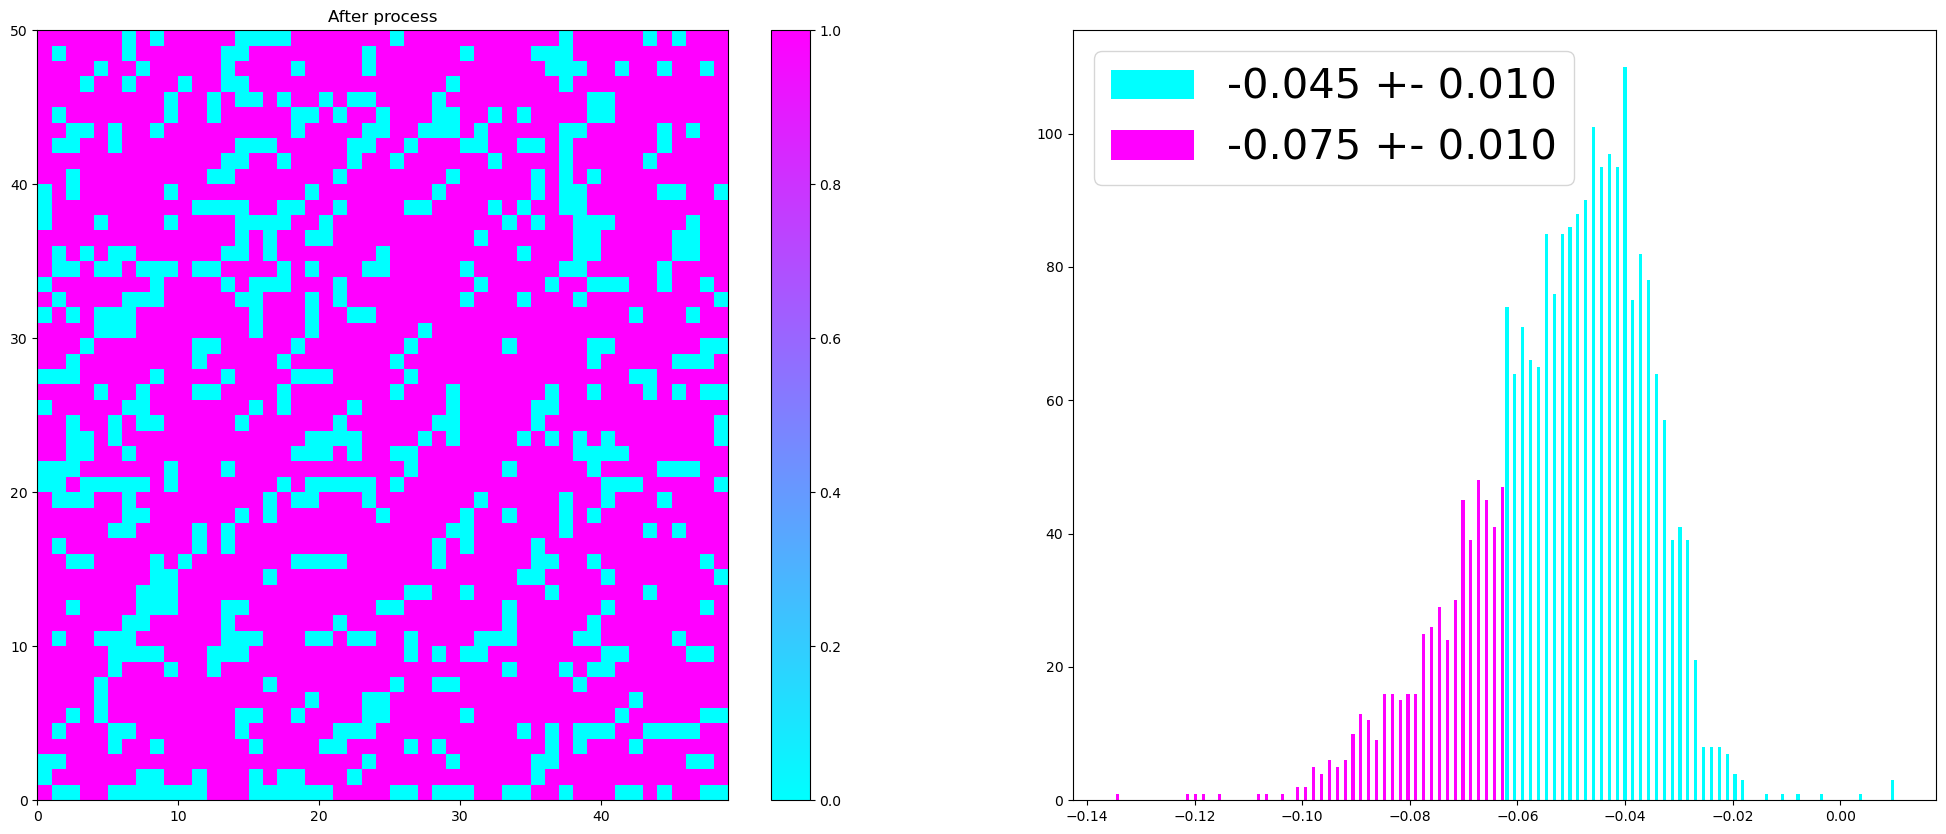

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_div-pqty=25.csv with threshold 3.354614377278659
92


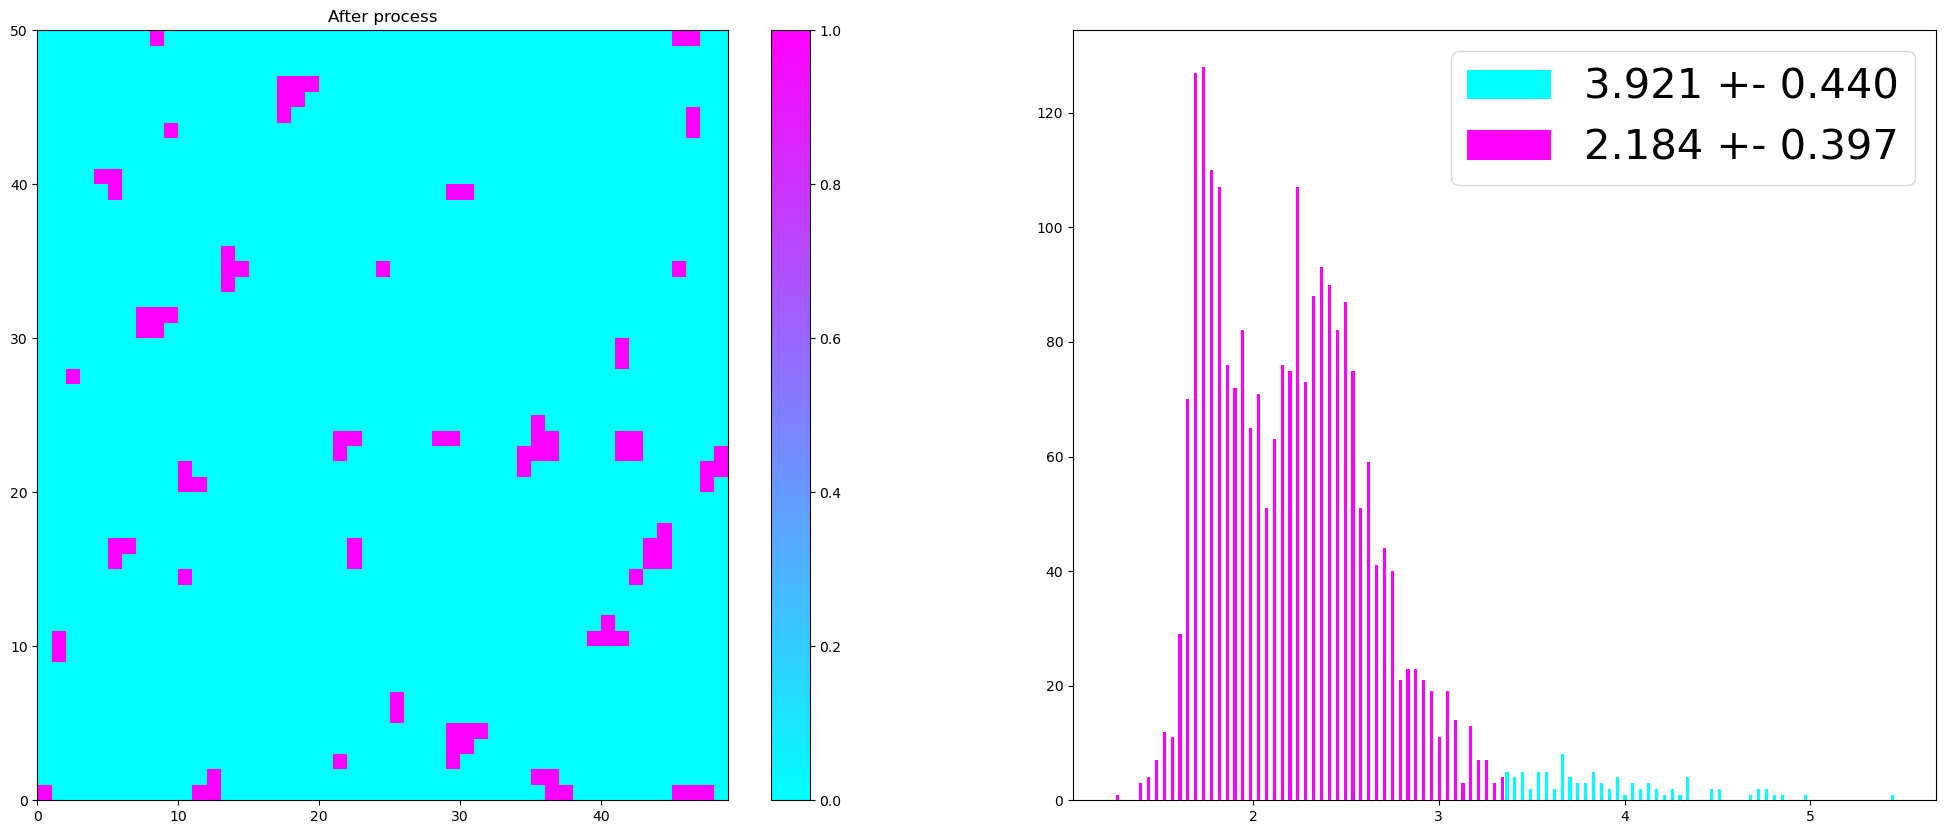

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_subs-pqty=25.csv with threshold 1415.283203125
94


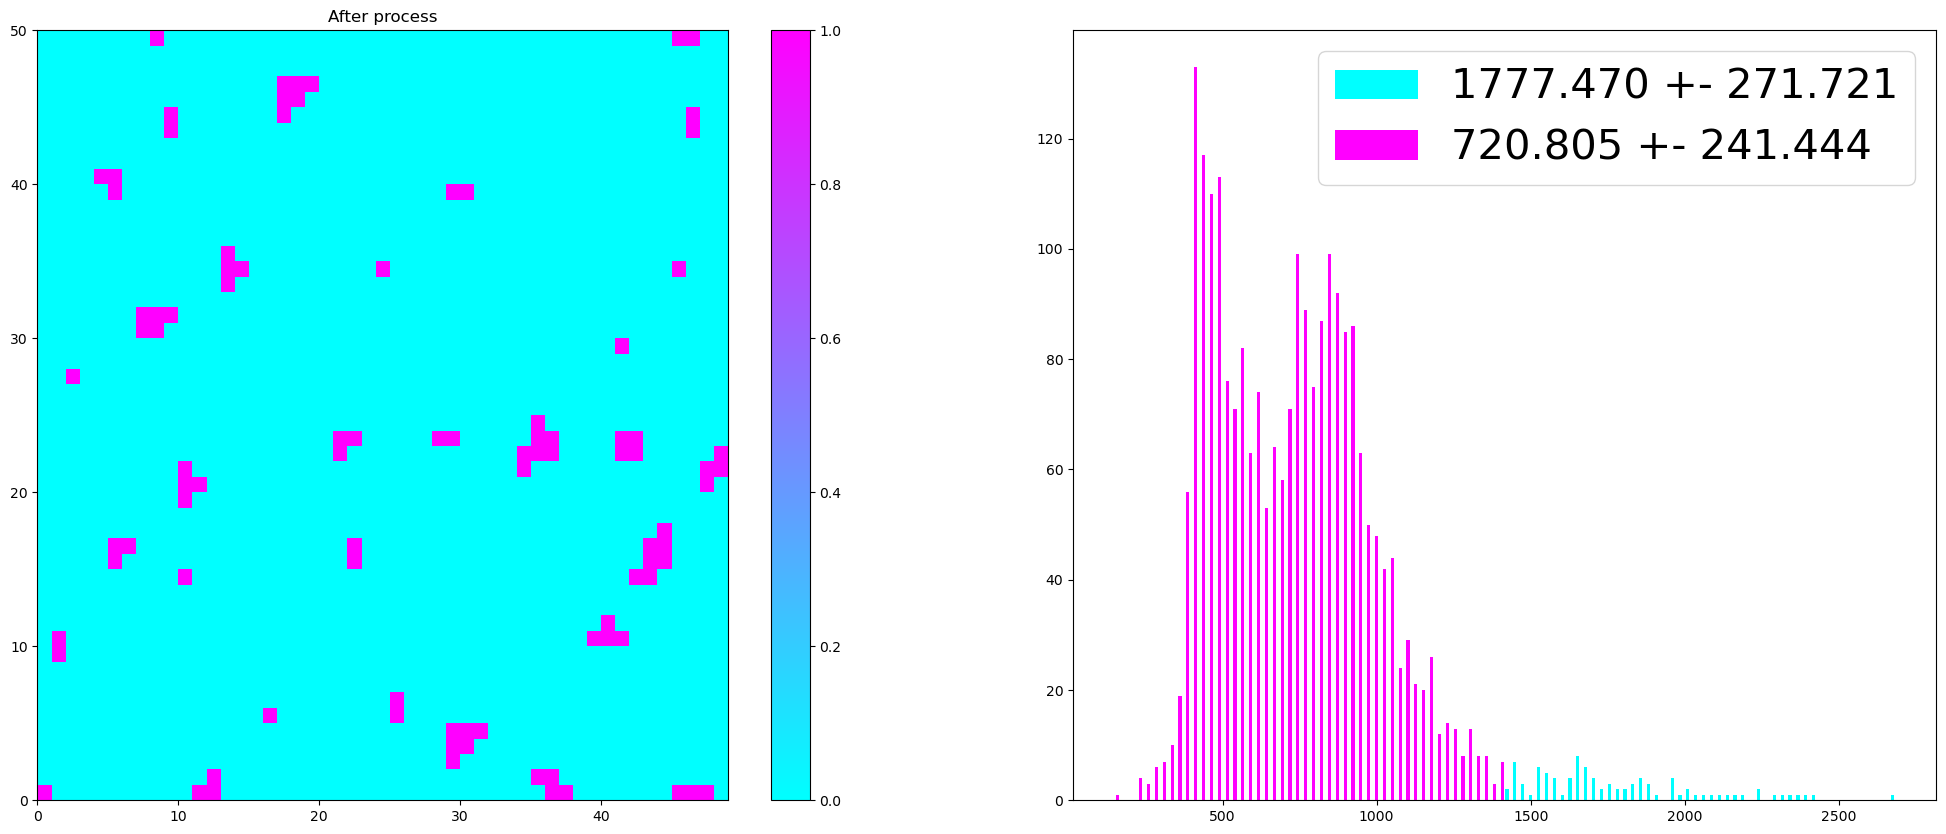

../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_div-pqty=25.csv with threshold 0.8332237003313776
2431


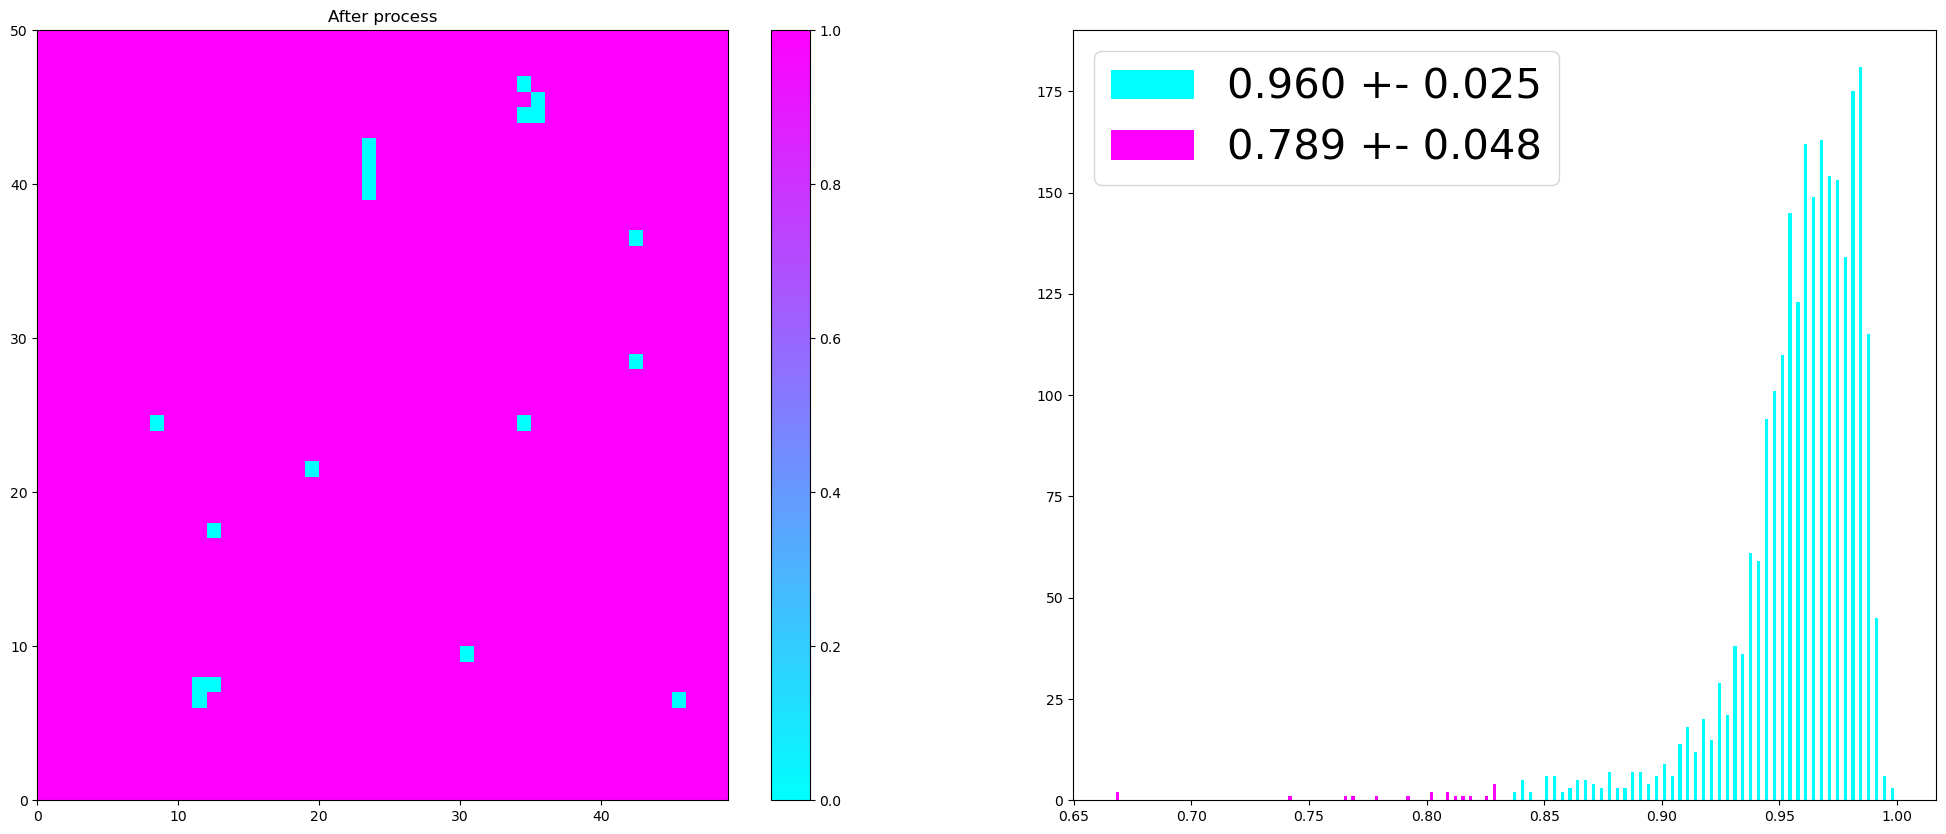

../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_subs-pqty=25.csv with threshold 0.404052734375
19


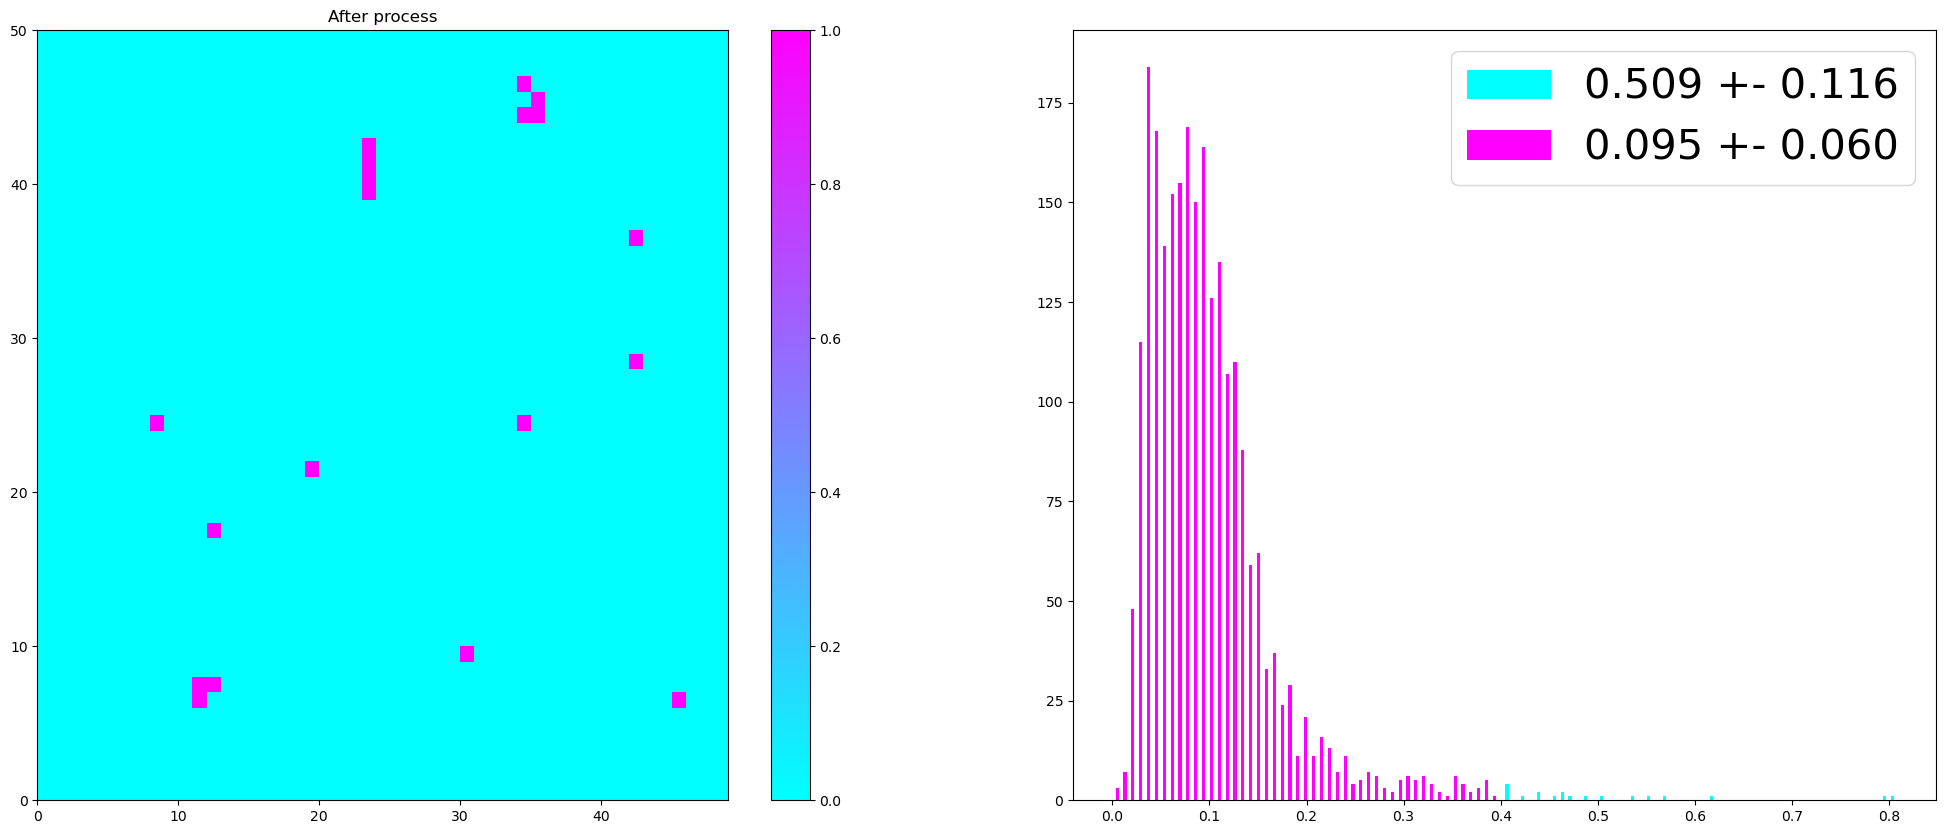

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_div-pqty=25.csv with threshold 5.253310321602891
8


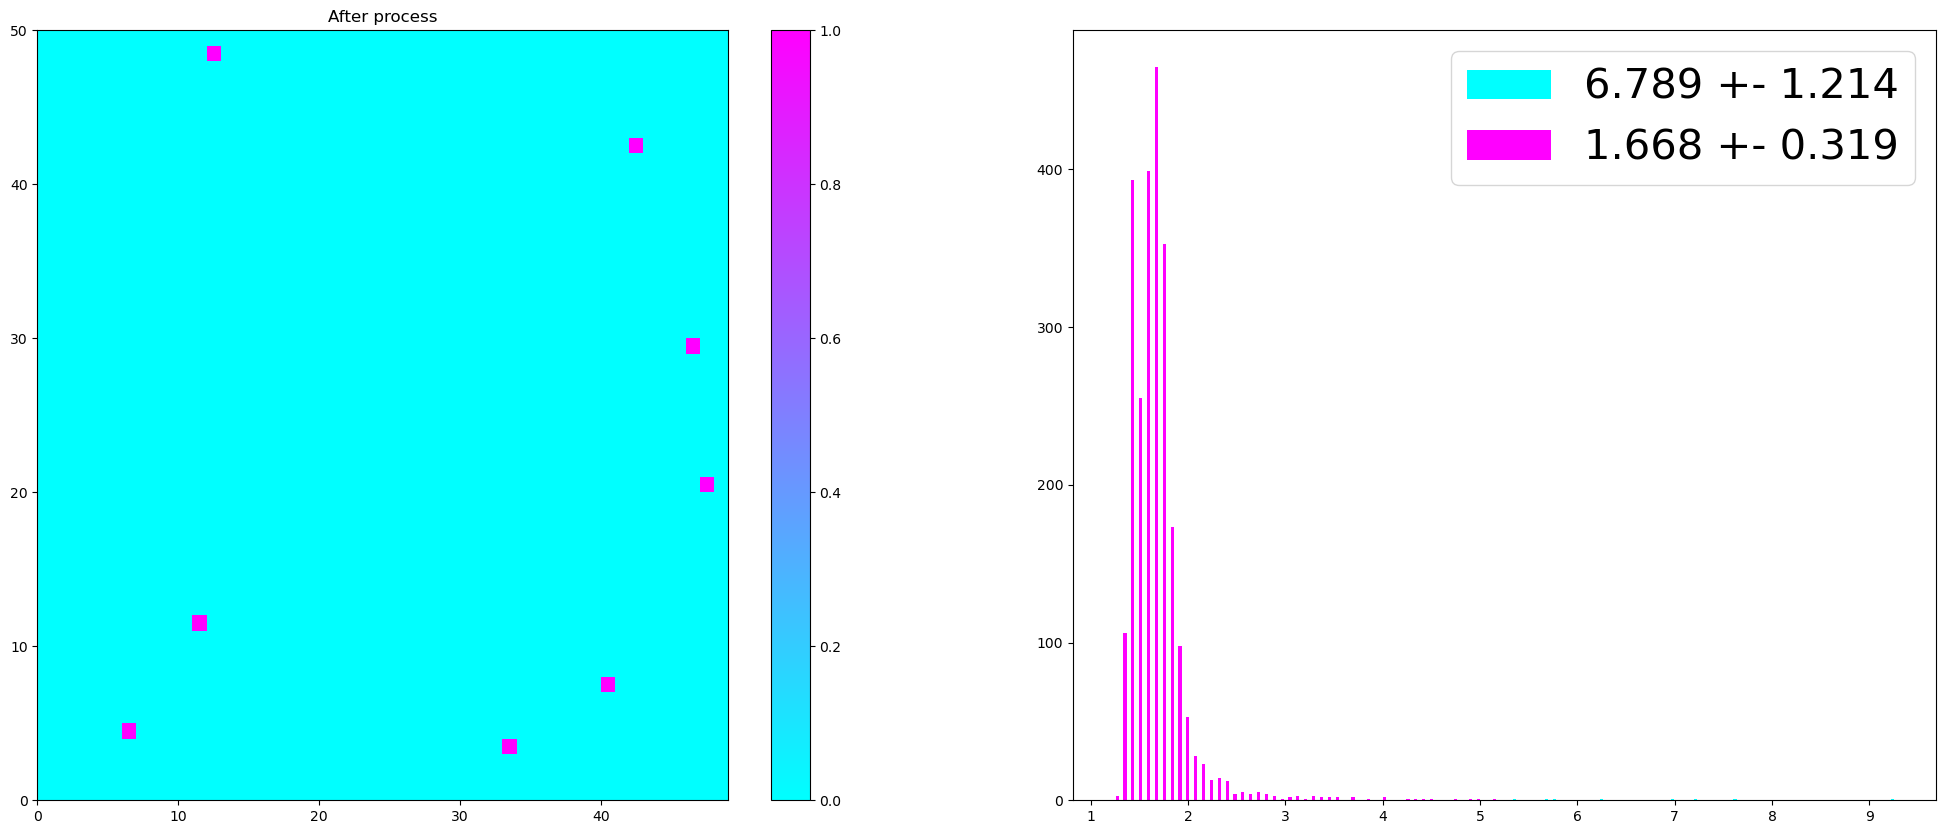

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_subs-pqty=25.csv with threshold -5146.45361328125
2442


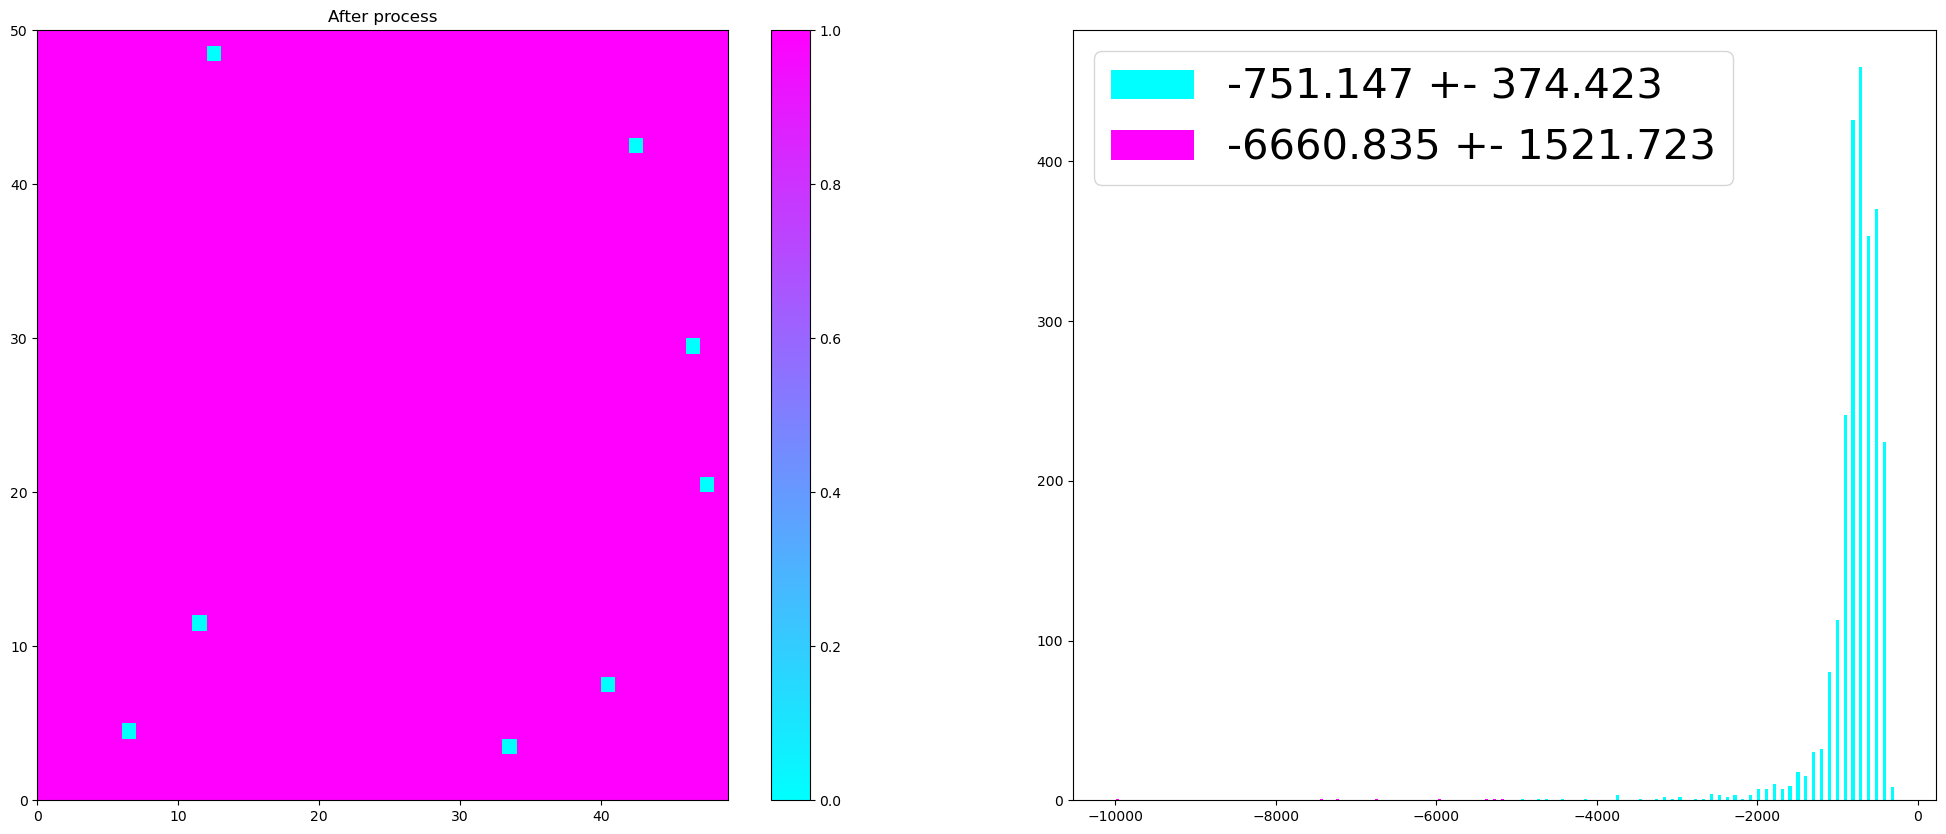

../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_div-pqty=25.csv with threshold 0.7955750918649261
2424


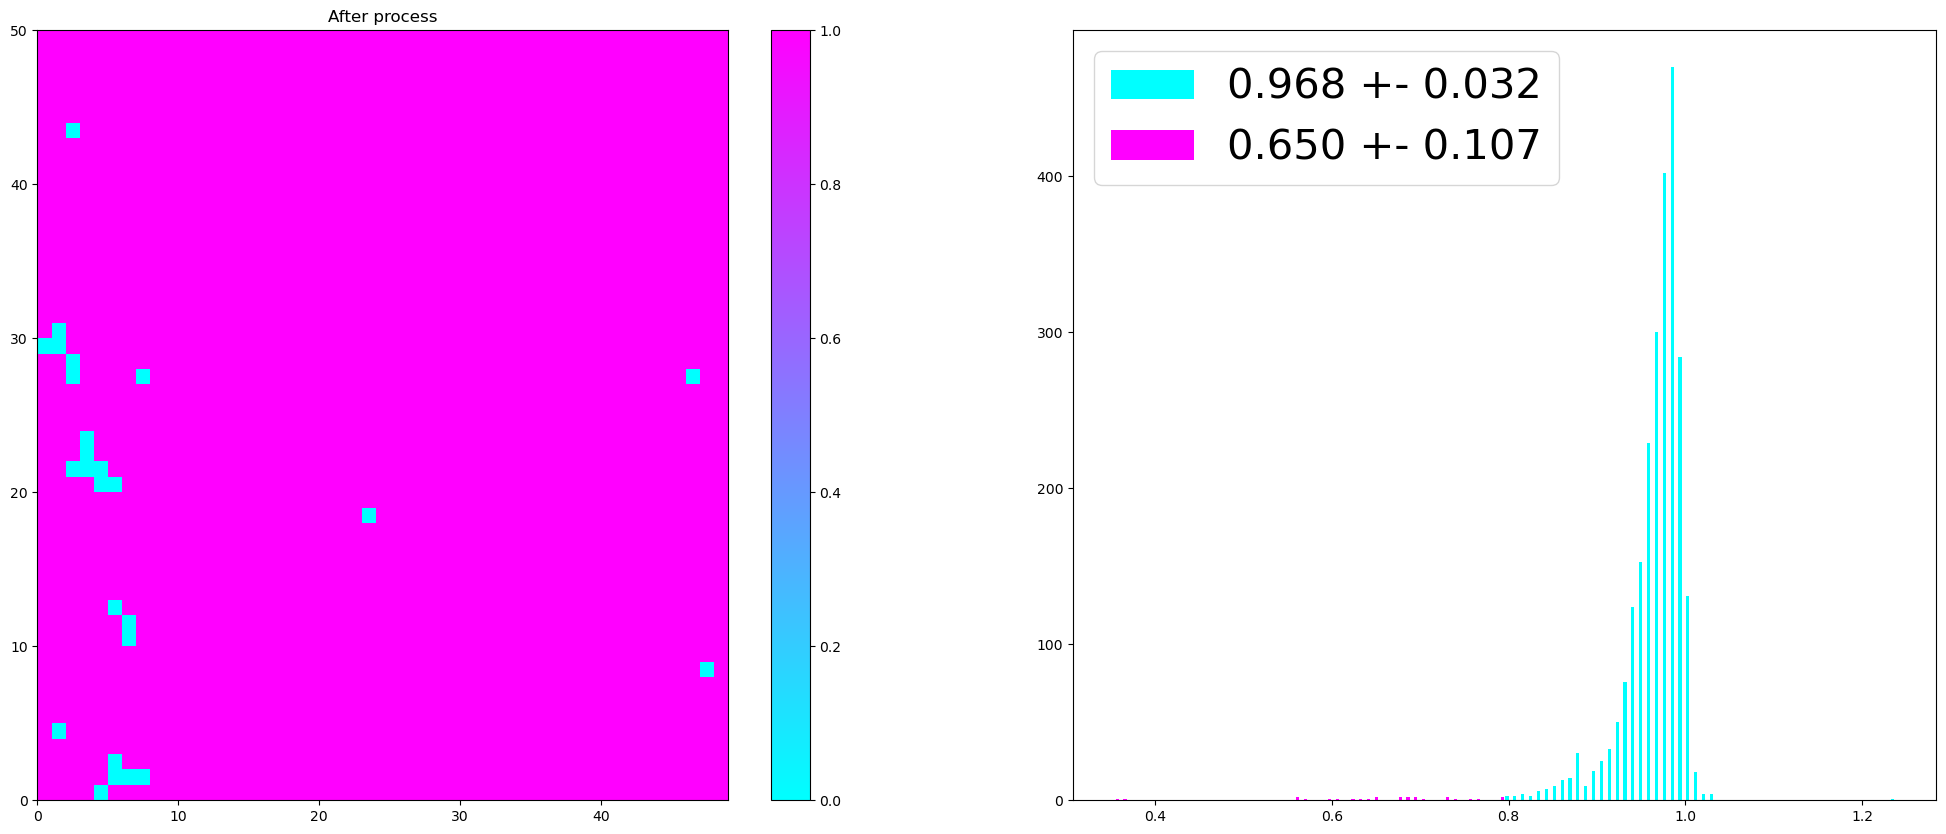

../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_subs-pqty=25.csv with threshold -0.401031494140625
2428


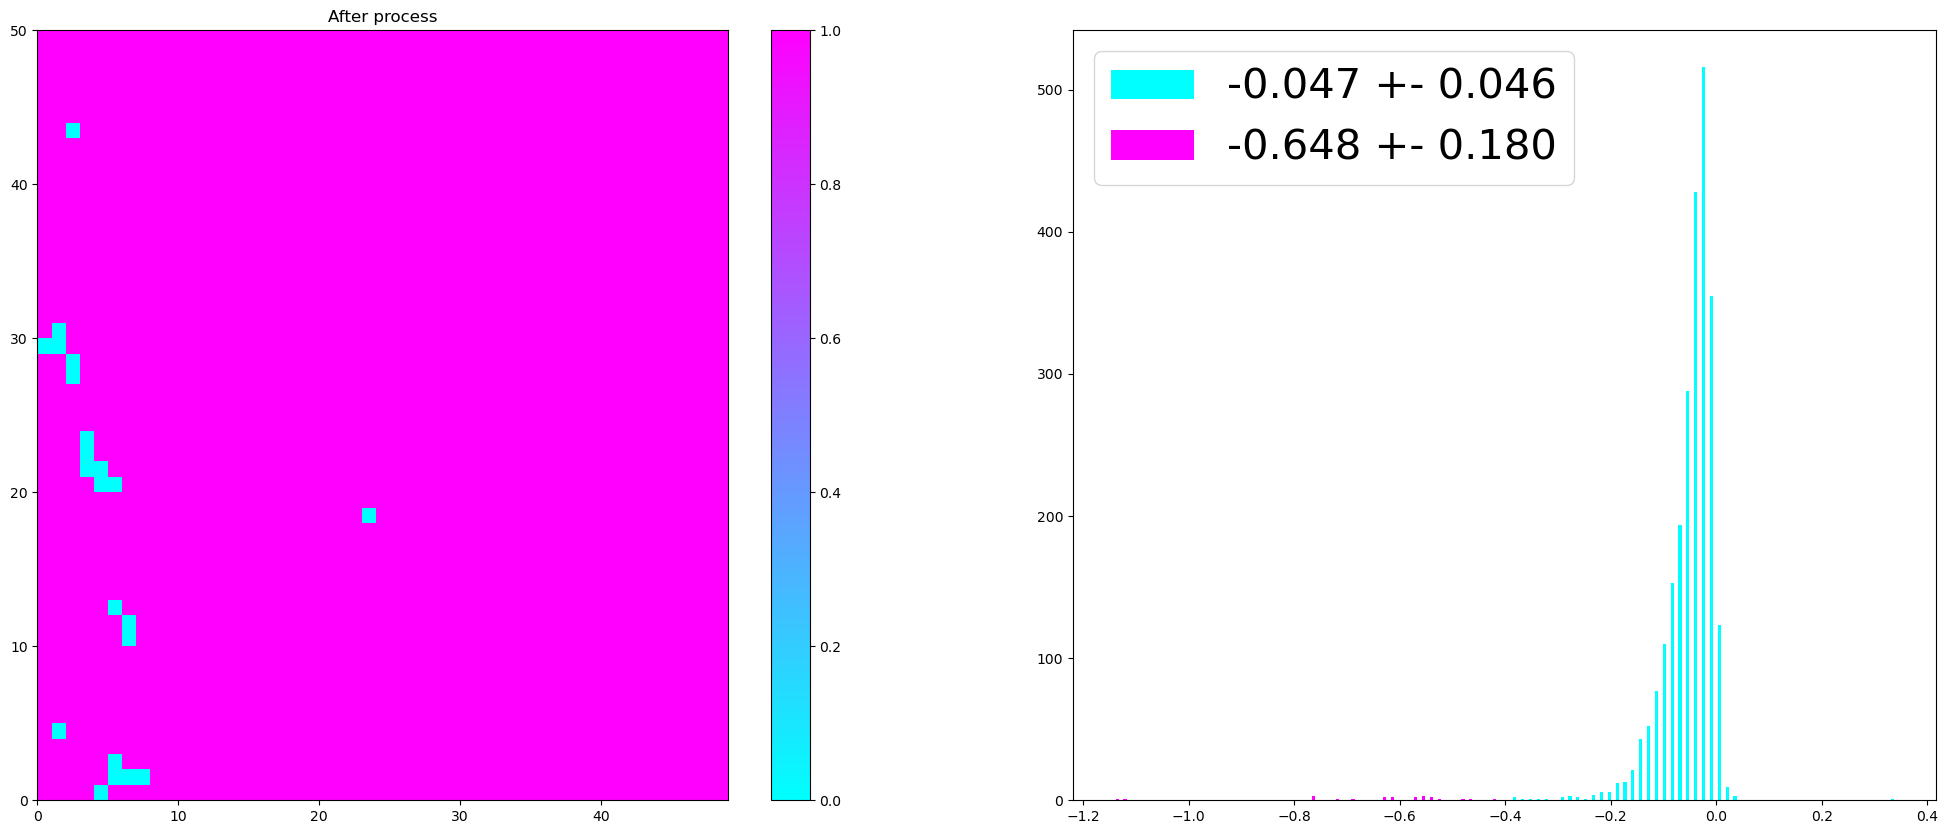

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_div-pqty=25.csv with threshold 7.335263050253886
16


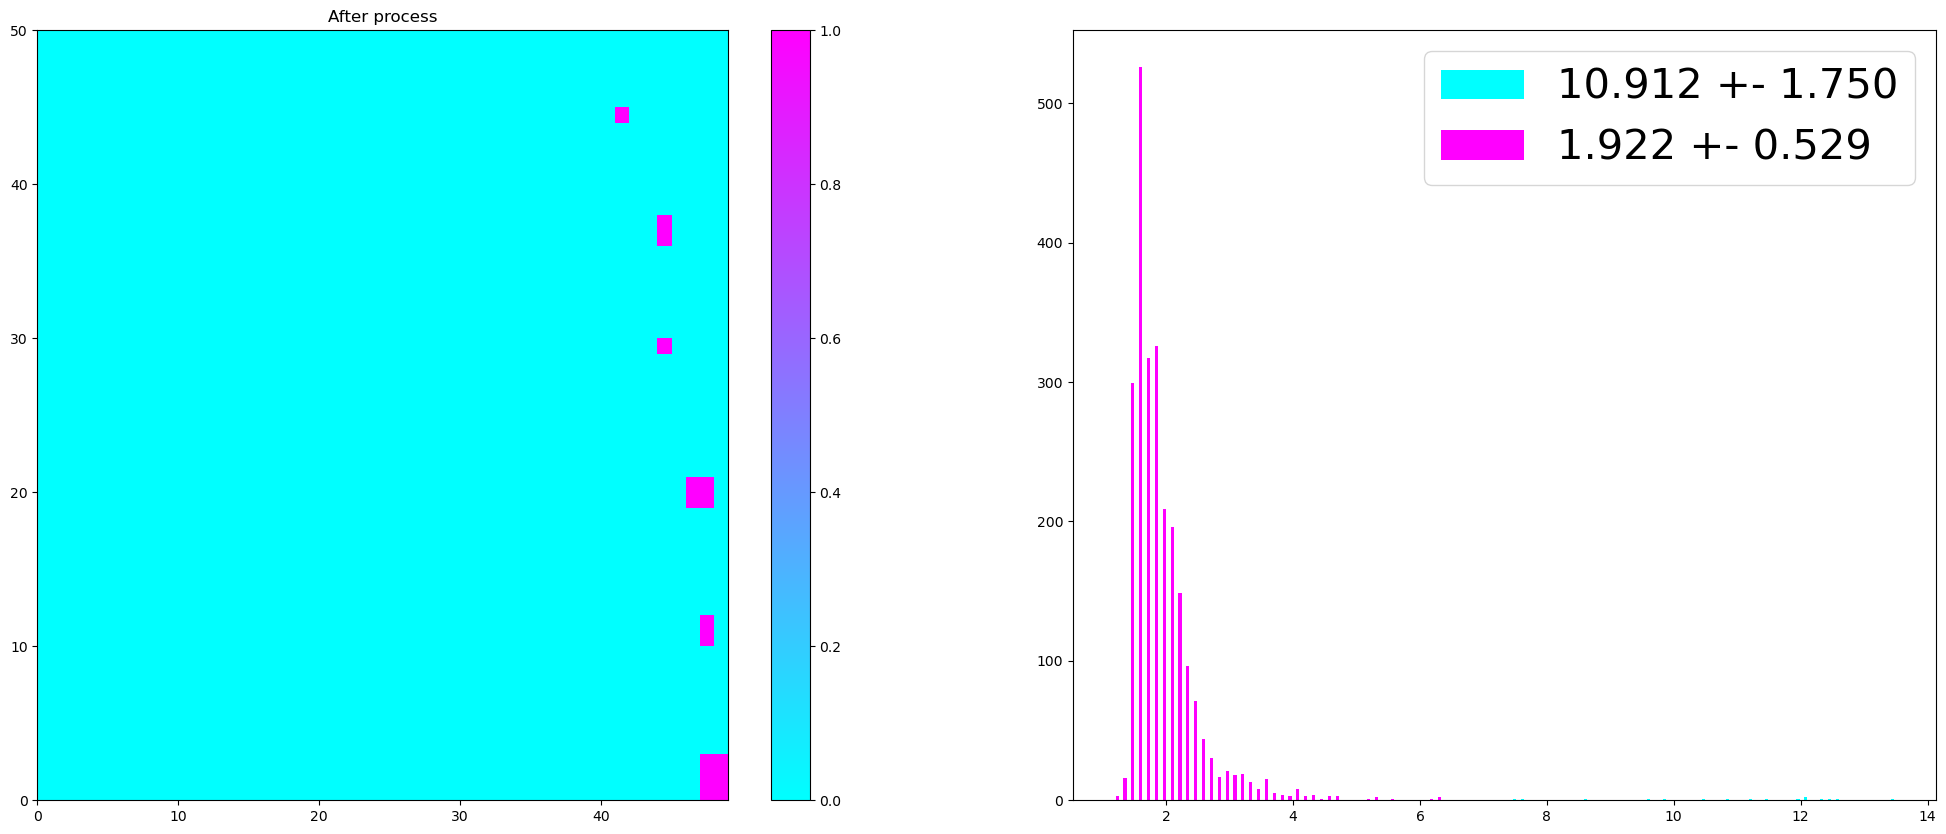

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_subs-pqty=25.csv with threshold 2976.898193359375
15


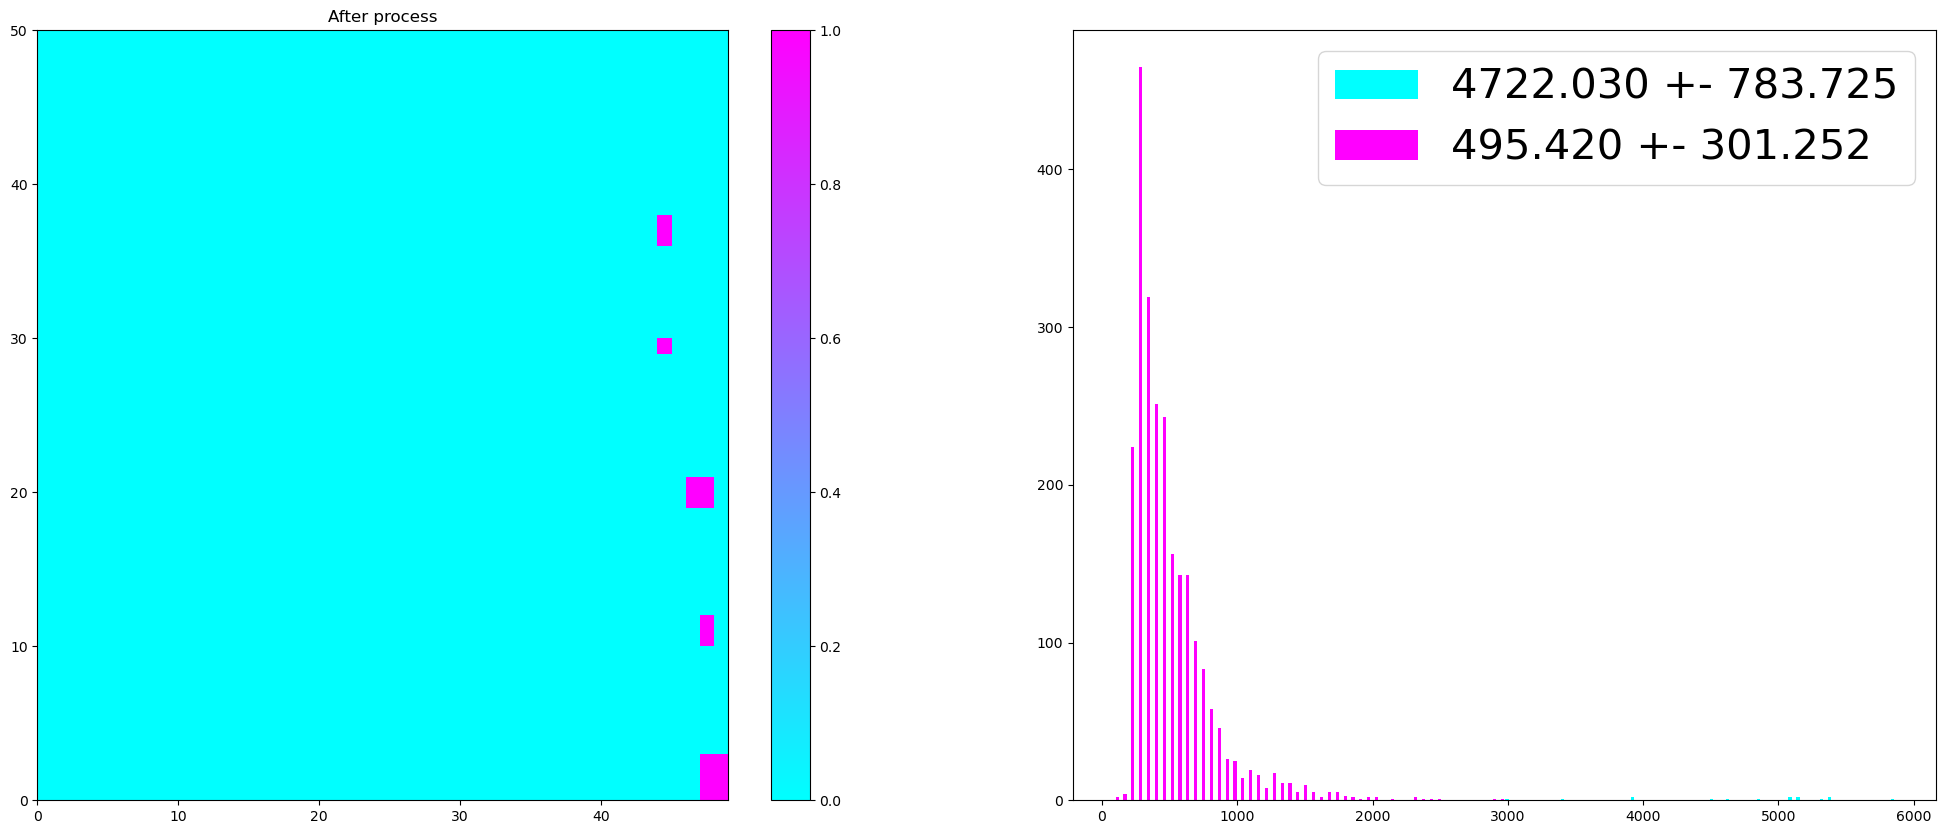

../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_div-pqty=25.csv with threshold 0.9847238213677829
1661


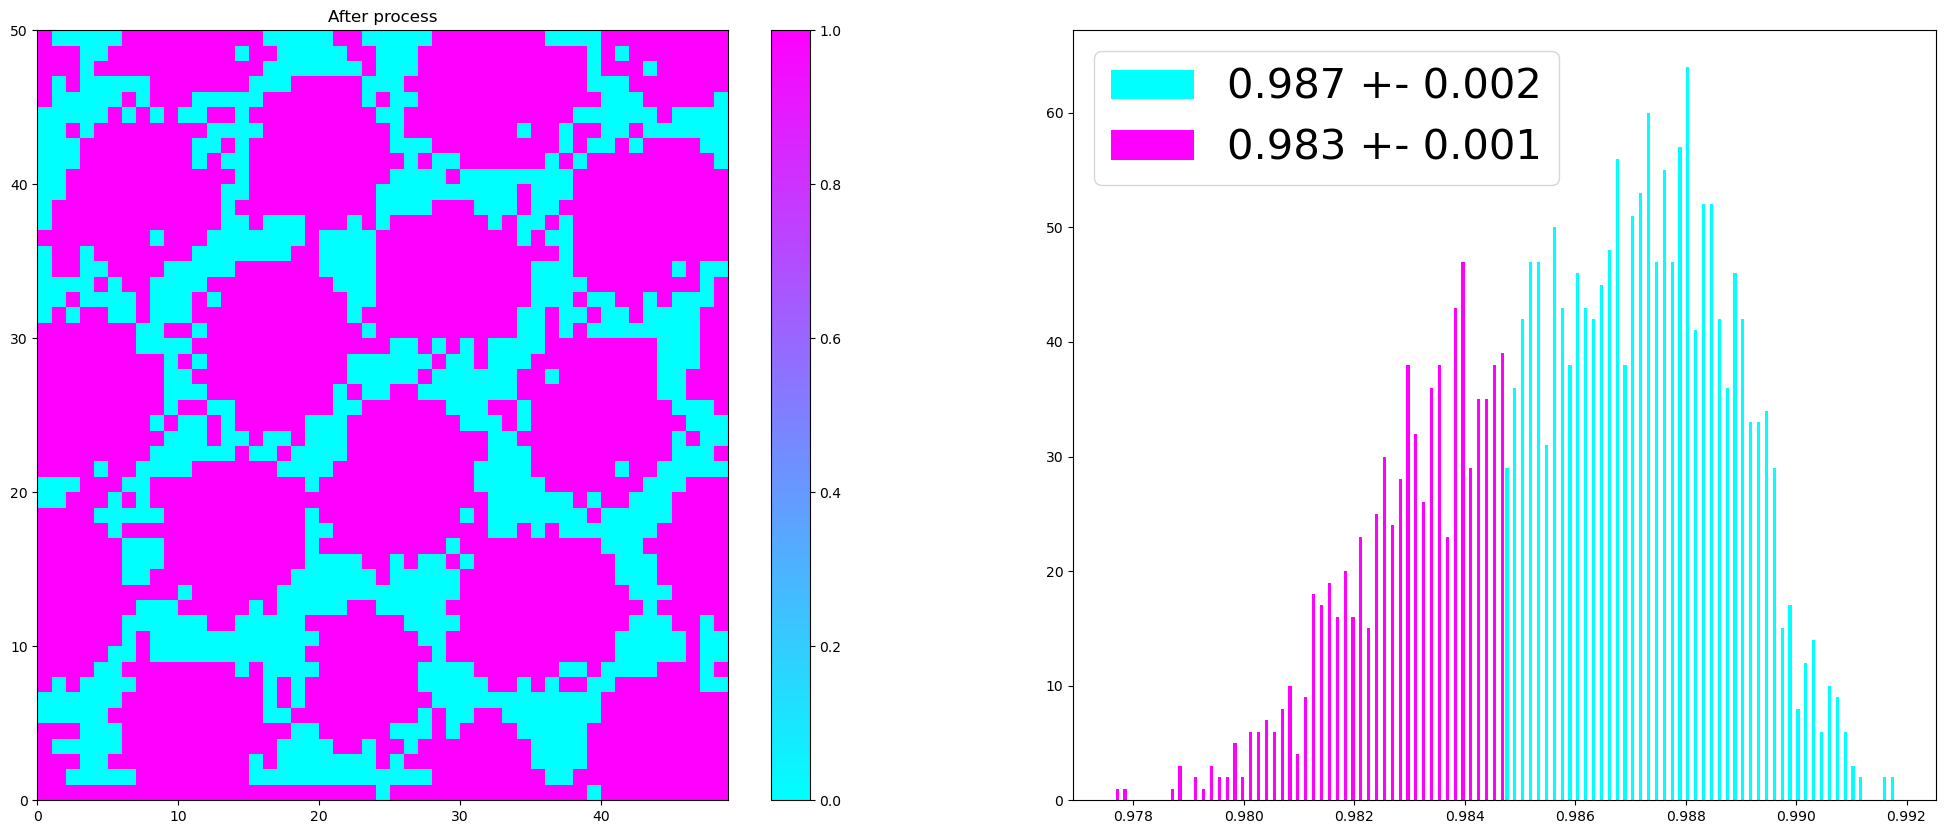

../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_subs-pqty=25.csv with threshold 0.082122802734375
789


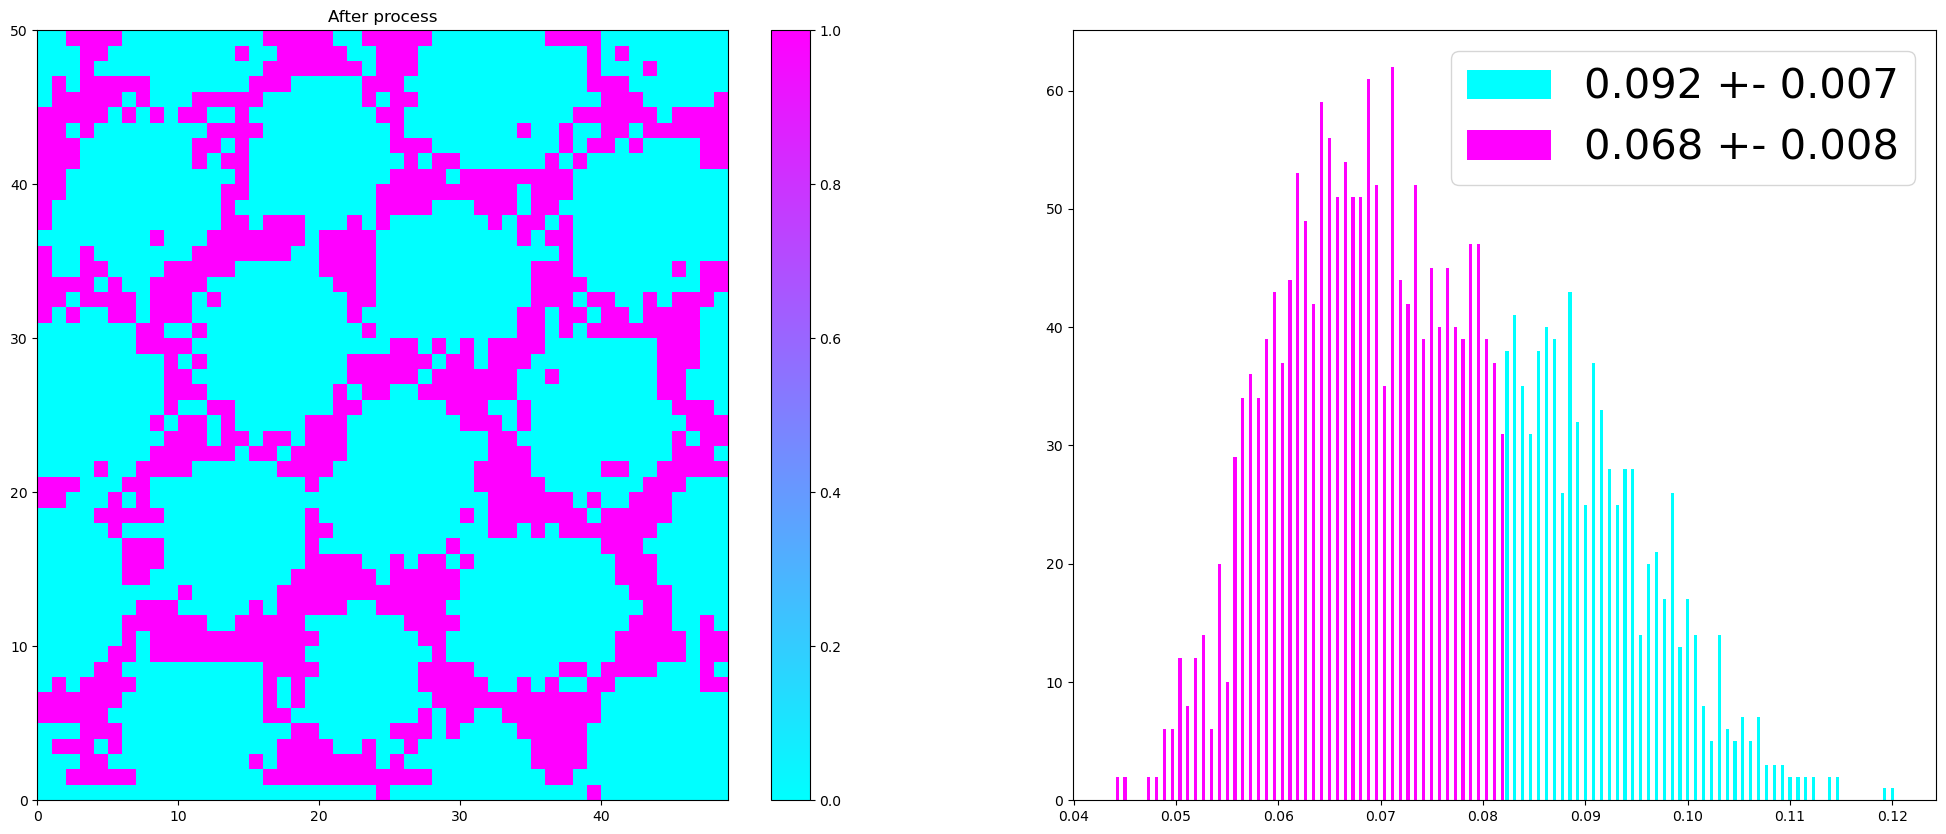

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_div-pqty=25.csv with threshold 1.7213560443818239
248


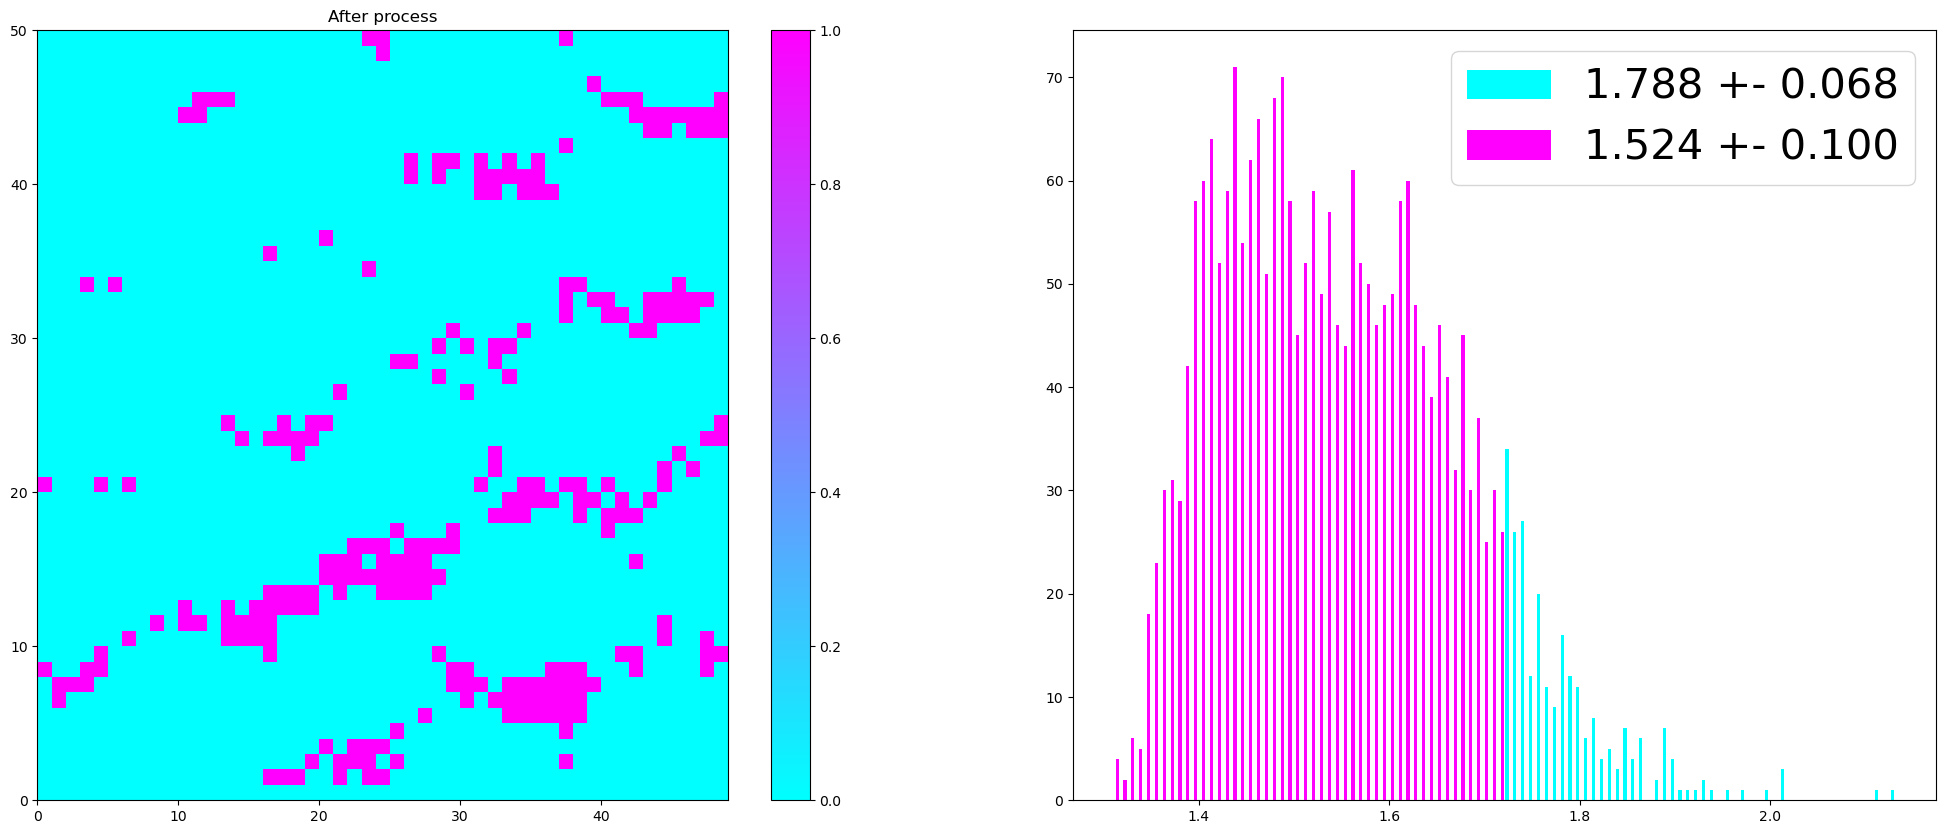

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_subs-pqty=25.csv with threshold -540.46630859375
2304


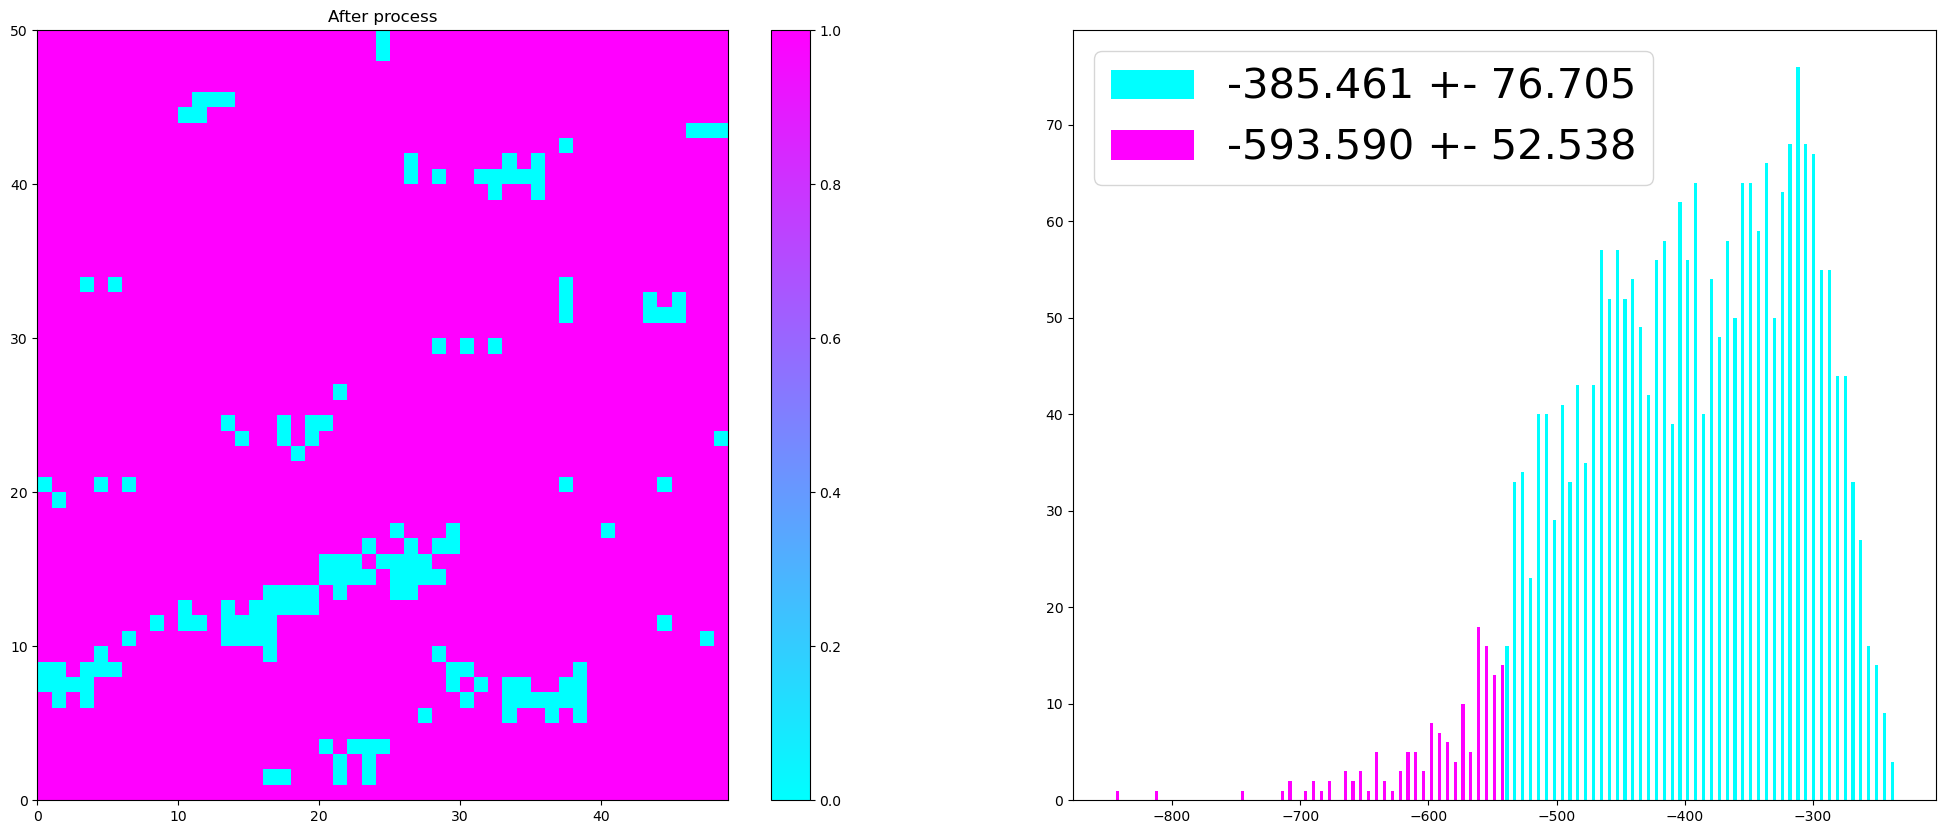

../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_div-pqty=25.csv with threshold 0.9669890115986011
1797


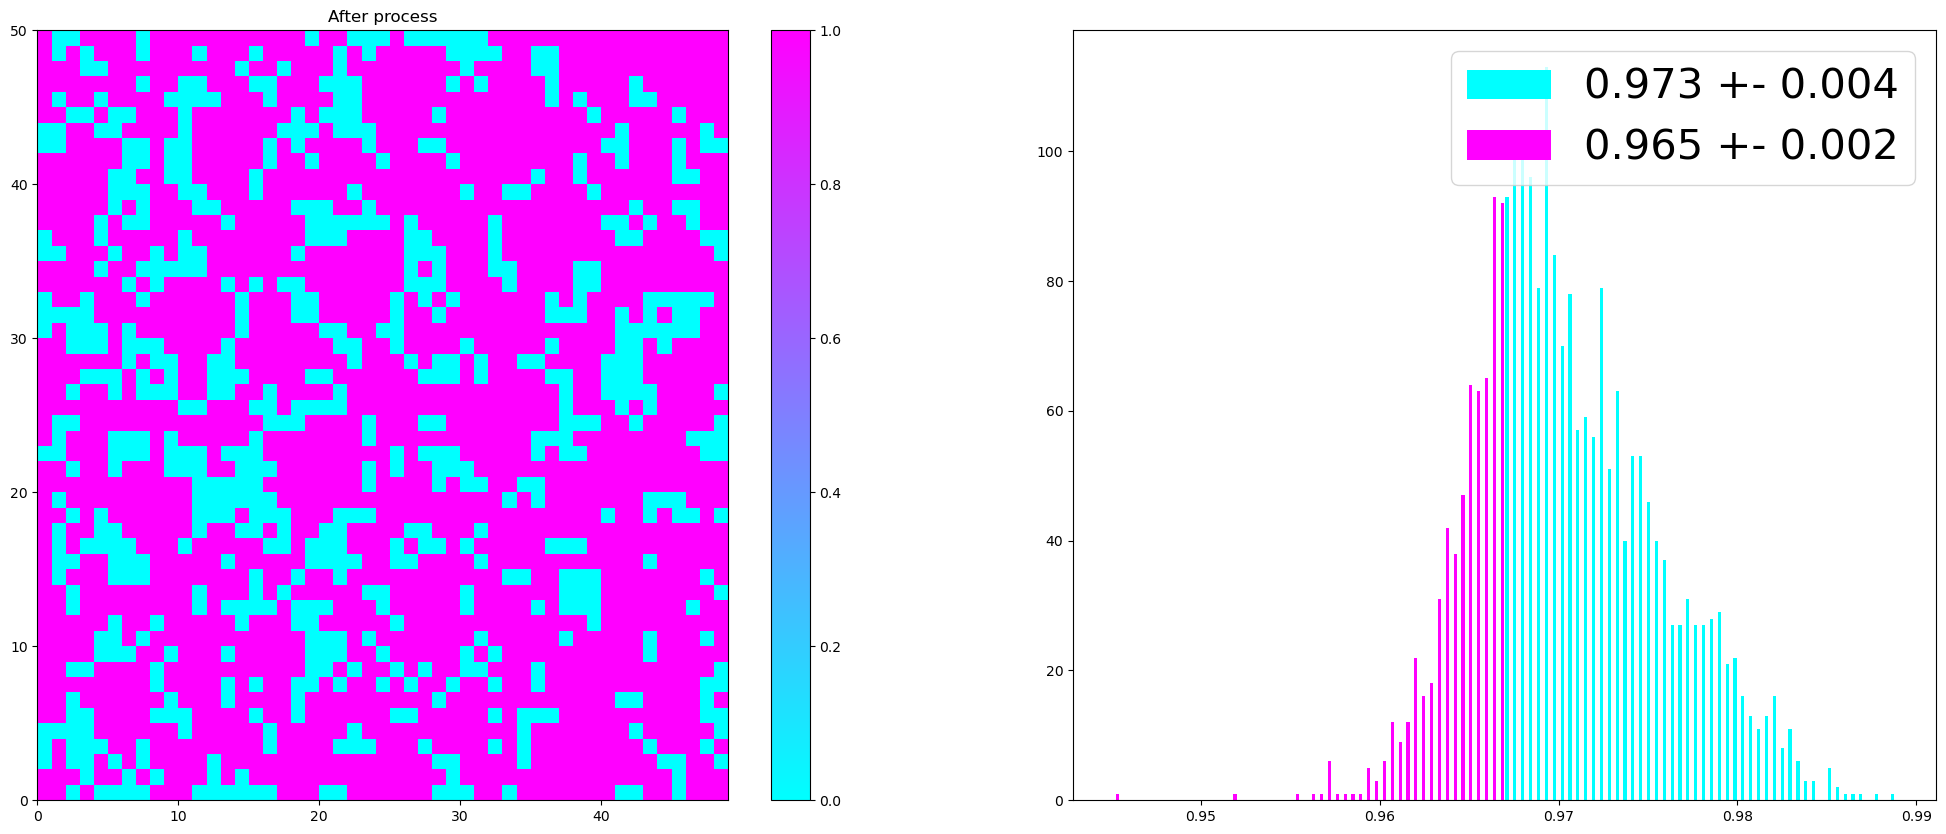

../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_subs-pqty=25.csv with threshold -0.1400146484375
1795


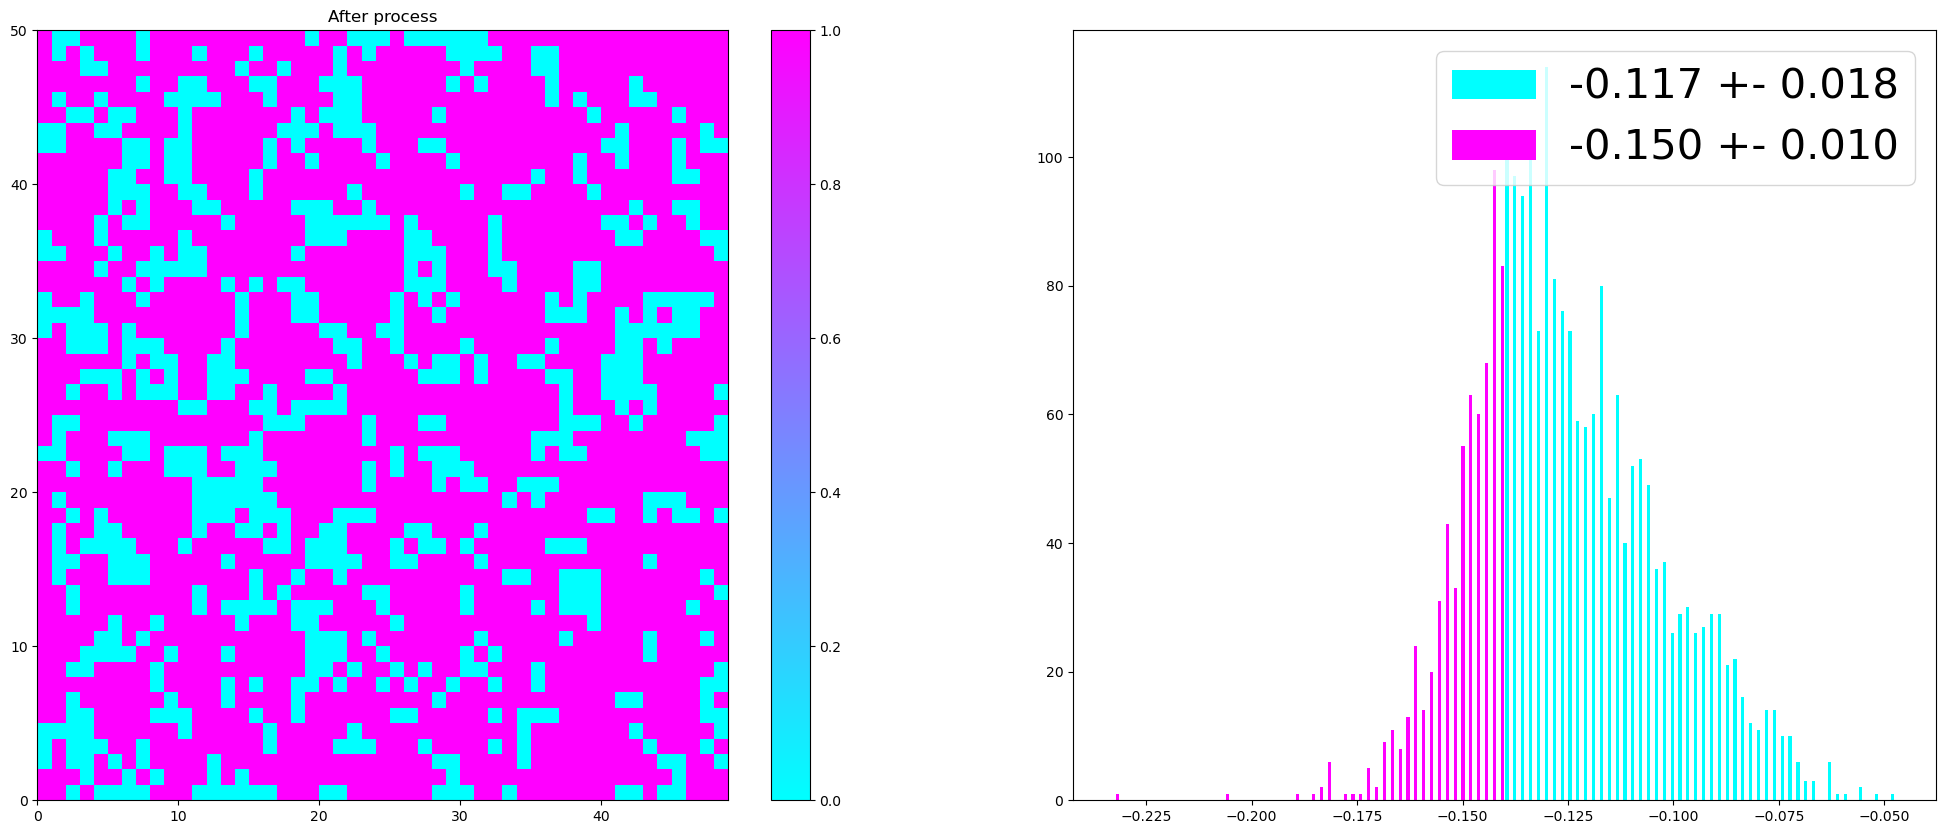

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_div-pqty=25.csv with threshold 2.665955348135679
158


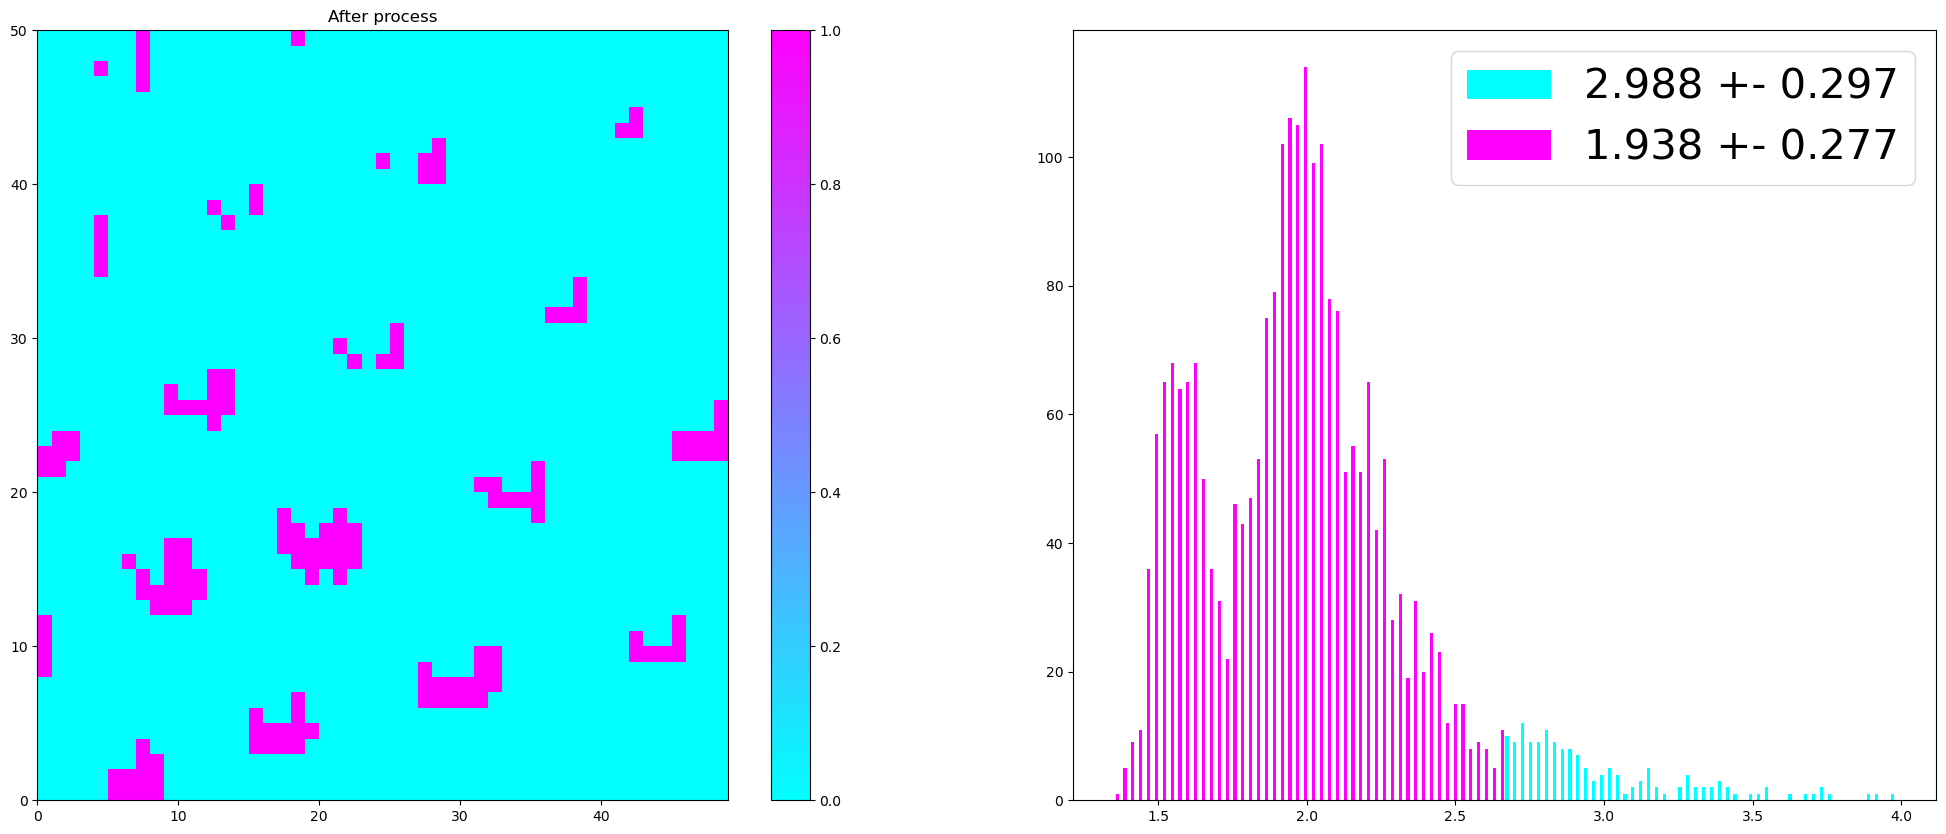

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_subs-pqty=25.csv with threshold 924.13330078125
182


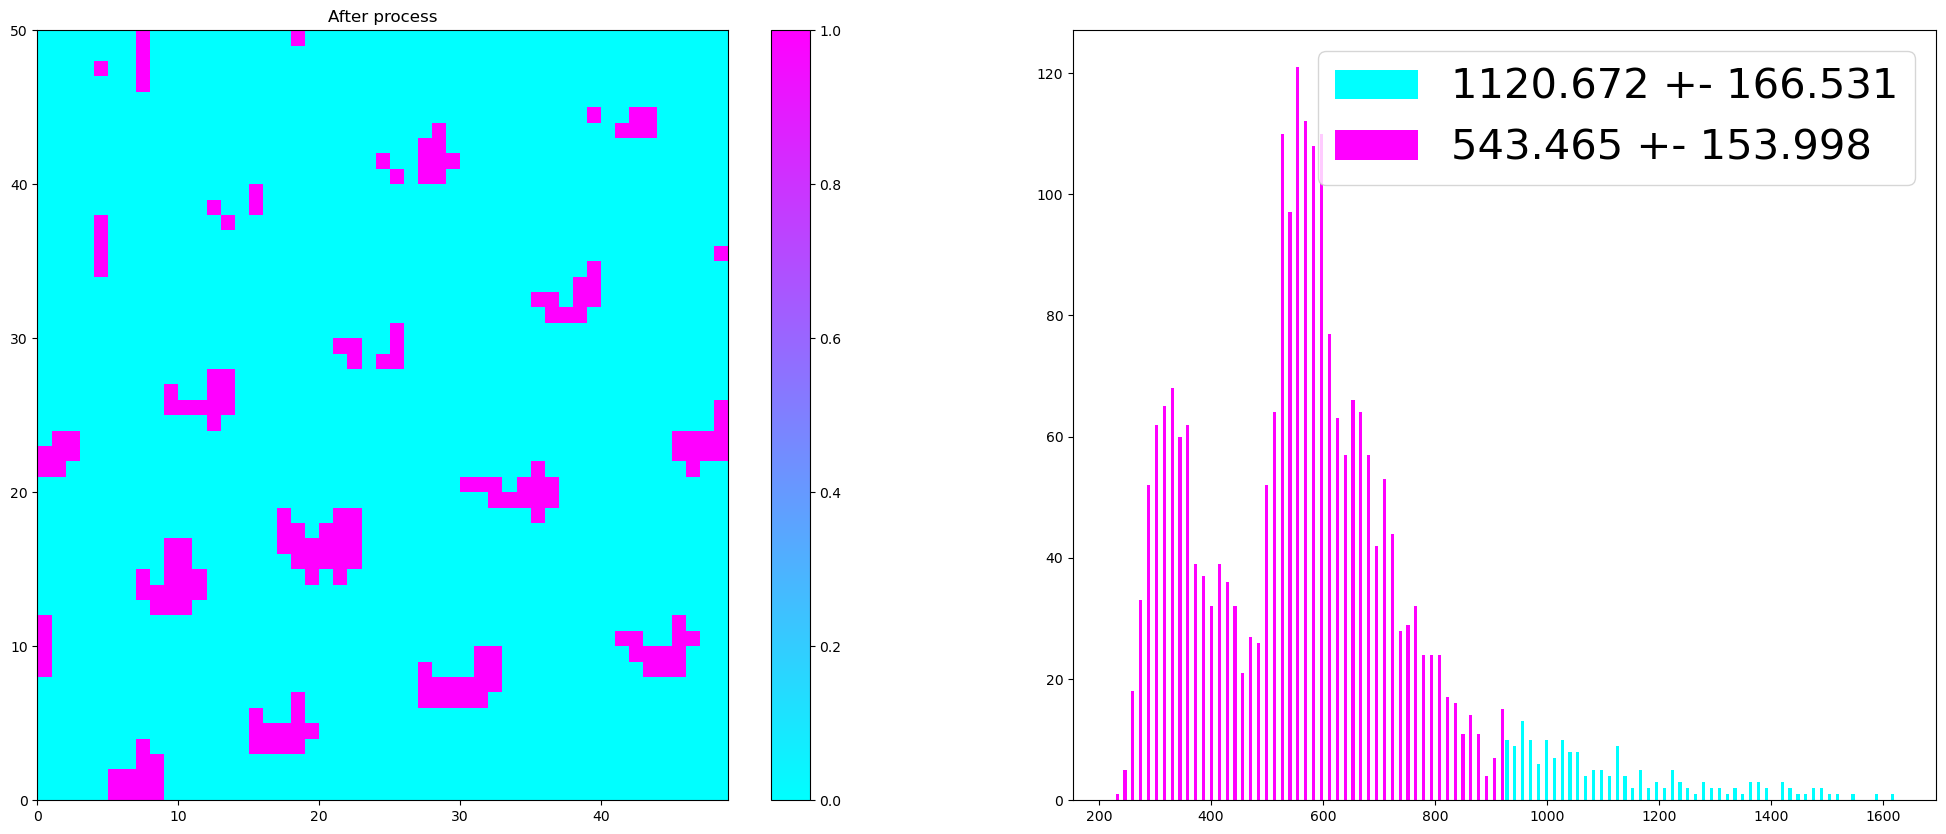

../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_div-pqty=25.csv with threshold 0.9851197845029351
1398


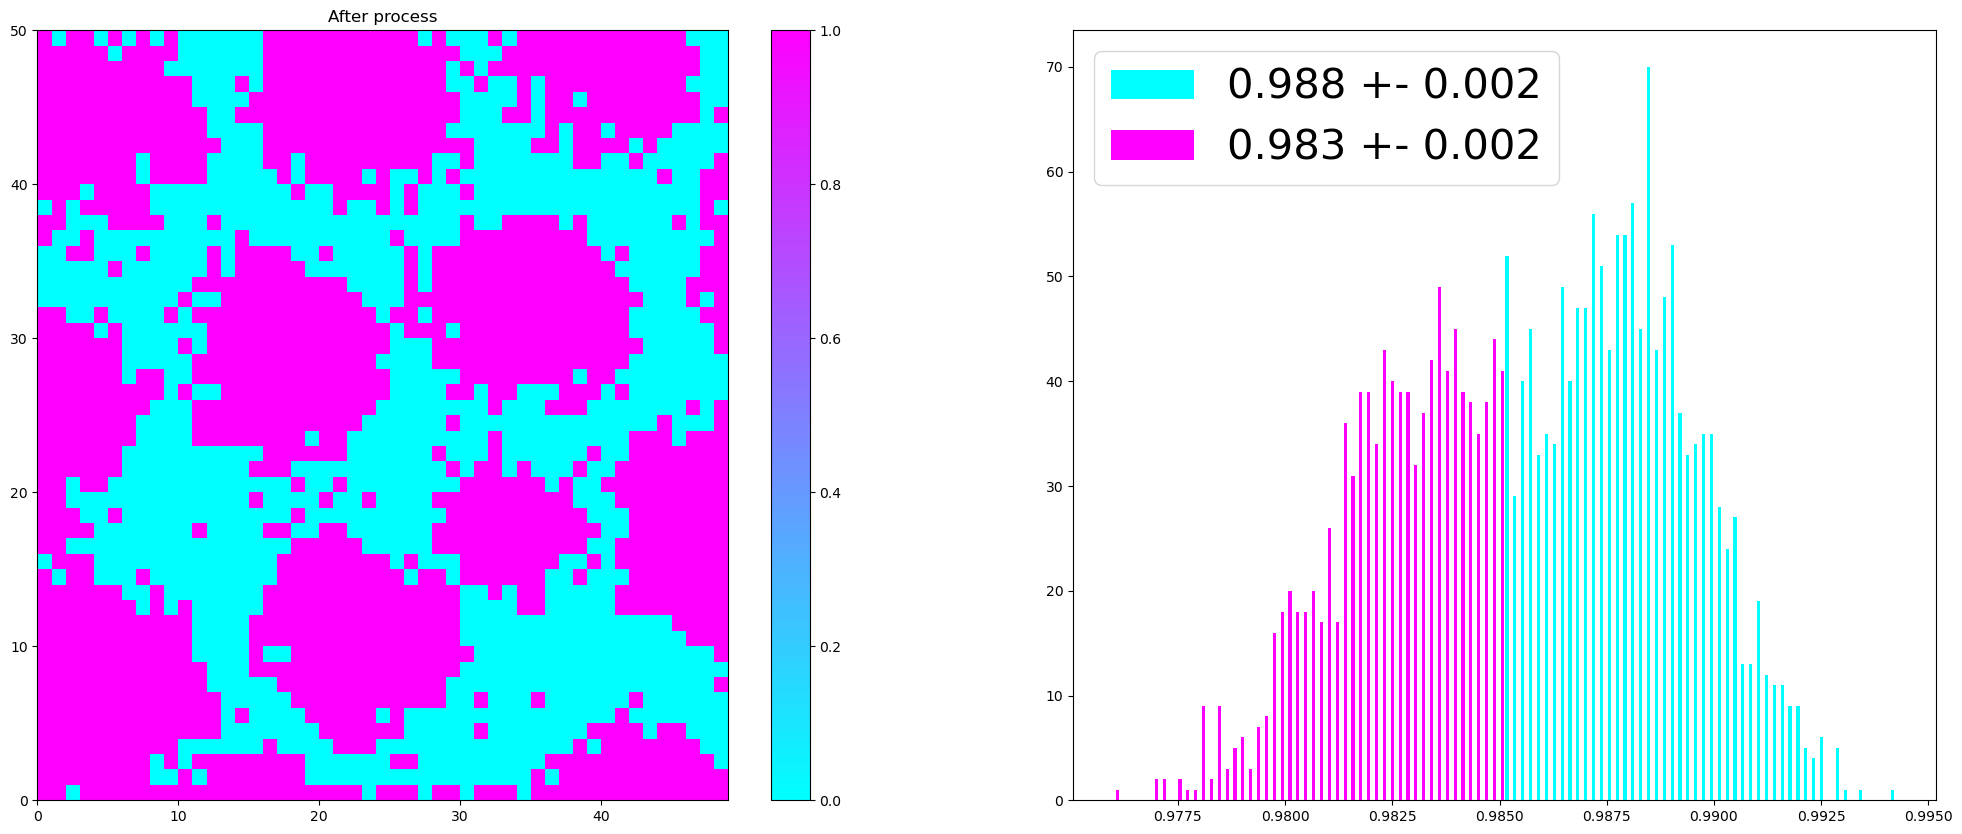

../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_subs-pqty=25.csv with threshold 0.075958251953125
1046


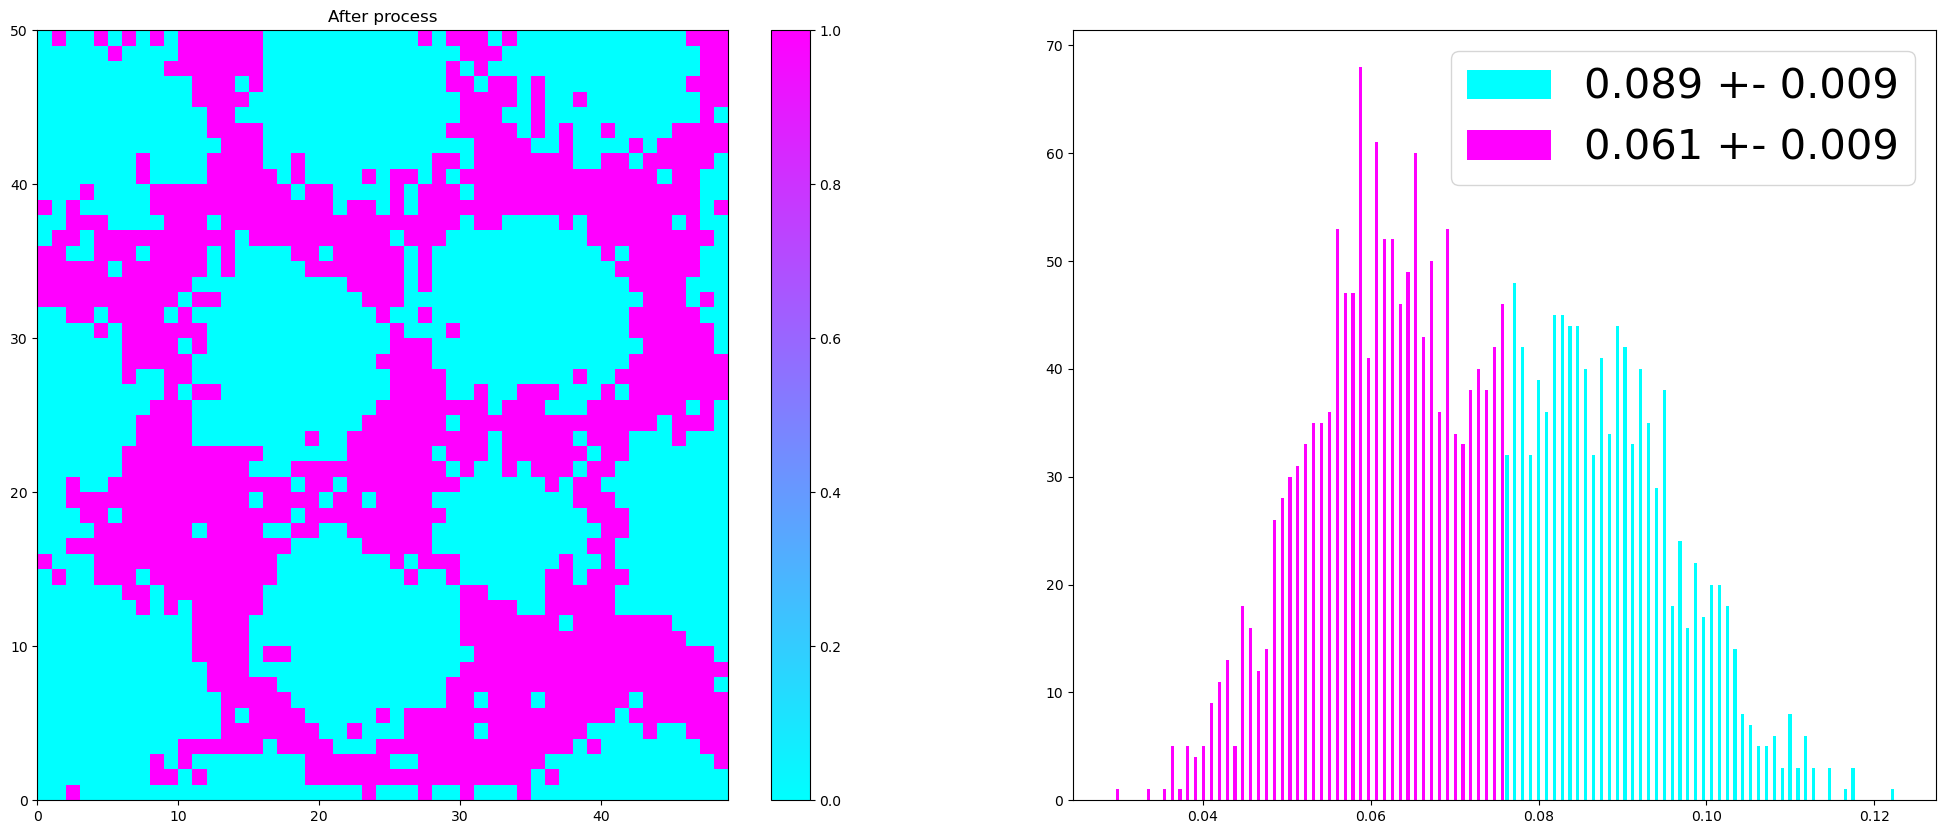

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_div-pqty=25.csv with threshold 1.8313164403369822
36


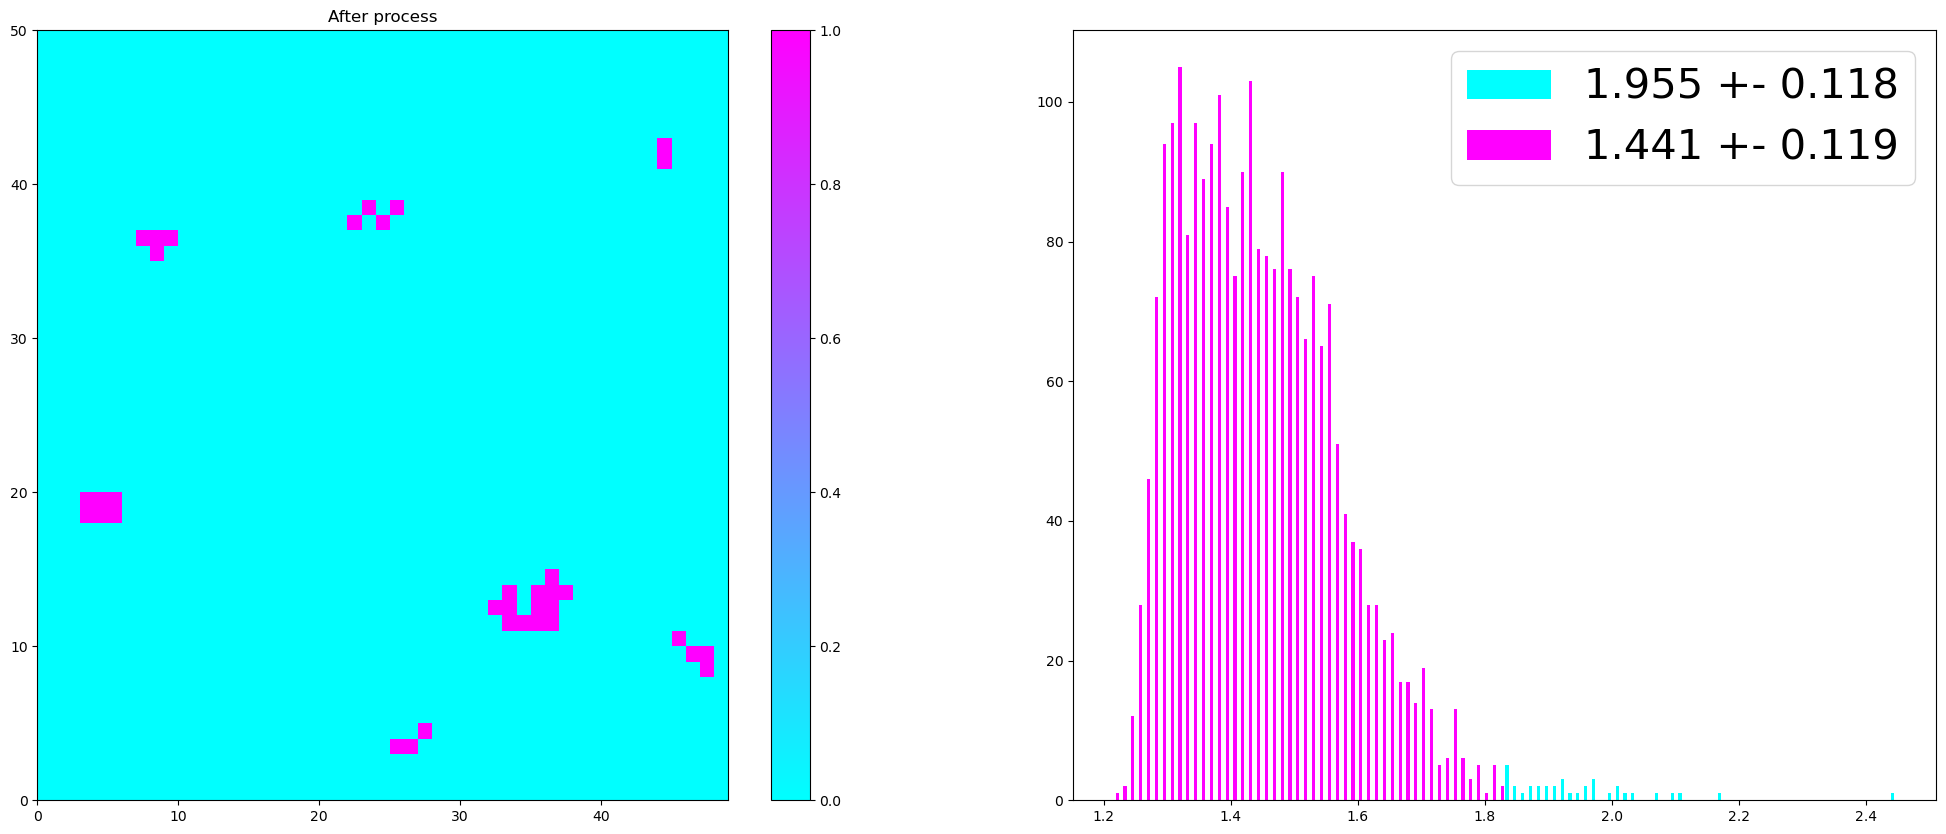

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_subs-pqty=25.csv with threshold -817.840576171875
2419


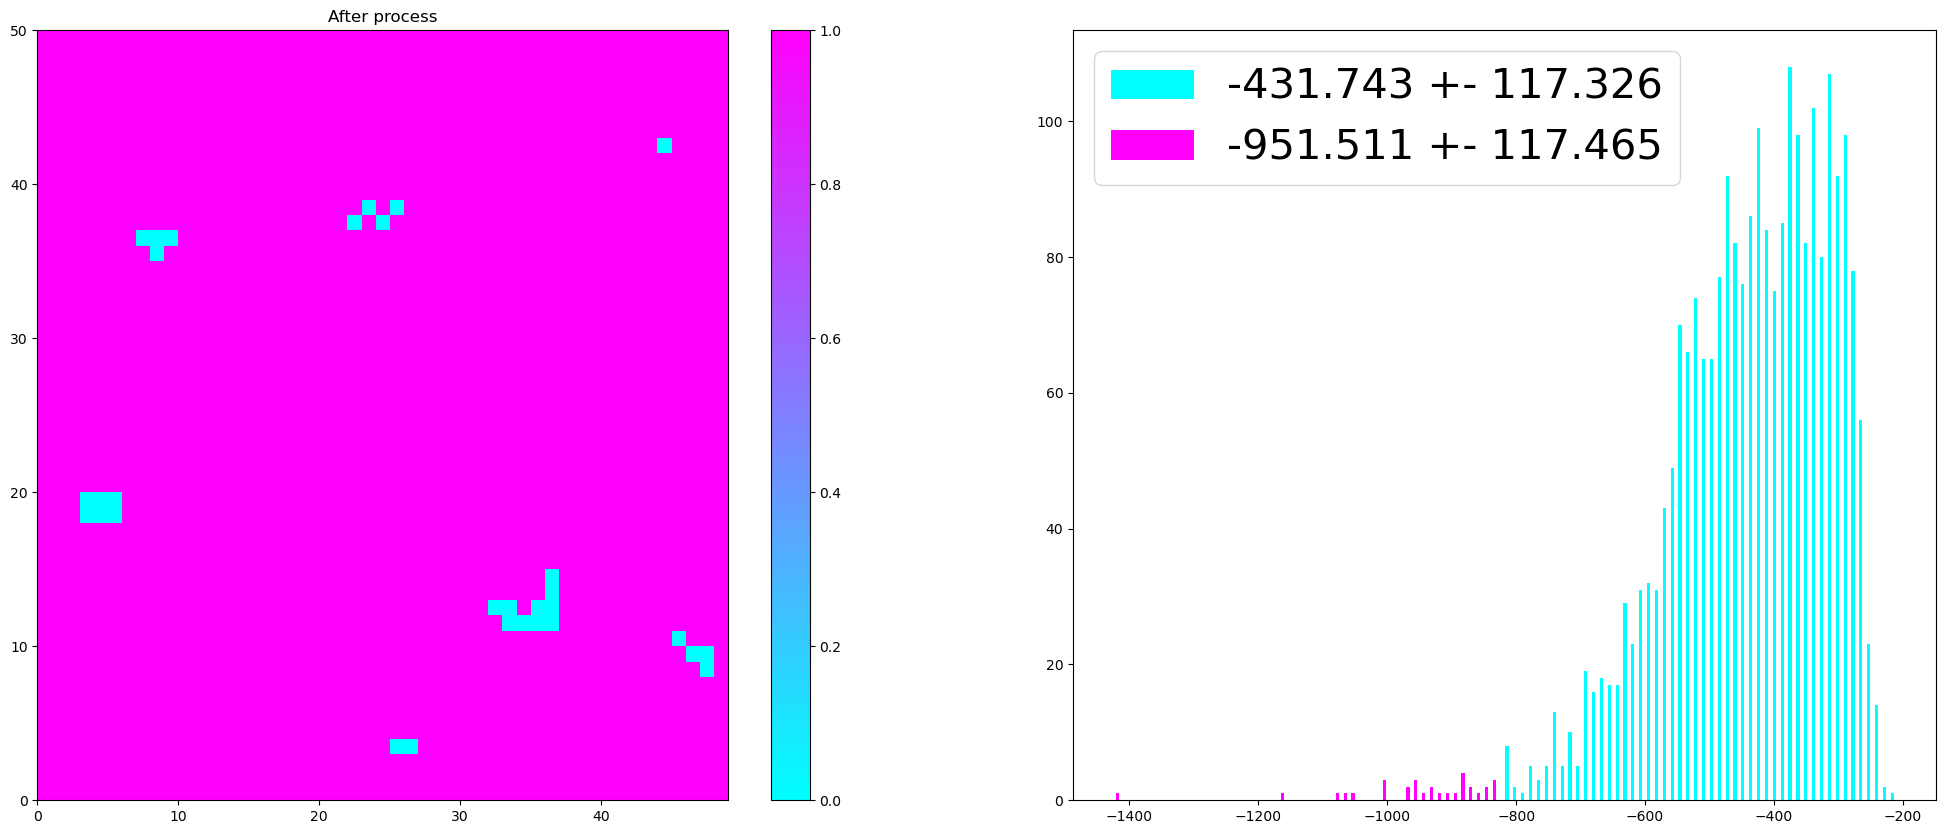

../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_div-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_div-pqty=25.csv with threshold 0.9583820872407508
2396


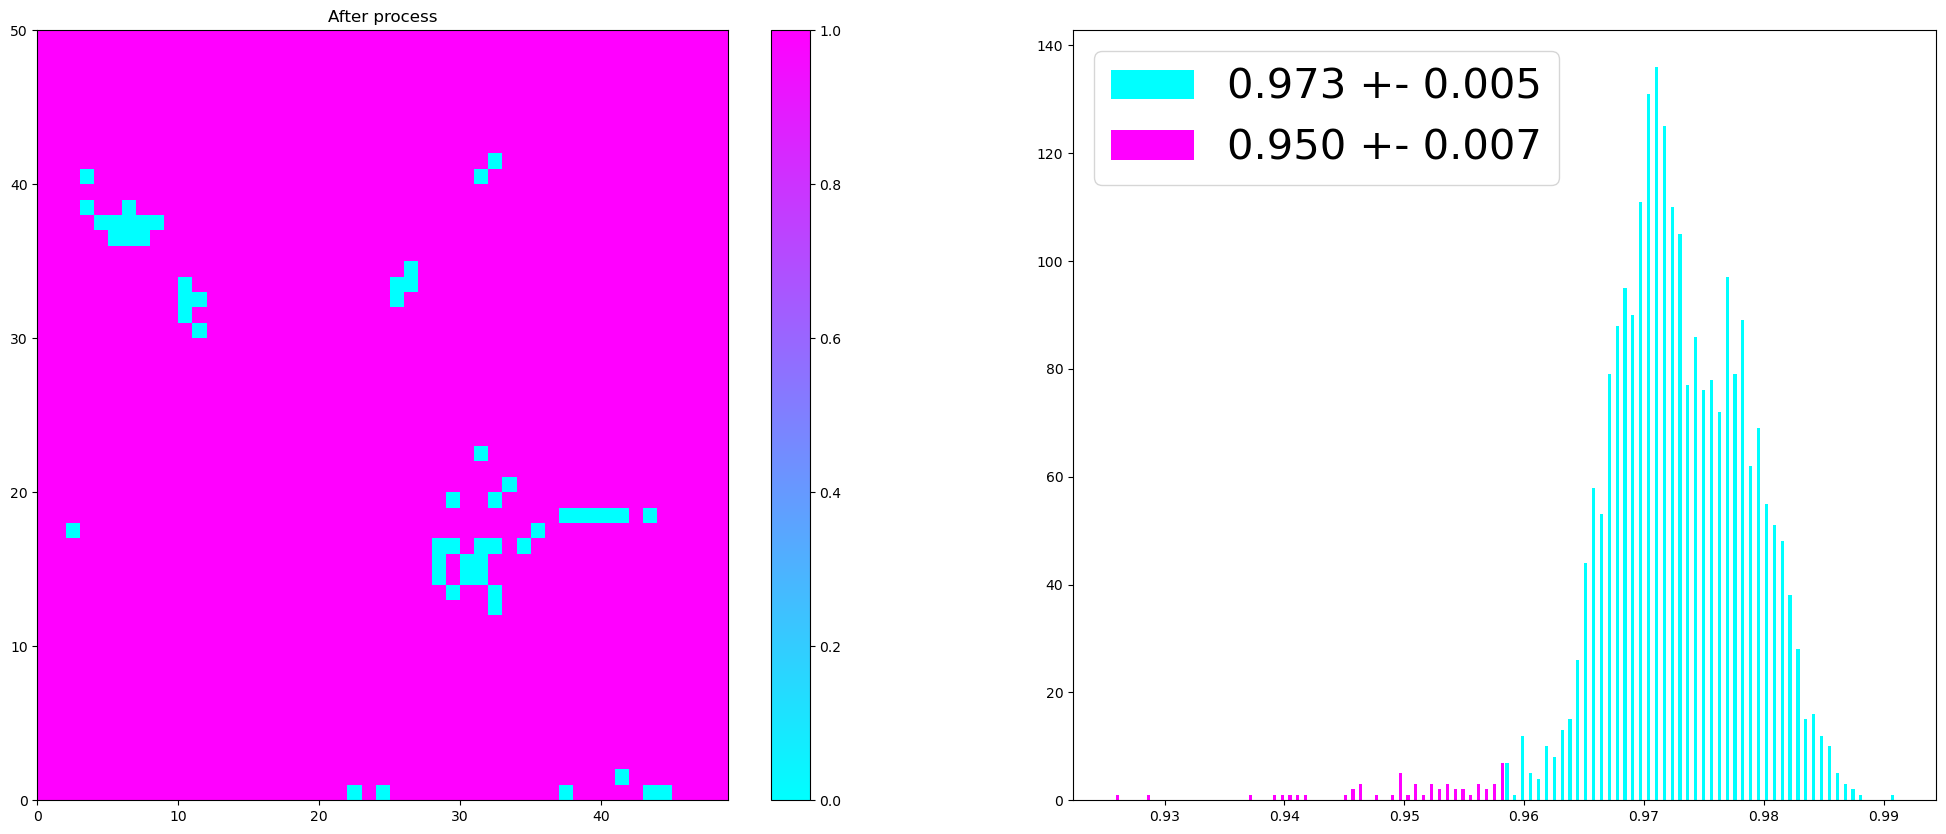

../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_subs-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_subs-pqty=25.csv with threshold -0.17712390422821045
2395


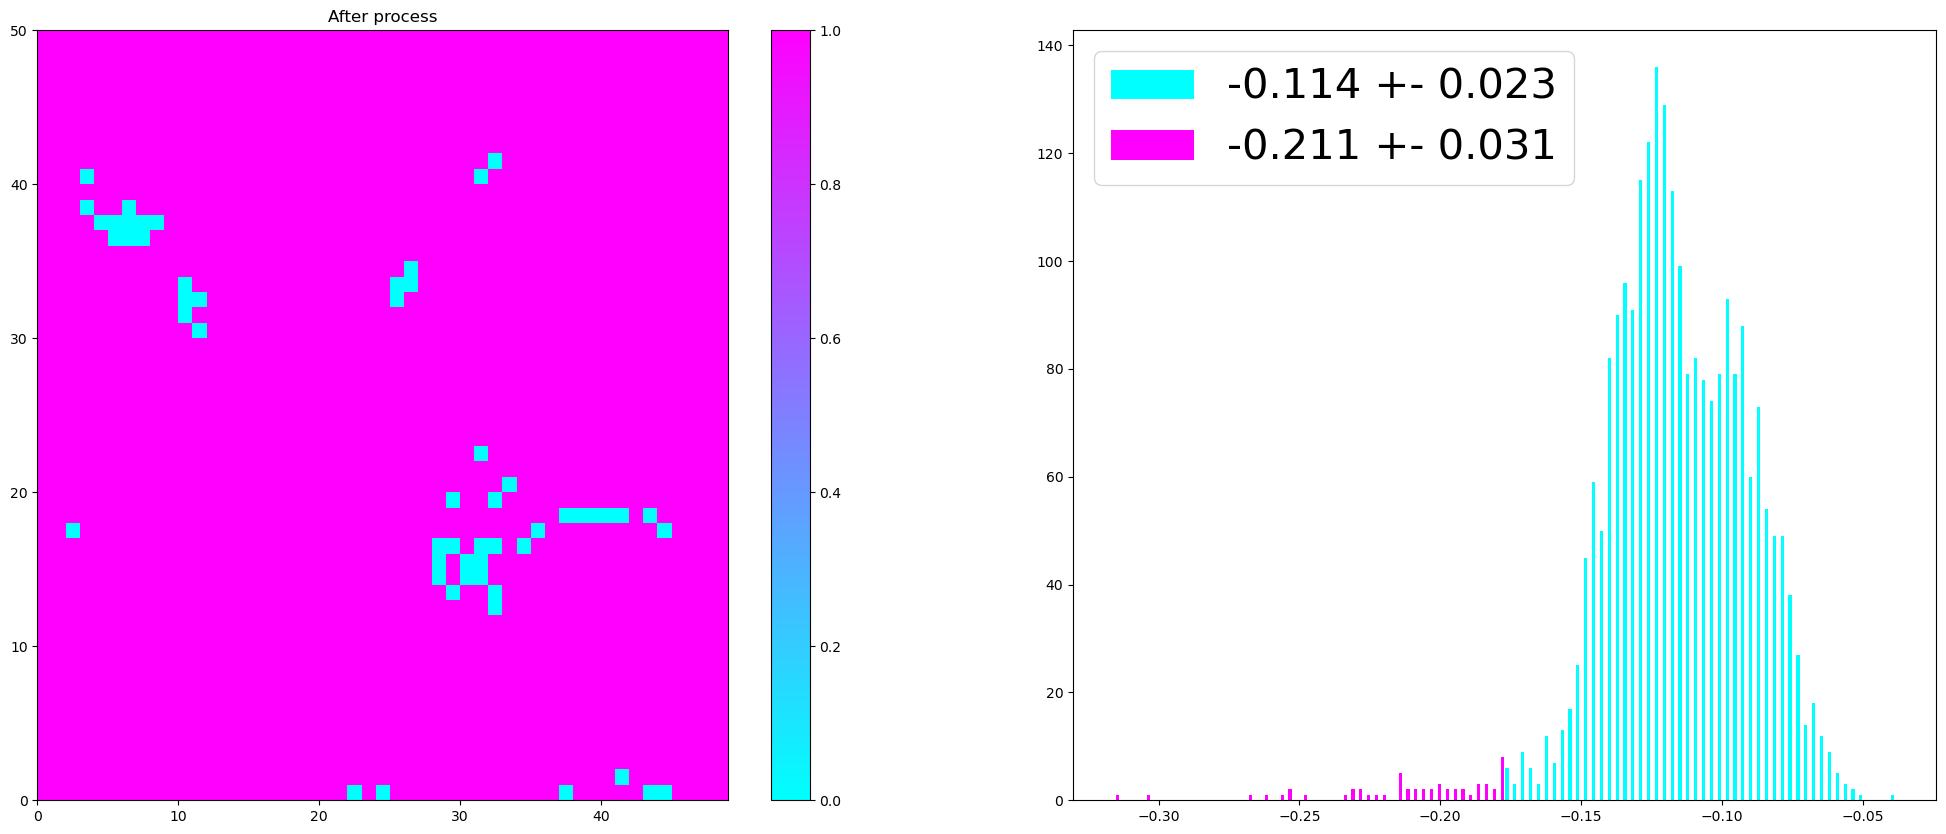

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_div-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_div-pqty=25.csv with threshold 3.4532065585748546
96


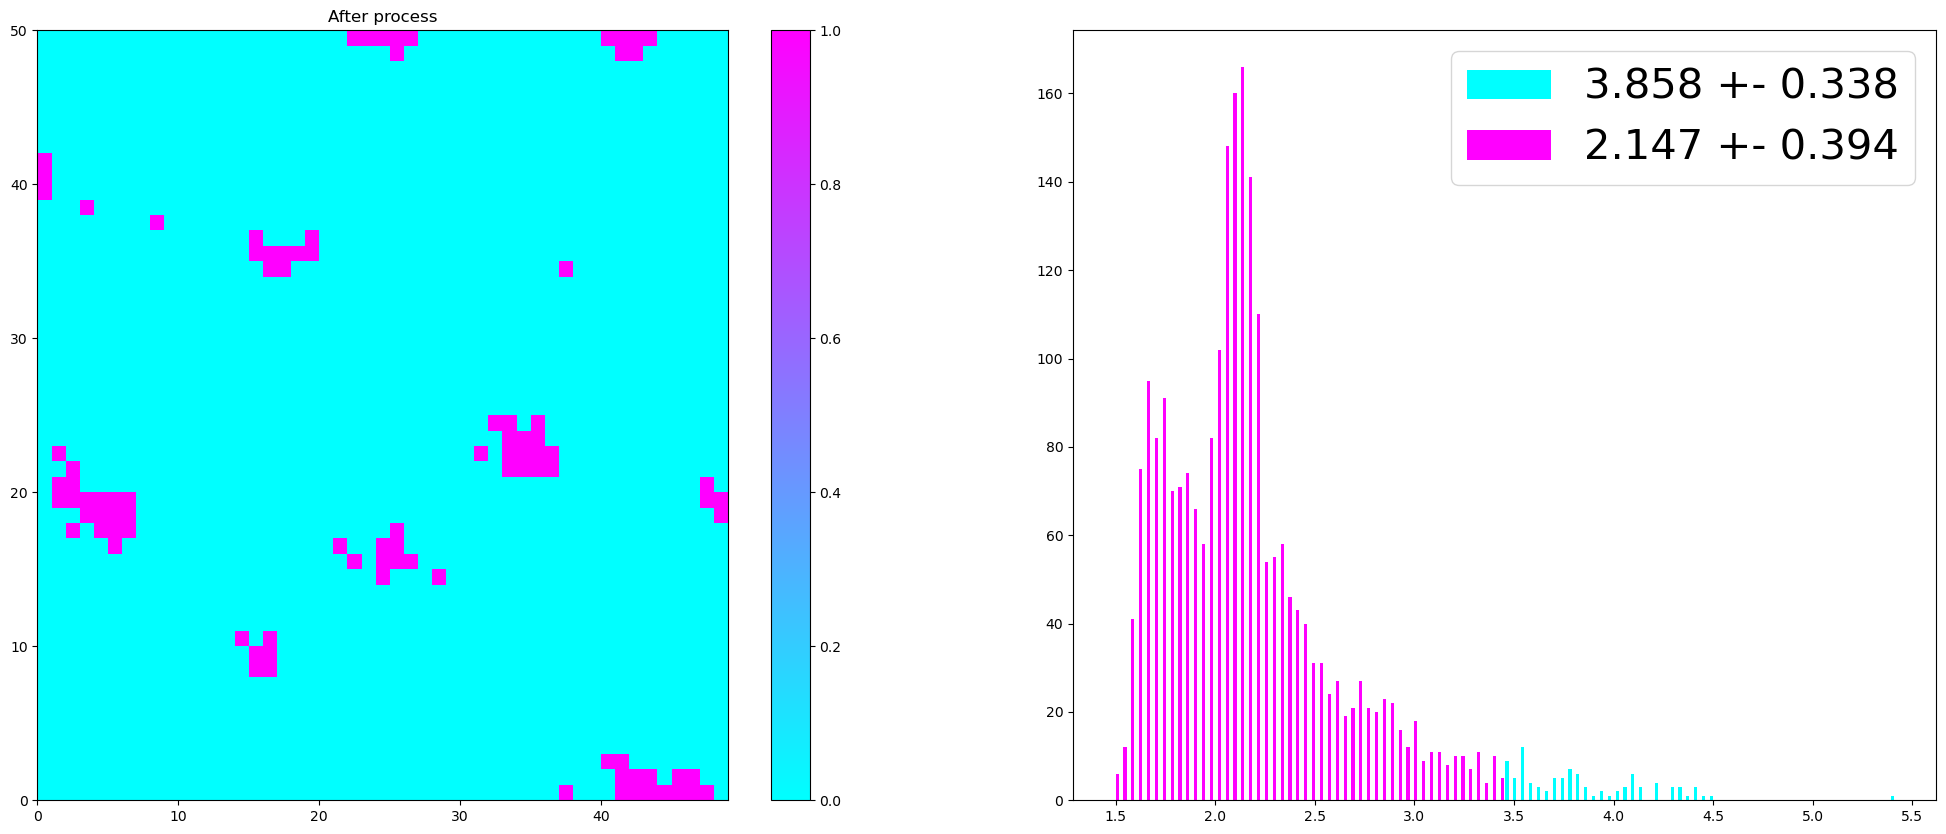

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_subs-pqty=25.csv
Drawing the result of ../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_subs-pqty=25.csv with threshold 1211.395263671875
106


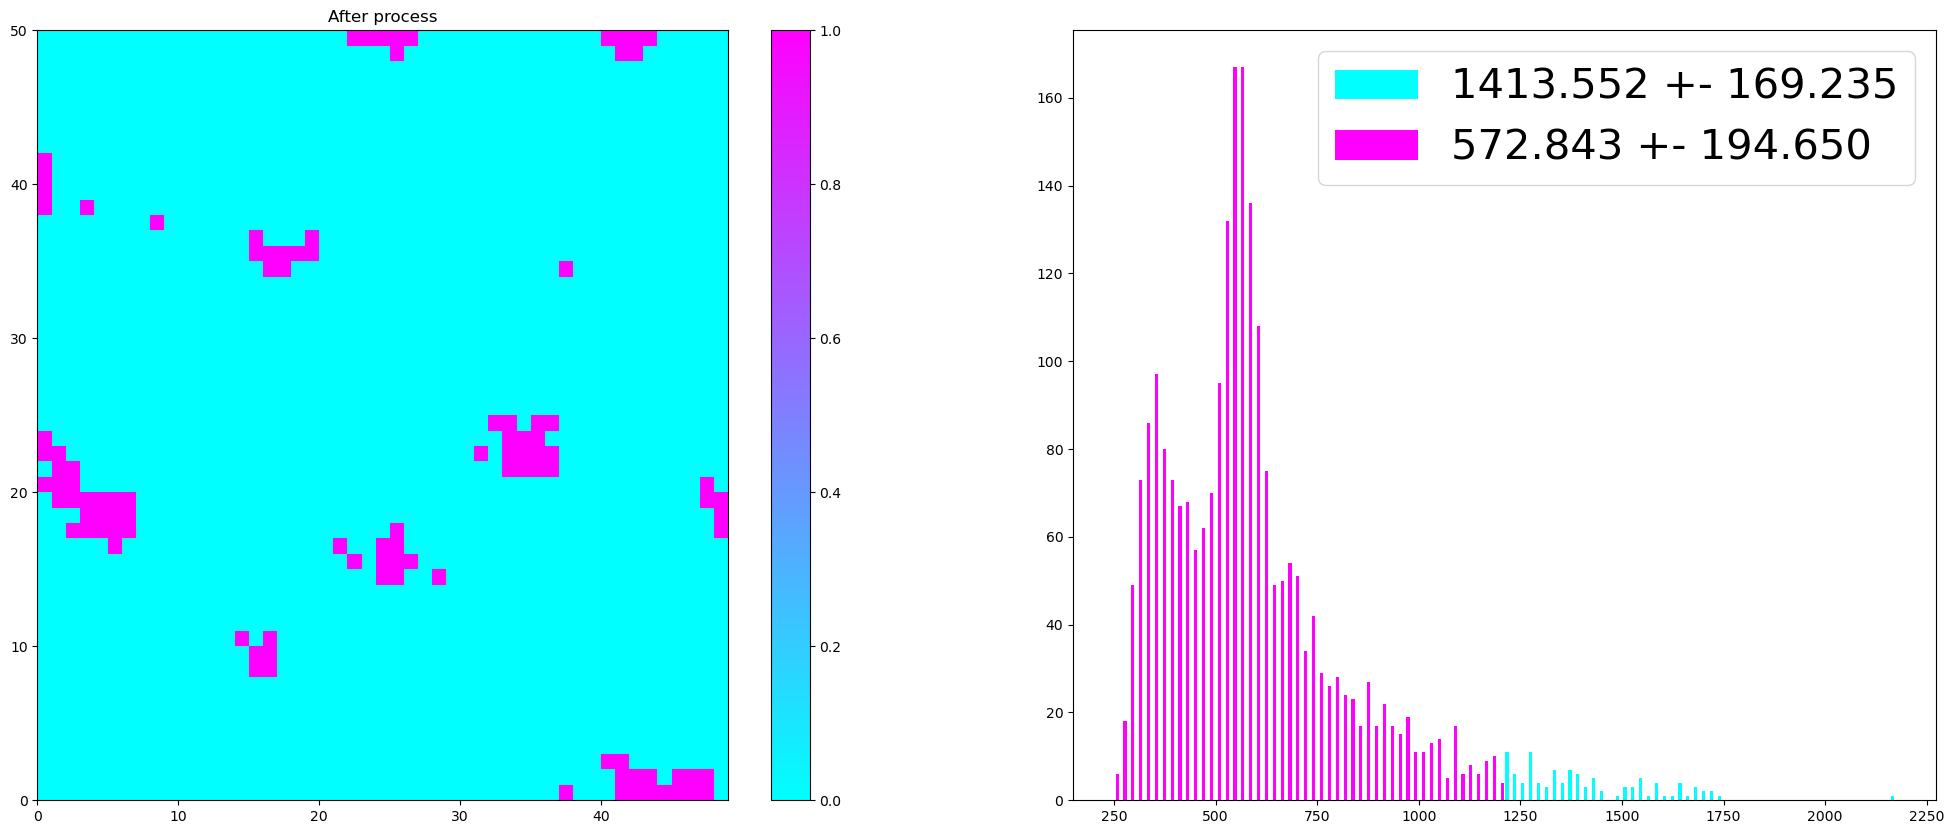

In [137]:
# Find a threshold value to divide data into 2 normal distribution sets
# Fail
'''
for f in files:
    Z = process(f)
    if len(Z)!=0:
        bins = find_threshold(Z)
        if len(bins) == 0:
            print(f"Fail to find a threshold value for {f}")
        else:
            for b in bins:
                print(f"Drawing the result of {f} with threshold {b}")
                z_dig = np.digitize(Z,[b])
                plot_2stat(Z,z_dig)
'''

# Unsupervised Machine Learning Method

In [168]:
from sklearn.cluster import KMeans

Z = process(files[5])
Zt = transform(Z)
# Create a k-means clustering model with 3 clusters
kmeans = KMeans(n_clusters=30)

# Fit the model to the data
kmeans.fit(Zt)

# Predict the cluster labels for each data point
labels = kmeans.predict(Zt)

# View the cluster labels for each data point
print(labels)

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv
[0 0 0 ... 5 5 5]


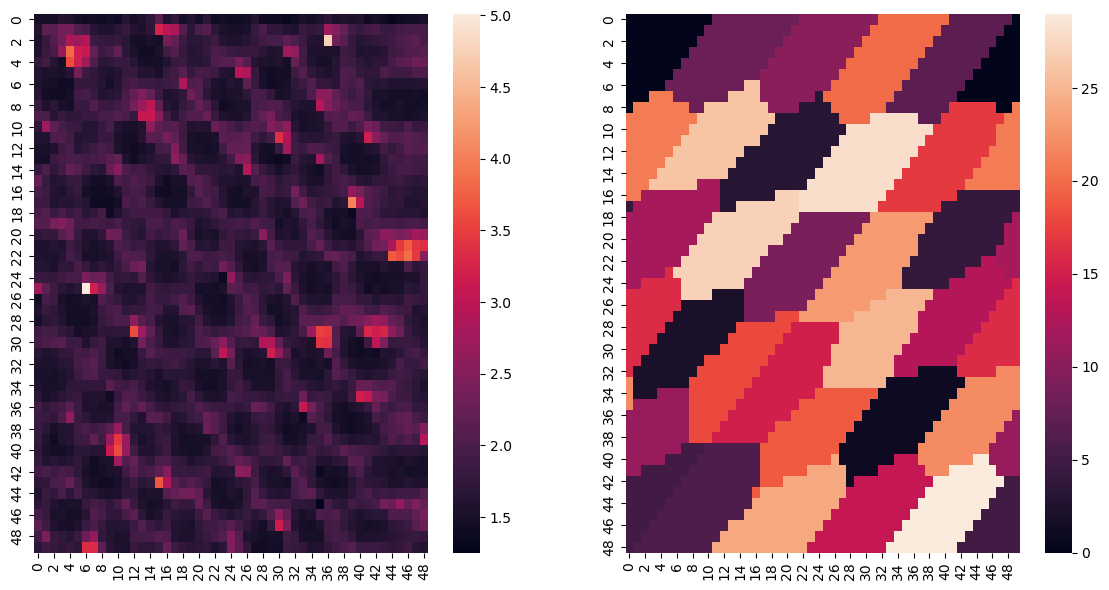

In [169]:
plot_labels(Z,labels)

In [154]:
from sklearn.svm import OneClassSVM
Z = process(files[5])
Zt = transform(Z)

clf = OneClassSVM(kernel='poly',gamma='auto').fit(Zt)
np.unique(clf.predict(Zt))

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv


array([-1,  1], dtype=int64)

C:\Users\caleb\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


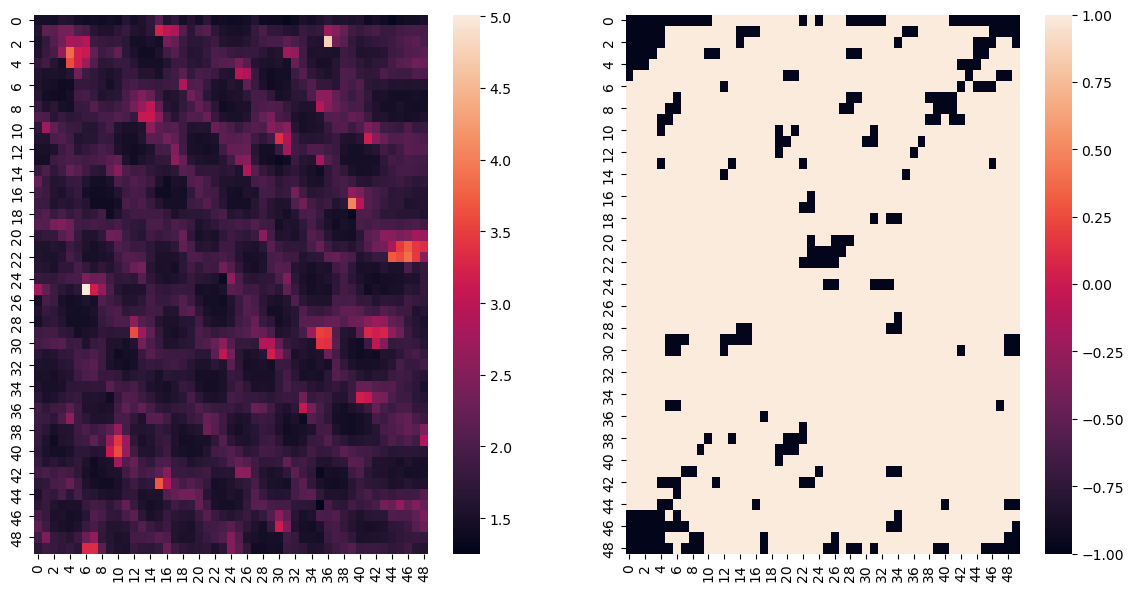

In [177]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination = 0.1,random_state=35).fit(Zt)
np.unique(clf.predict(Zt))
plot_labels(Z,clf.predict(Zt))

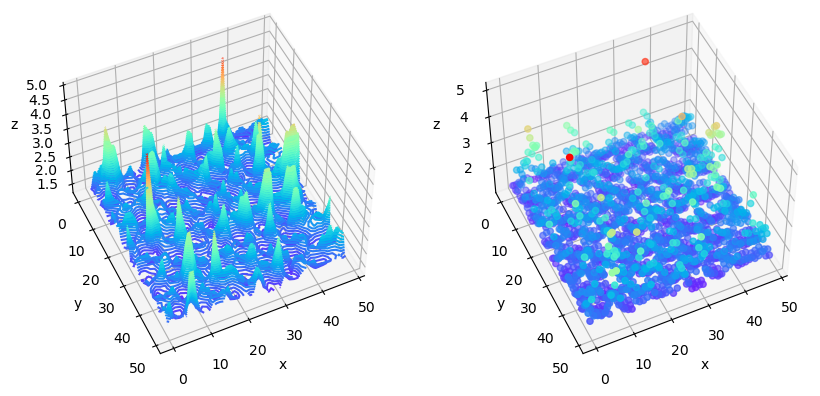

In [130]:
plot_3d(Z,ele_deg=50,azi_deg = 65)

49 50


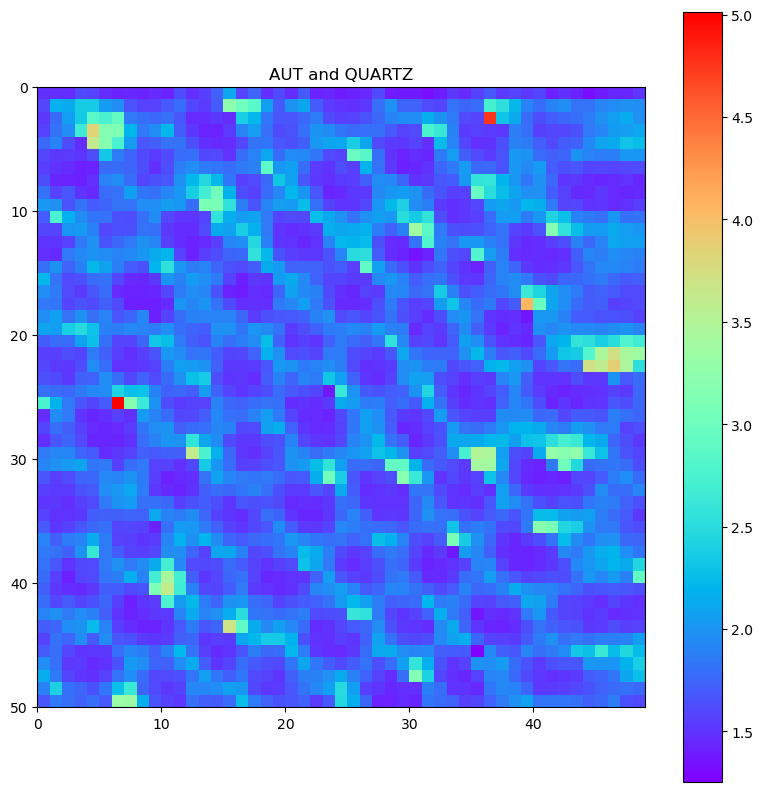

In [114]:
plot_colormap(Z)

../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_div-pqty=25.csv
1266


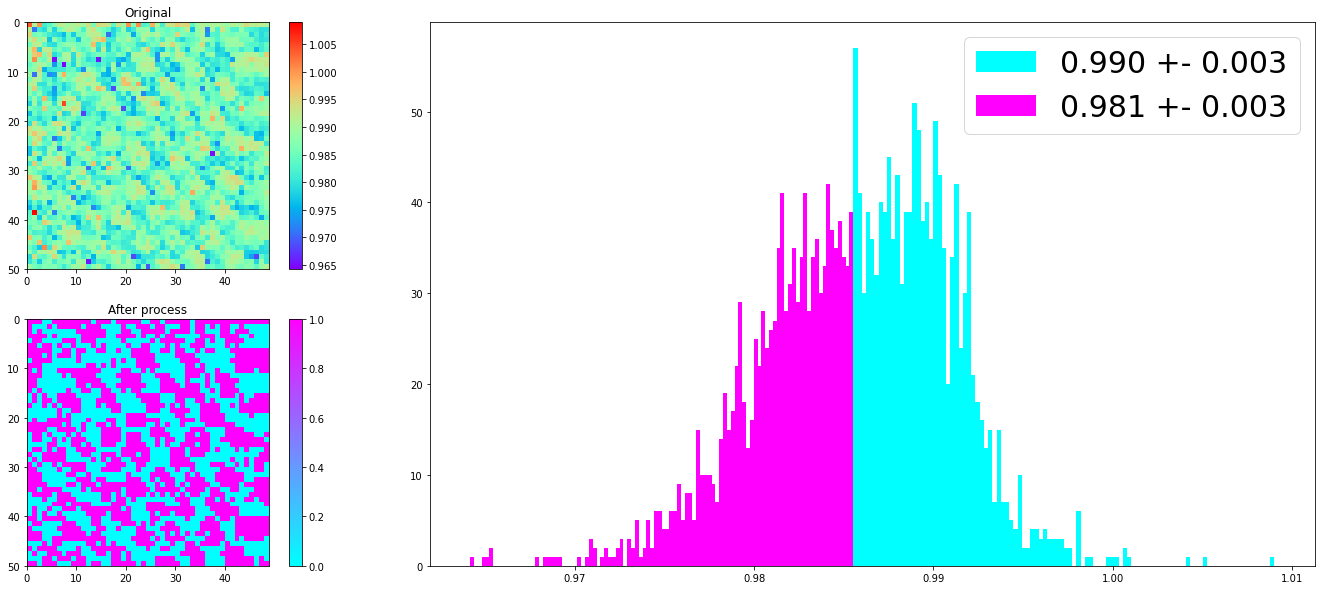

../data/221115_review/A_221015_250nm_negative/22o15003.abf_current_subs-pqty=25.csv
1181


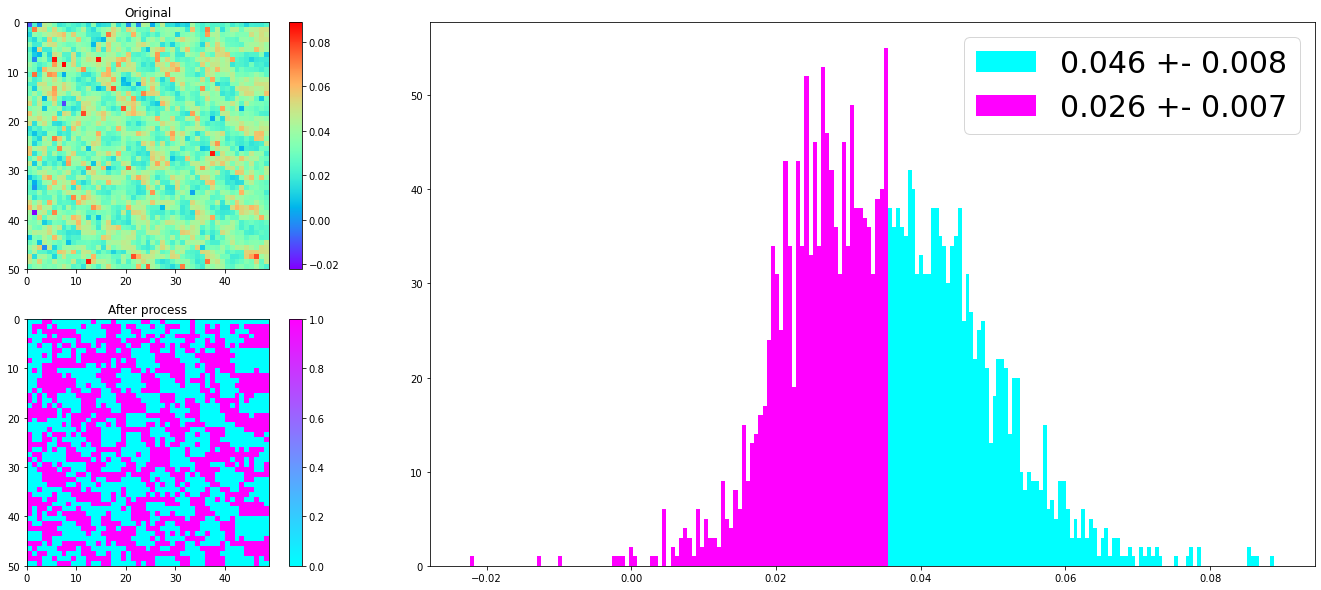

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_div-pqty=25.csv
1009


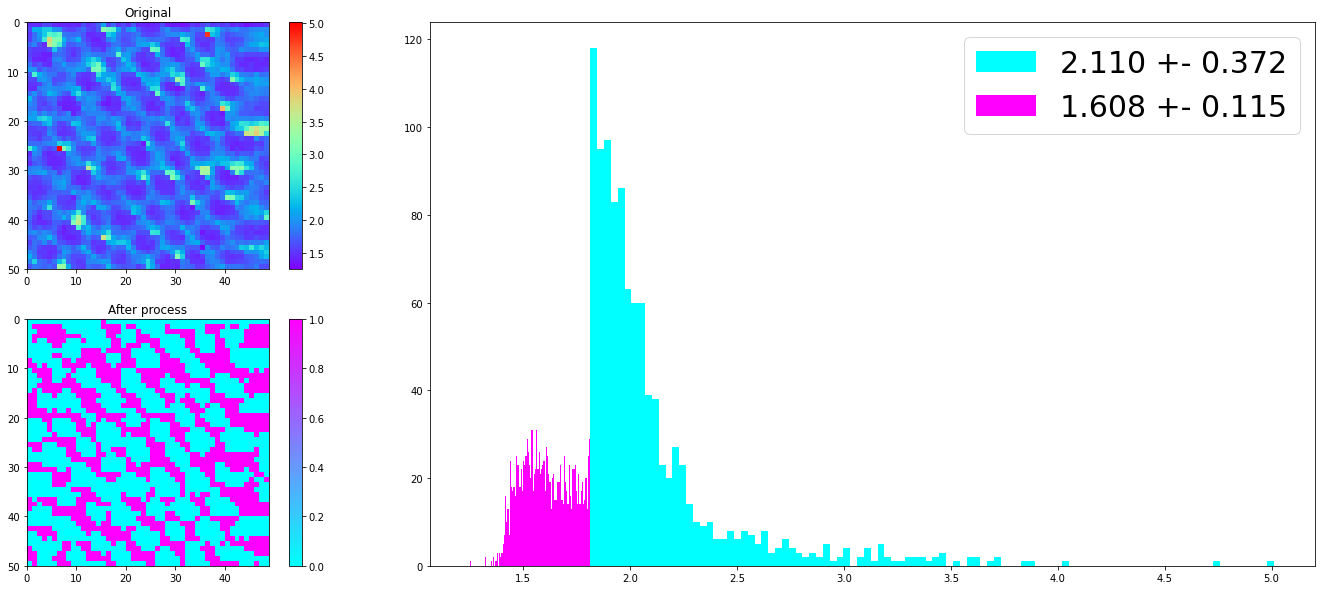

../data/221115_review/A_221015_250nm_negative/22o15003.abf_EMF_subs-pqty=25.csv
1437


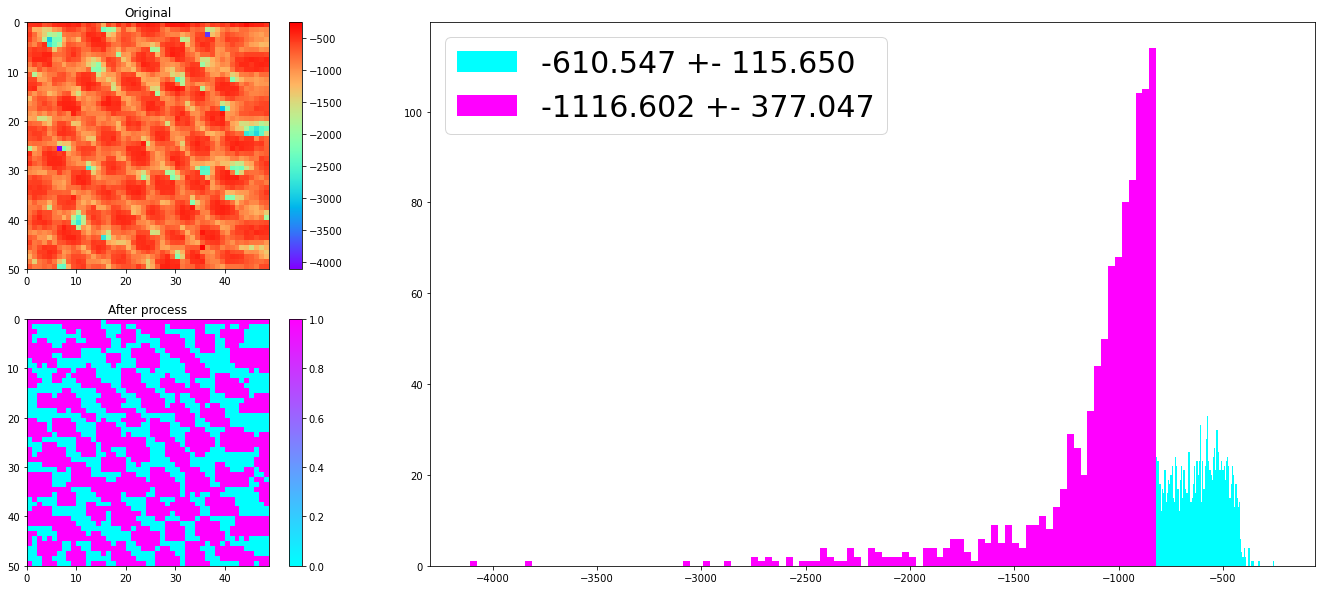

../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_div-pqty=25.csv
1357


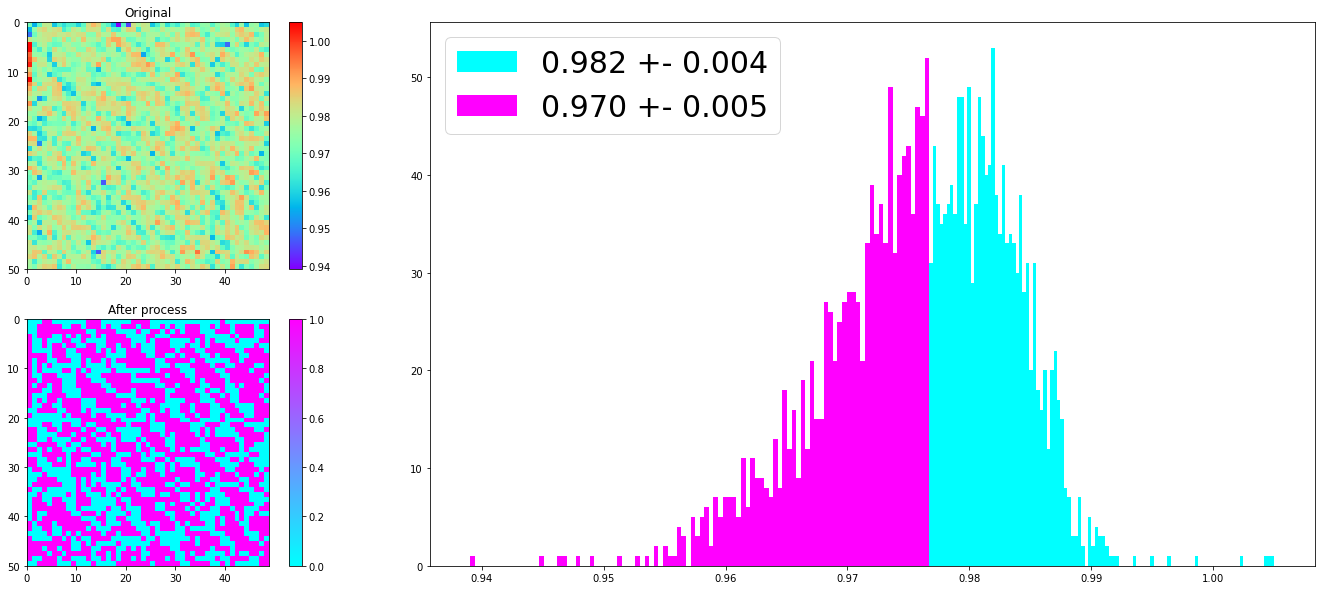

../data/221115_review/A_221015_250nm_positive/22o15002.abf_current_subs-pqty=25.csv
1353


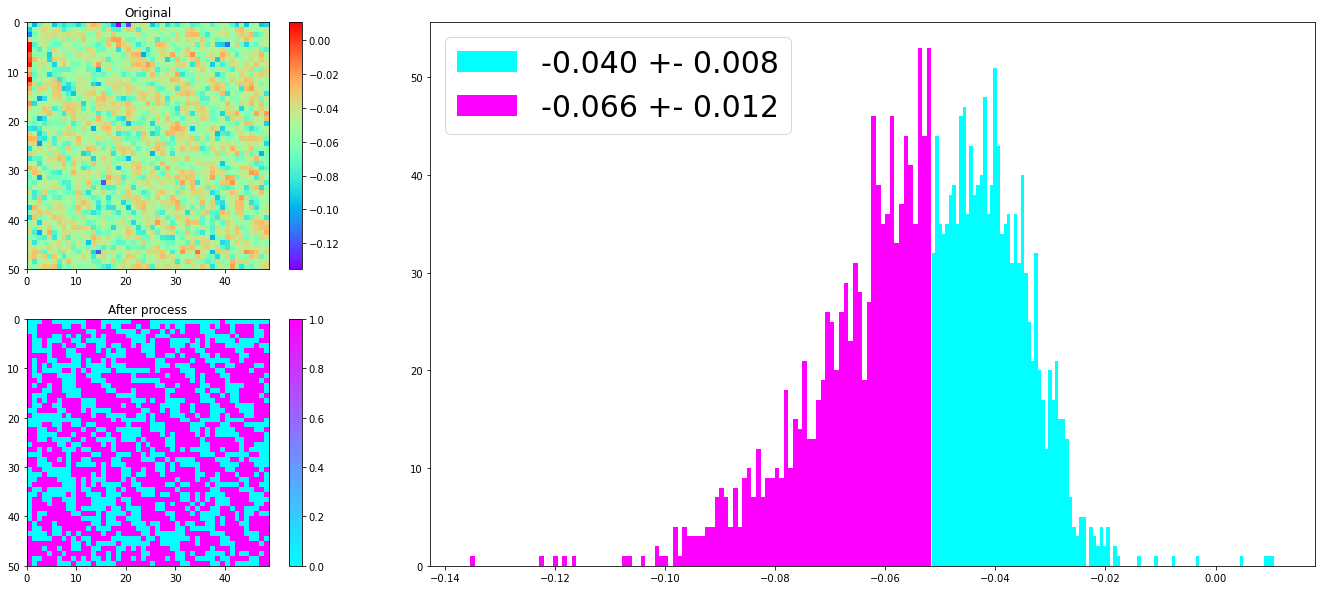

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_div-pqty=25.csv
1121


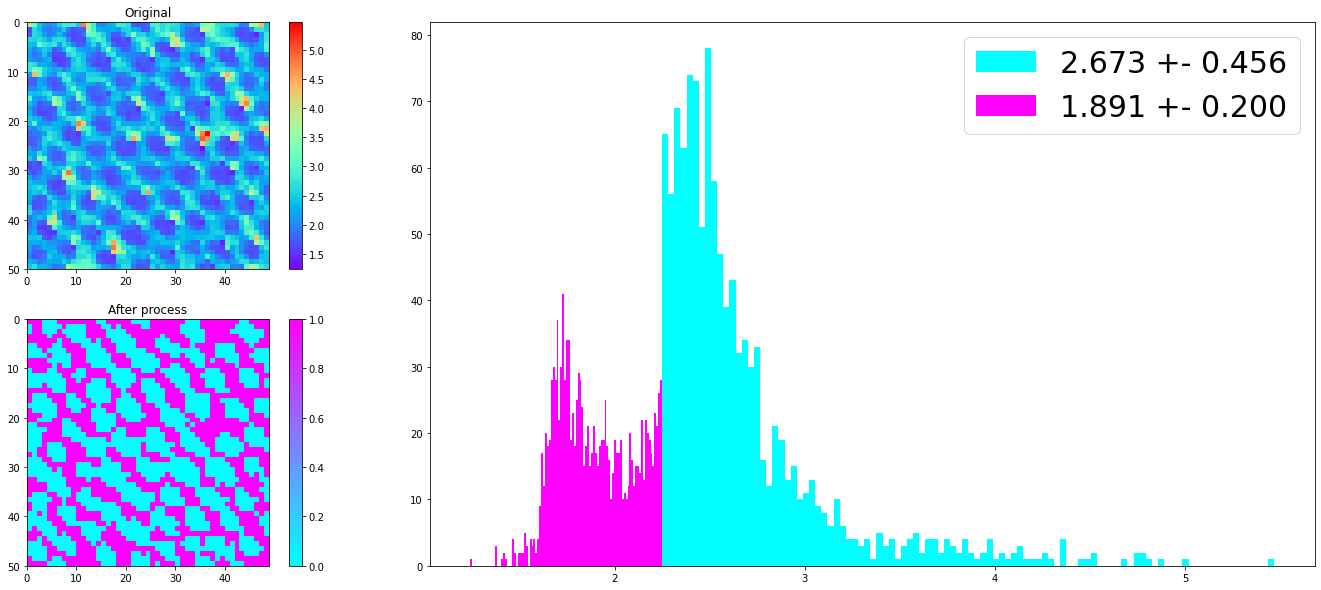

../data/221115_review/A_221015_250nm_positive/22o15002.abf_EMF_subs-pqty=25.csv
1120


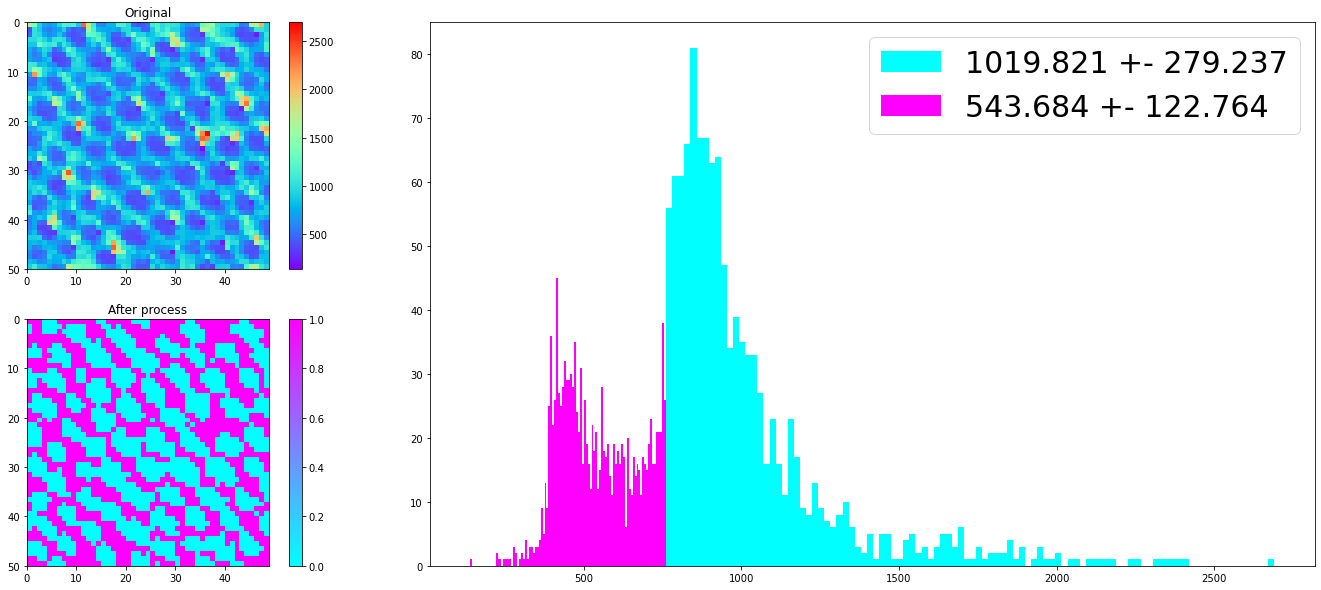

../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_div-pqty=25.csv
1488


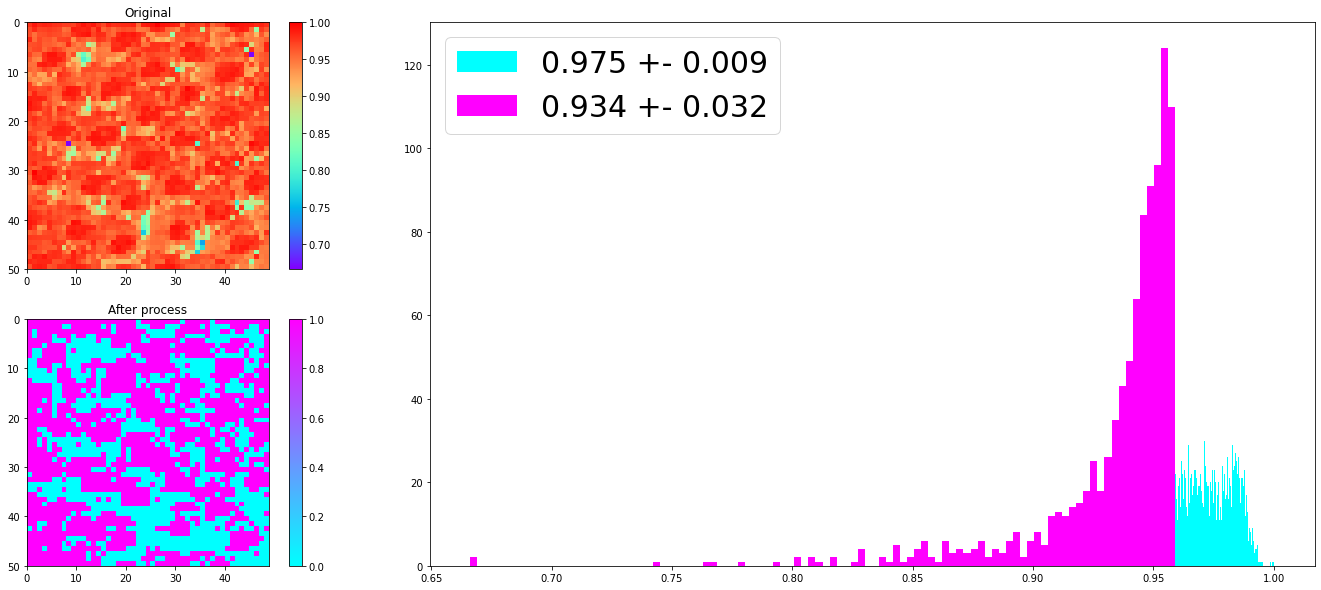

../data/221115_review/B_221109_380nm_negative/22n09004.abf_current_subs-pqty=25.csv
958


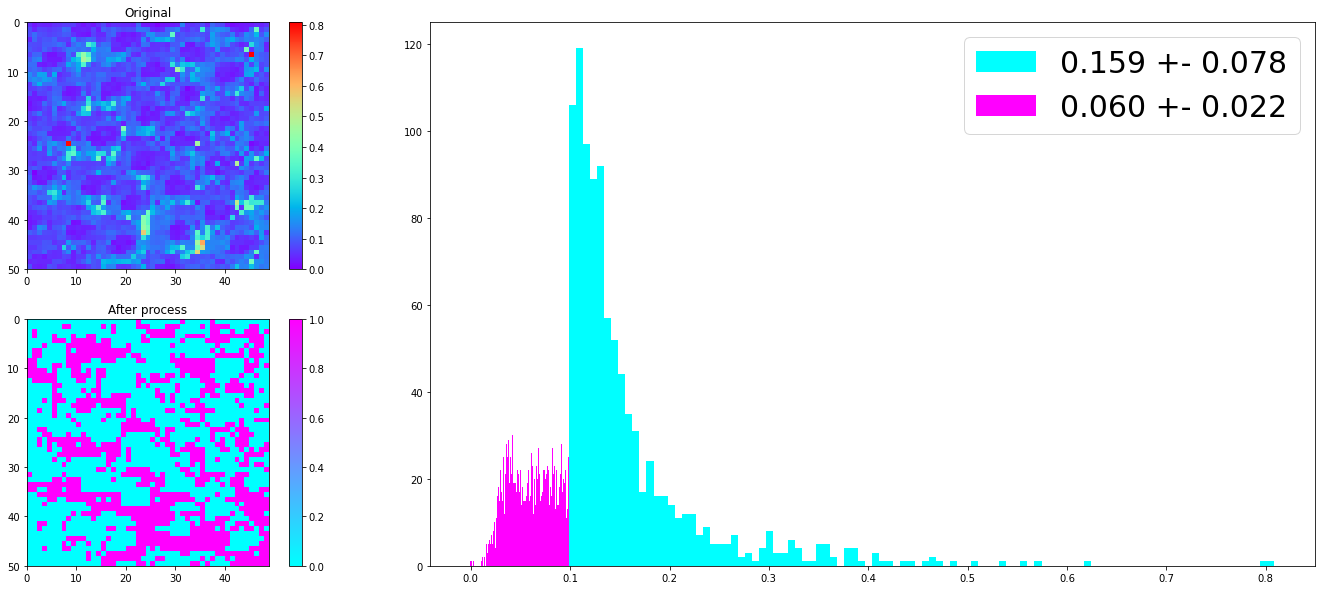

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_div-pqty=25.csv
906


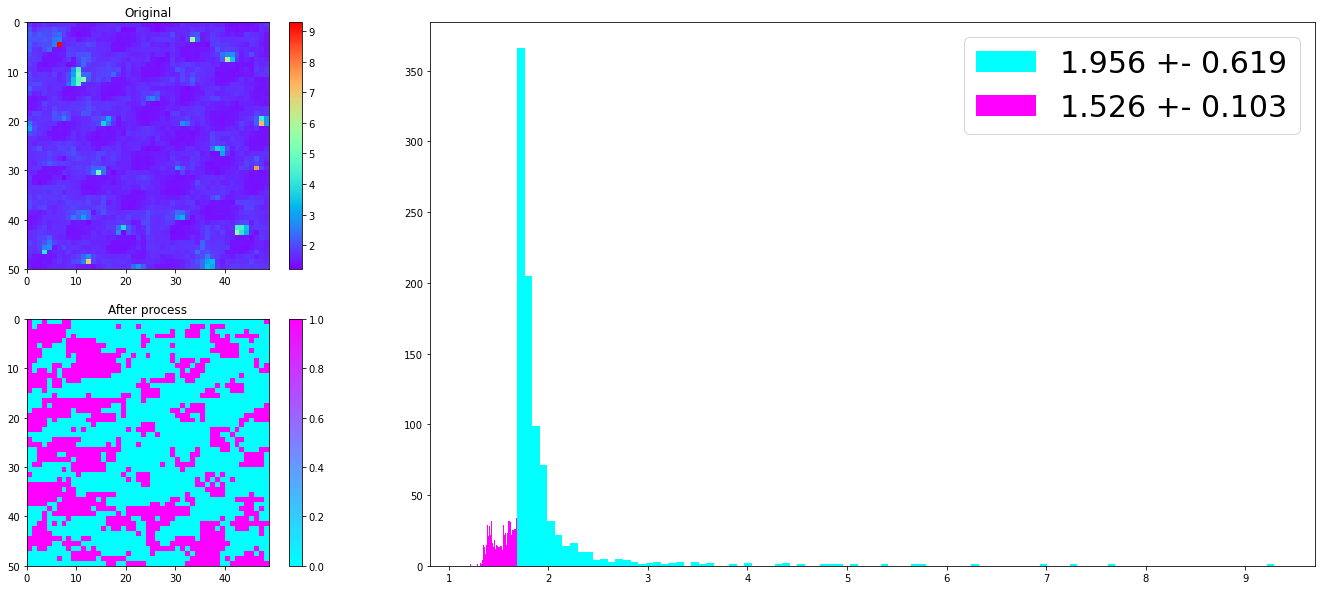

../data/221115_review/B_221109_380nm_negative/22n09004.abf_EMF_subs-pqty=25.csv
1563


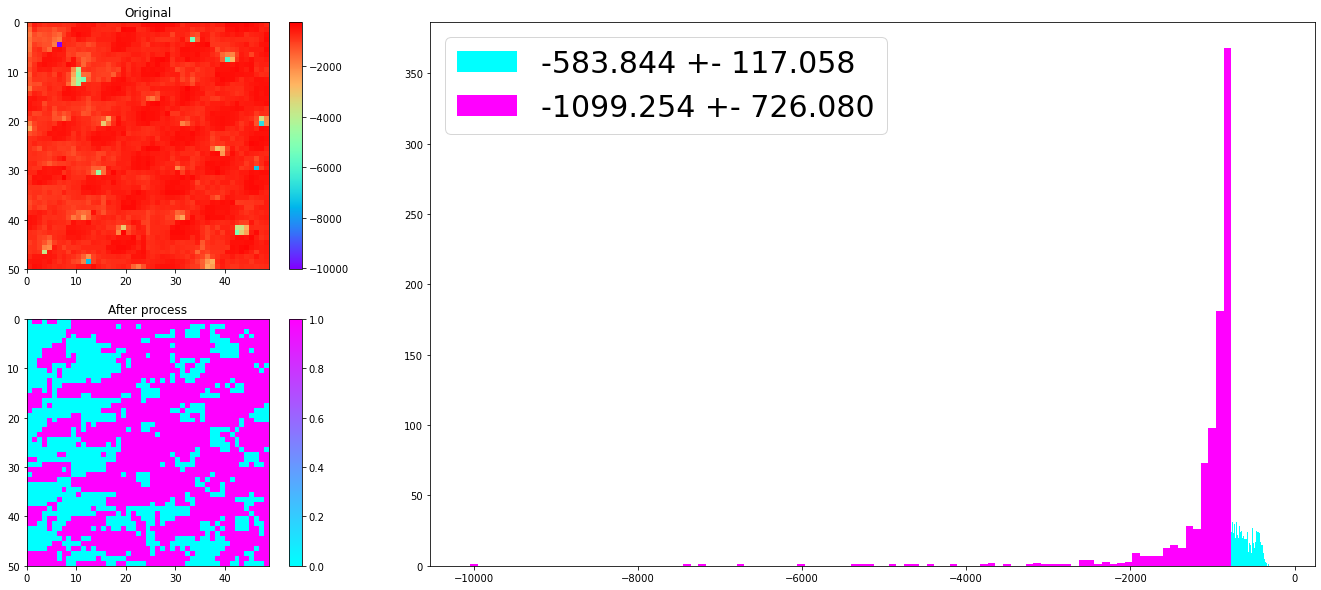

../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_div-pqty=25.csv
1617


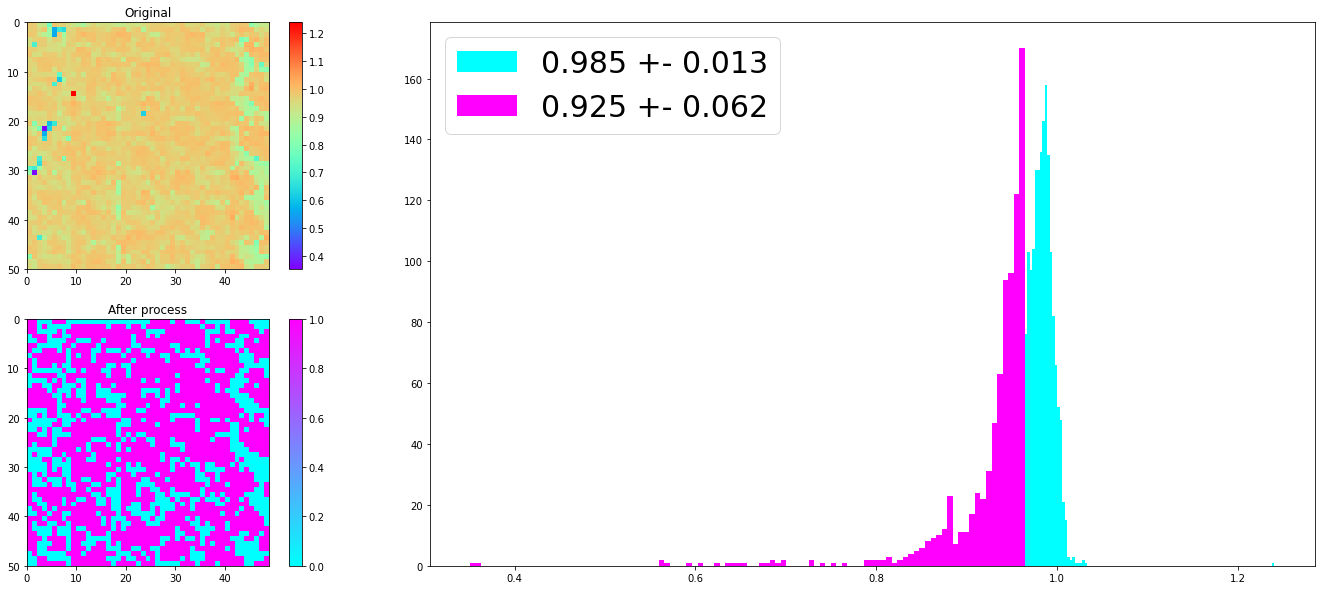

../data/221115_review/B_221109_380nm_positive/22n09005.abf_current_subs-pqty=25.csv
1611


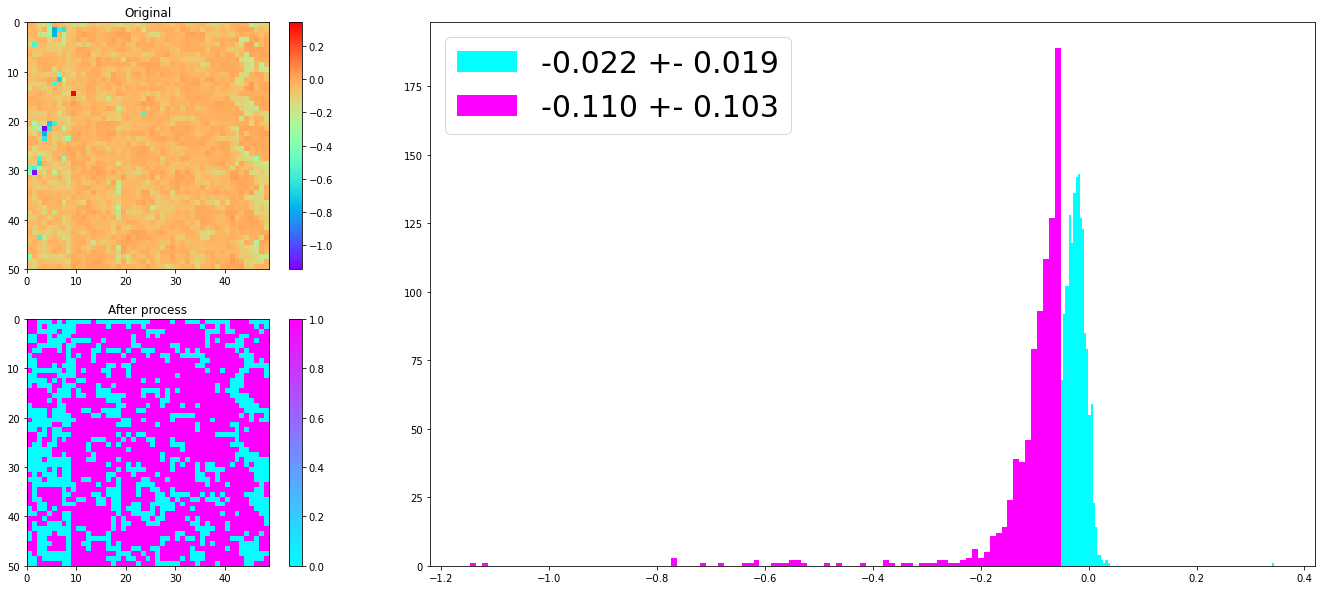

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_div-pqty=25.csv
802


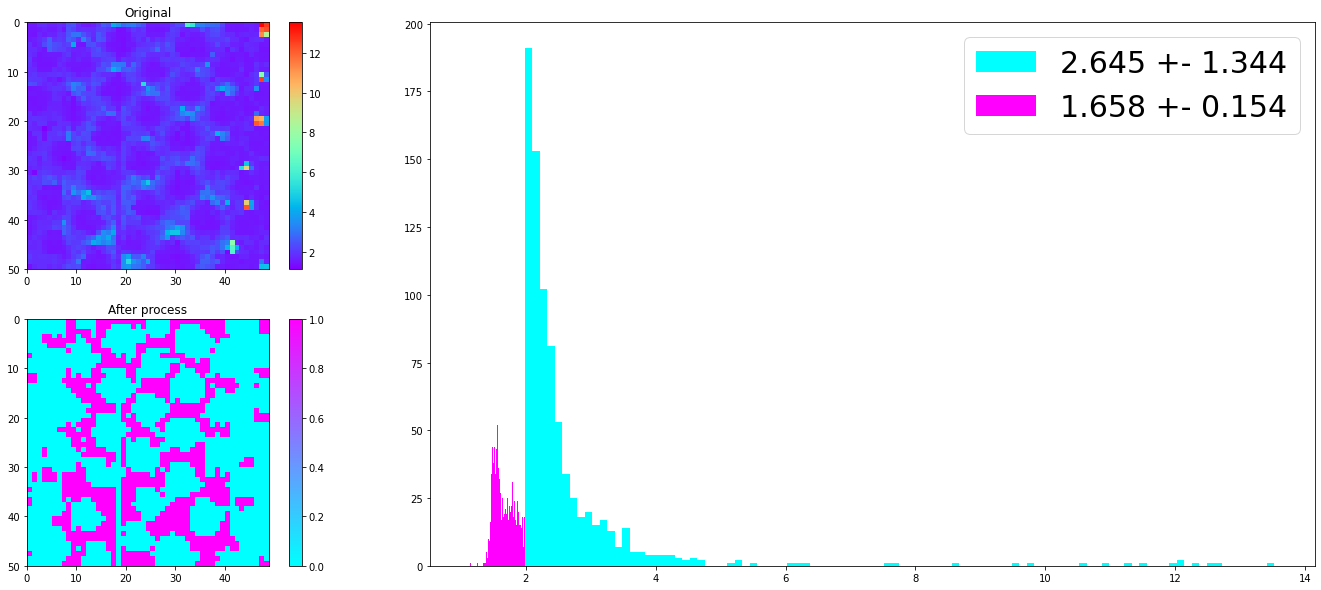

../data/221115_review/B_221109_380nm_positive/22n09005.abf_EMF_subs-pqty=25.csv
827


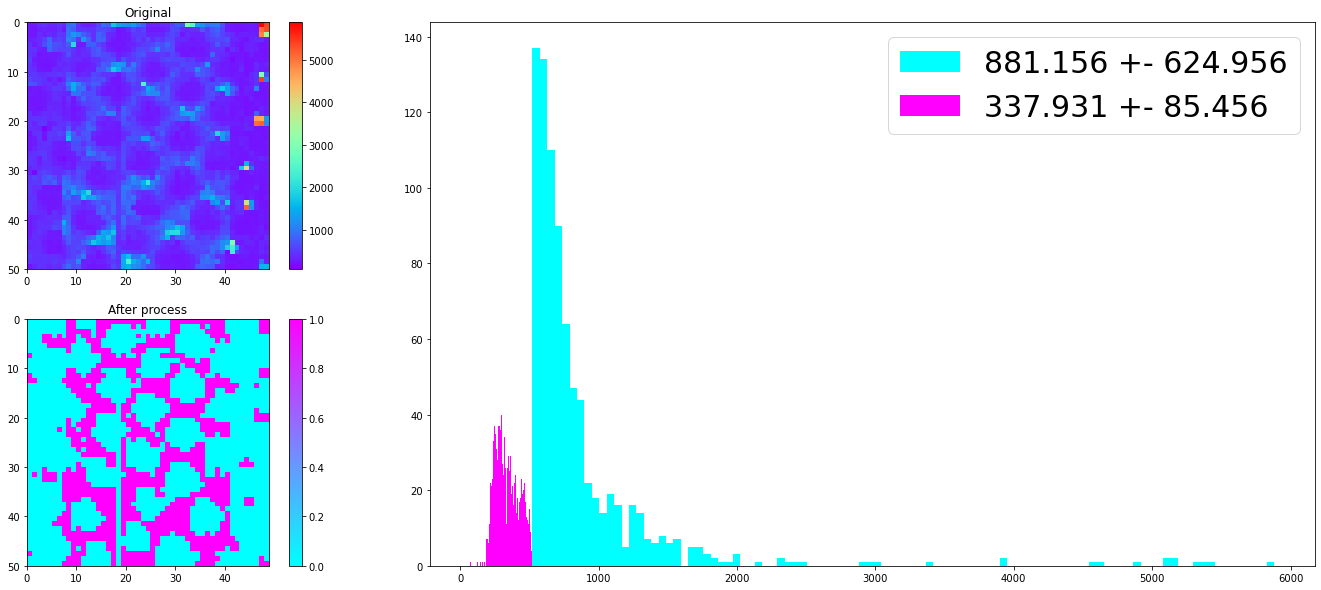

../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_div-pqty=25.csv
1310


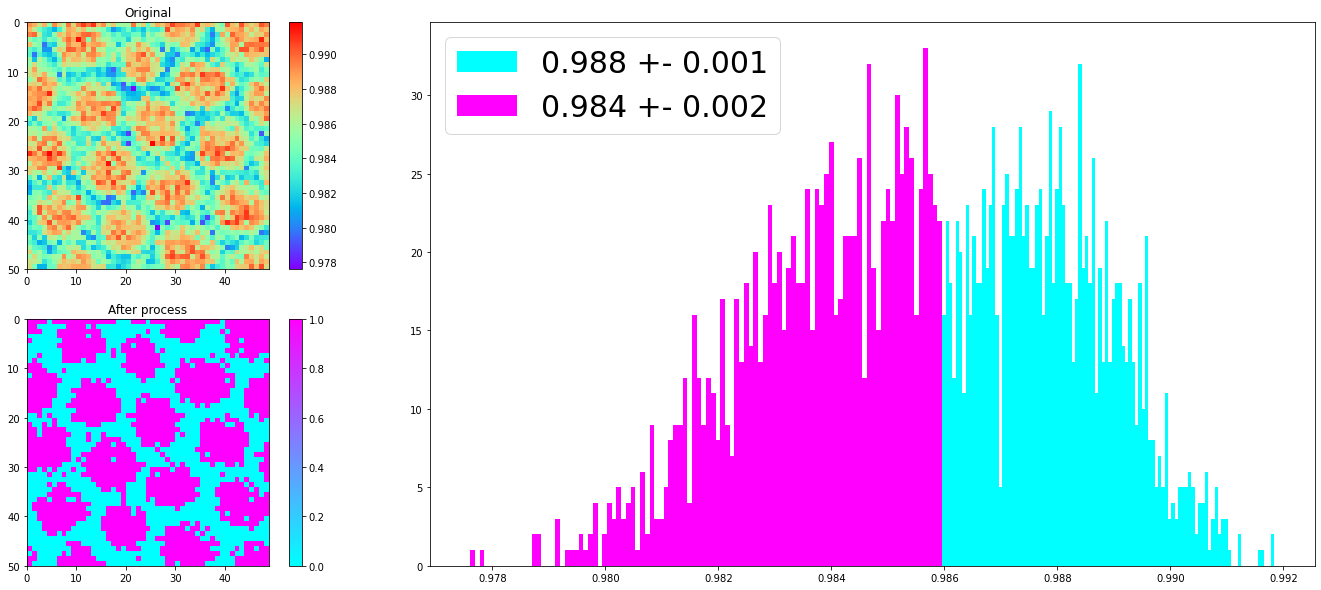

../data/221115_review/C_221015_480nm_negative/22o15010.abf_current_subs-pqty=25.csv
1141


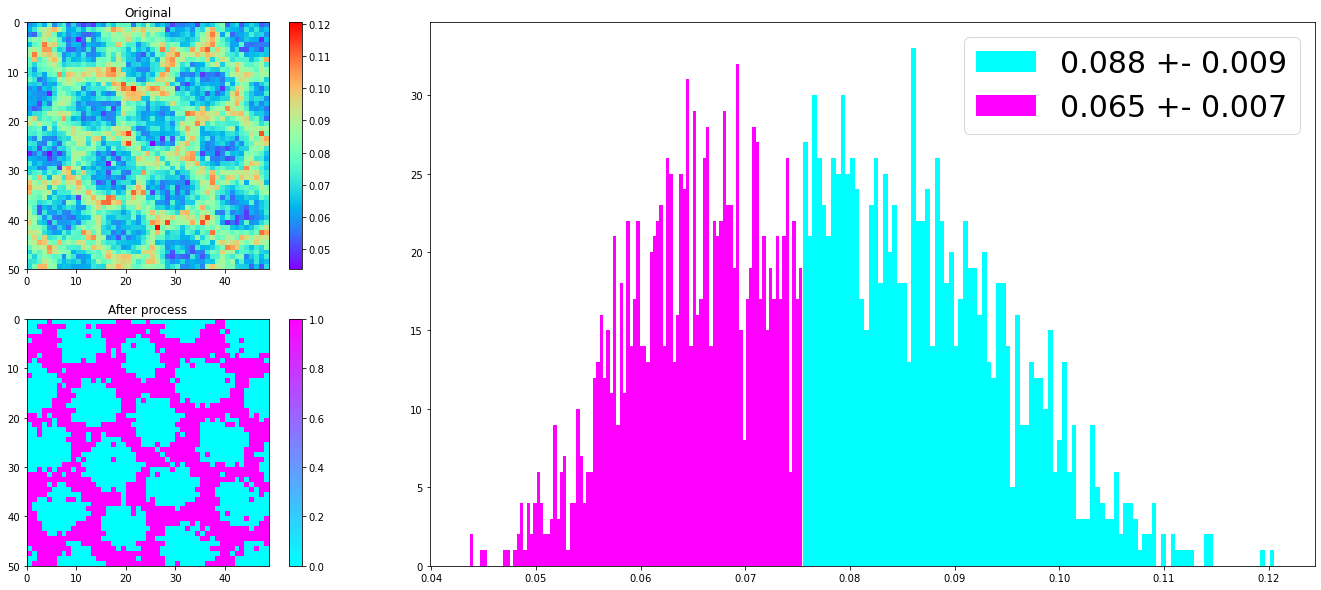

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_div-pqty=25.csv
1145


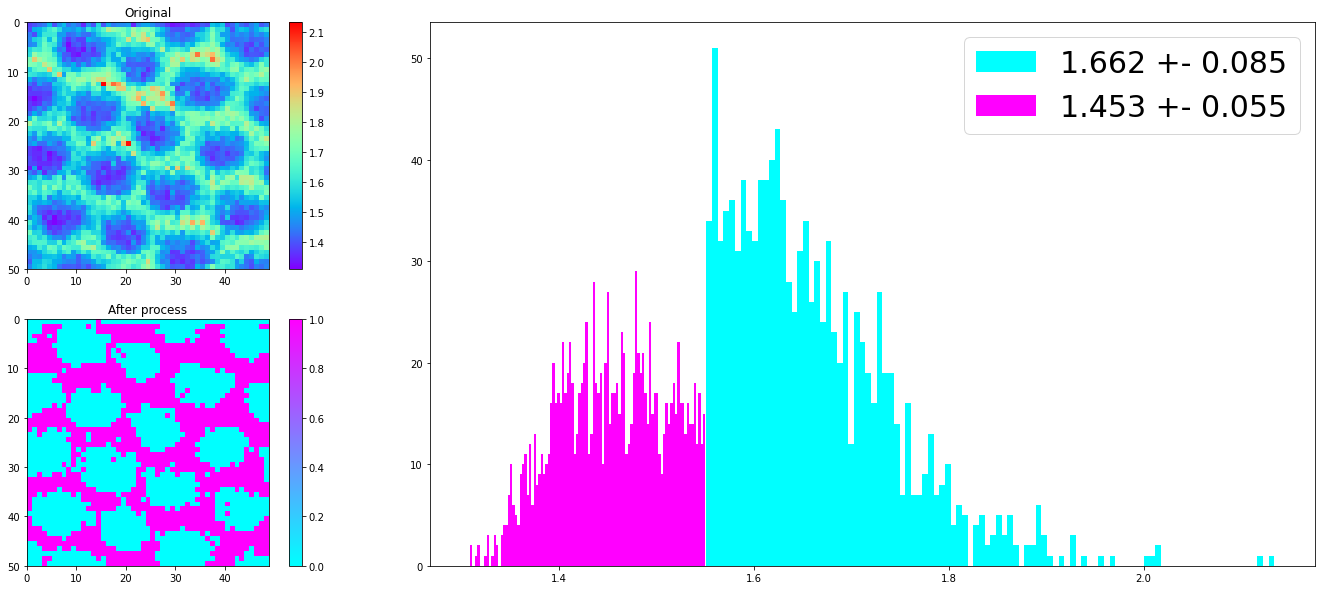

../data/221115_review/C_221015_480nm_negative/22o15010.abf_EMF_subs-pqty=25.csv
1308


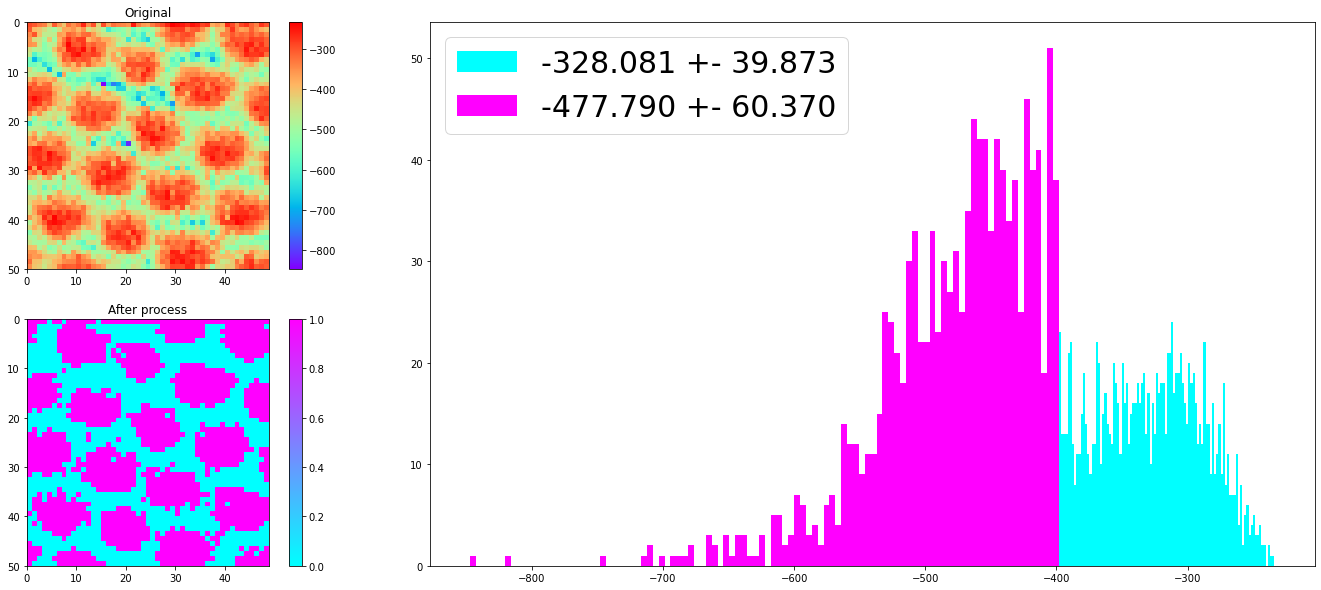

../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_div-pqty=25.csv
1081


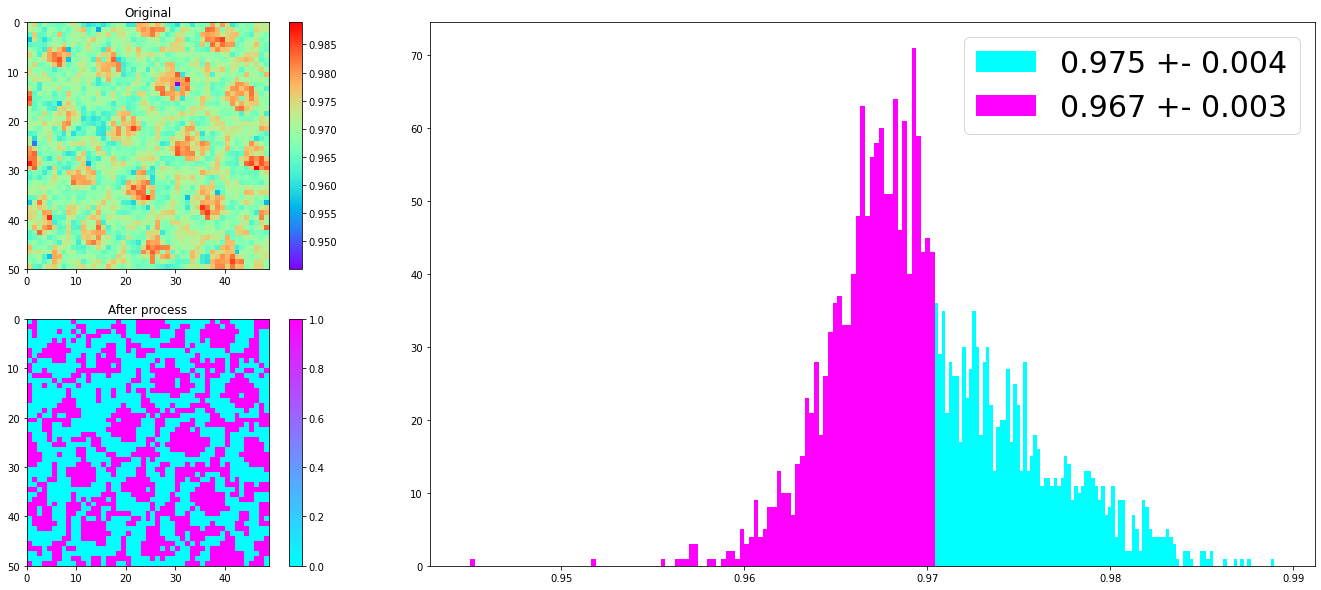

../data/221115_review/C_221015_480nm_positive/22o15009.abf_current_subs-pqty=25.csv
1081


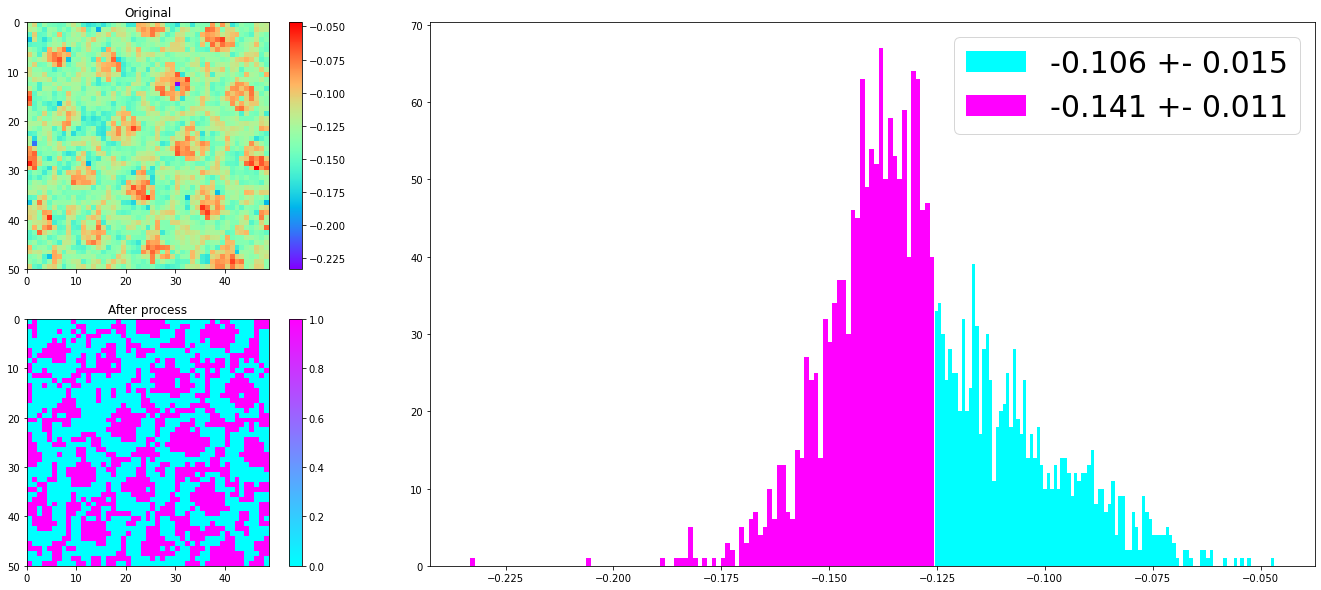

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_div-pqty=25.csv
1088


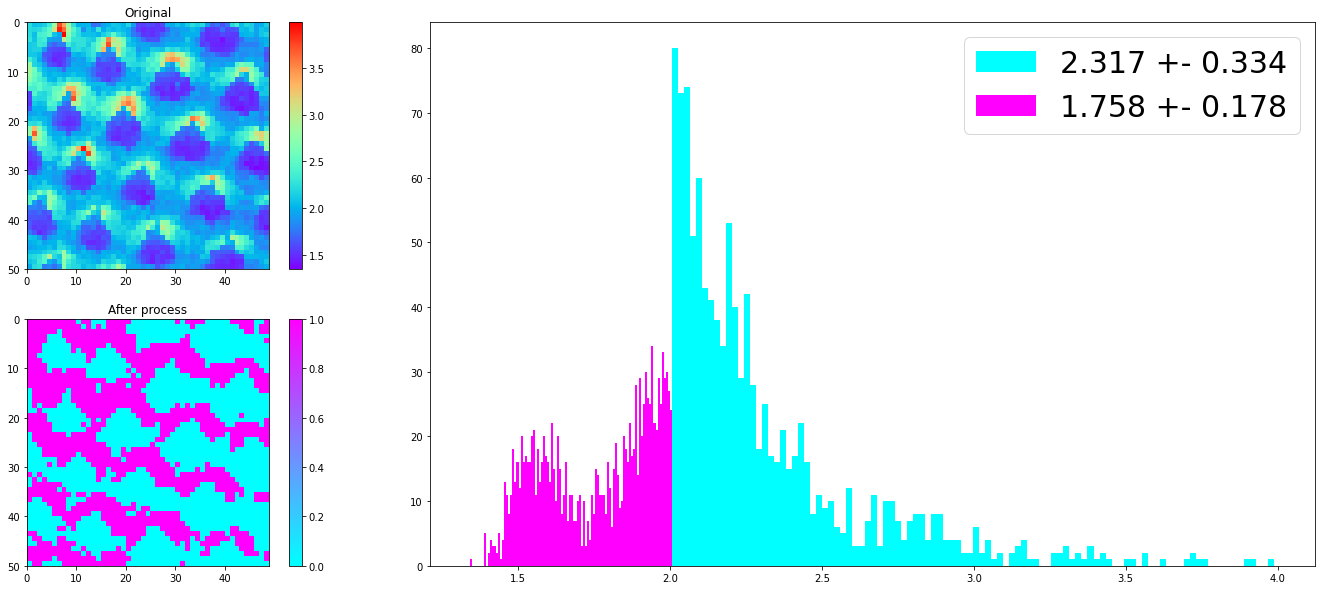

../data/221115_review/C_221015_480nm_positive/22o15009.abf_EMF_subs-pqty=25.csv
1080


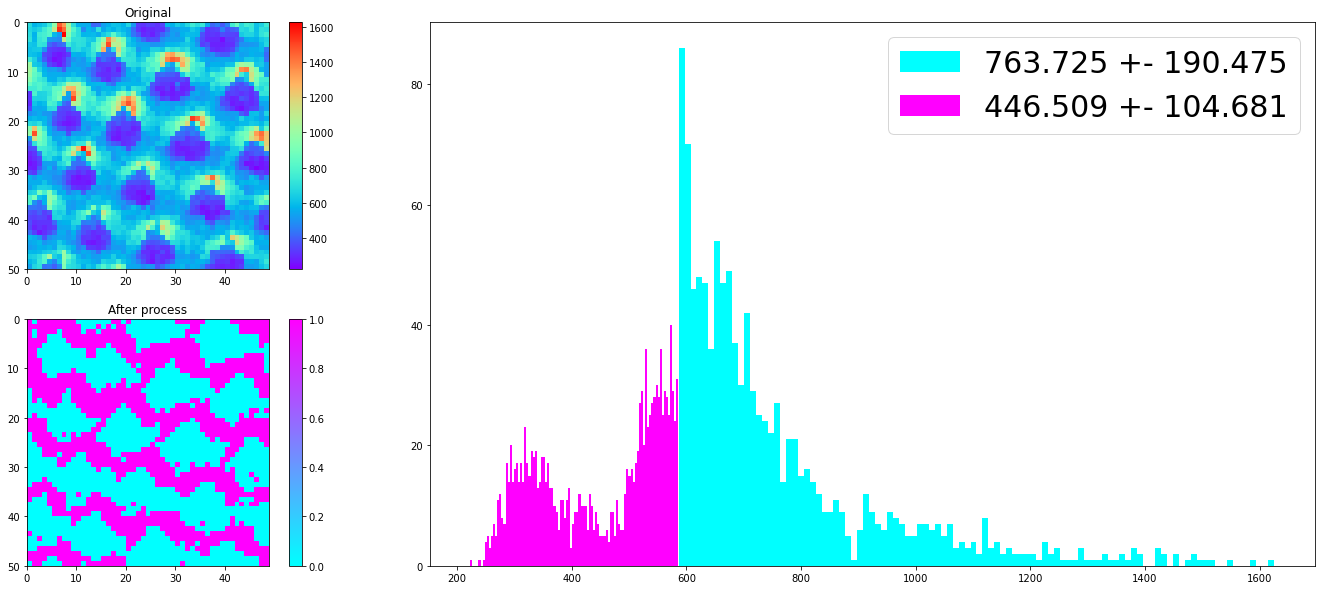

../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_div-pqty=25.csv
1270


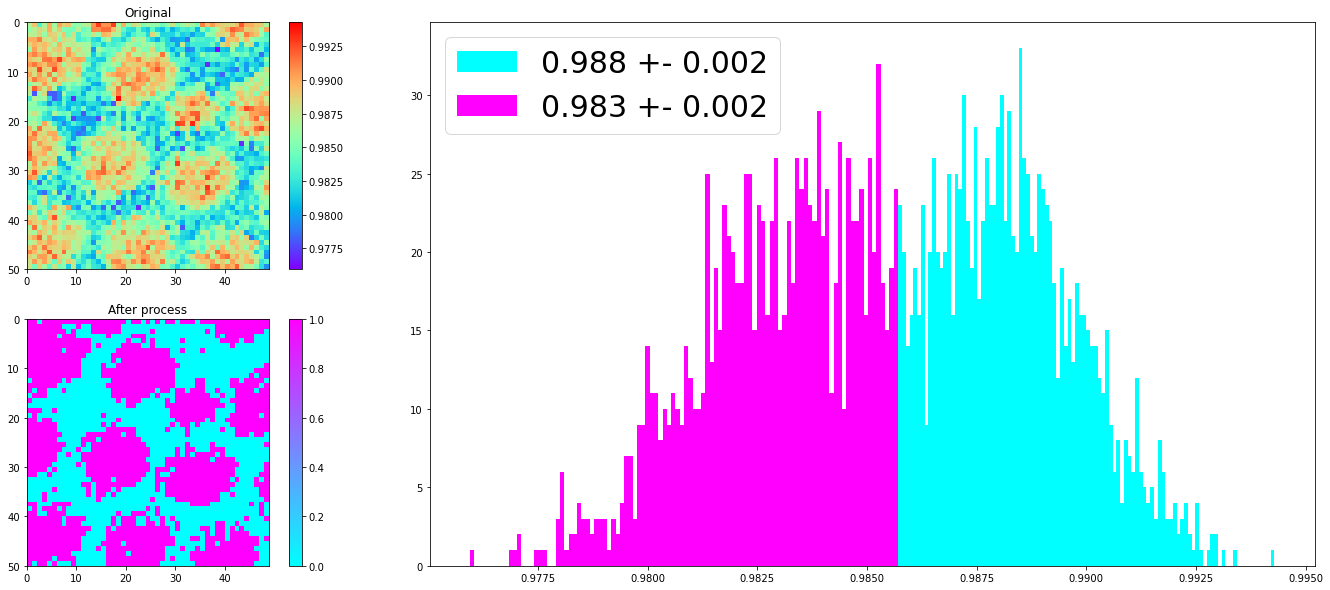

../data/221115_review/D_221011_750nm_negative/22o15013.abf_current_subs-pqty=25.csv
1181


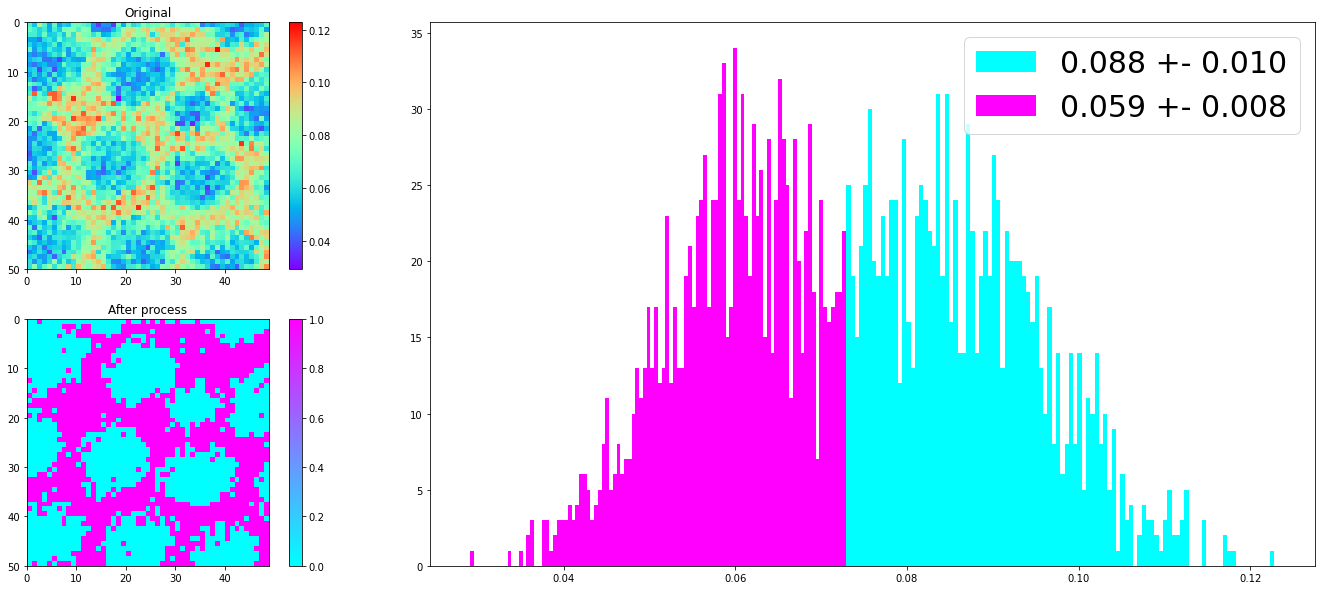

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_div-pqty=25.csv
1092


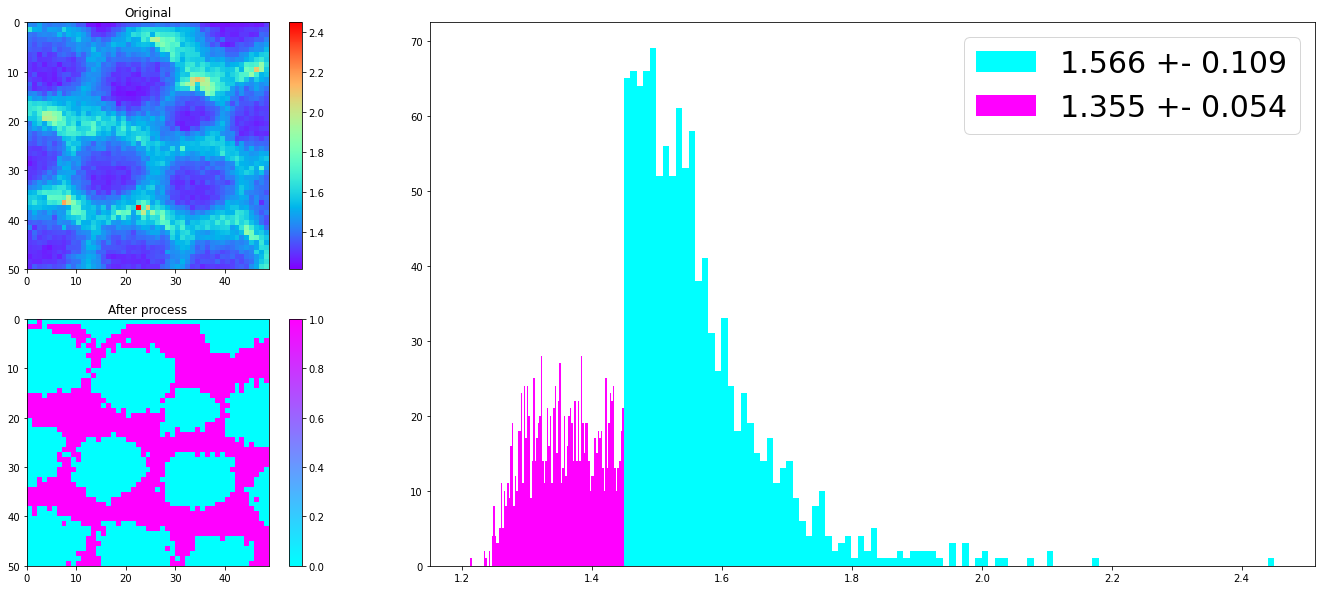

../data/221115_review/D_221011_750nm_negative/22o15013.abf_EMF_subs-pqty=25.csv
1360


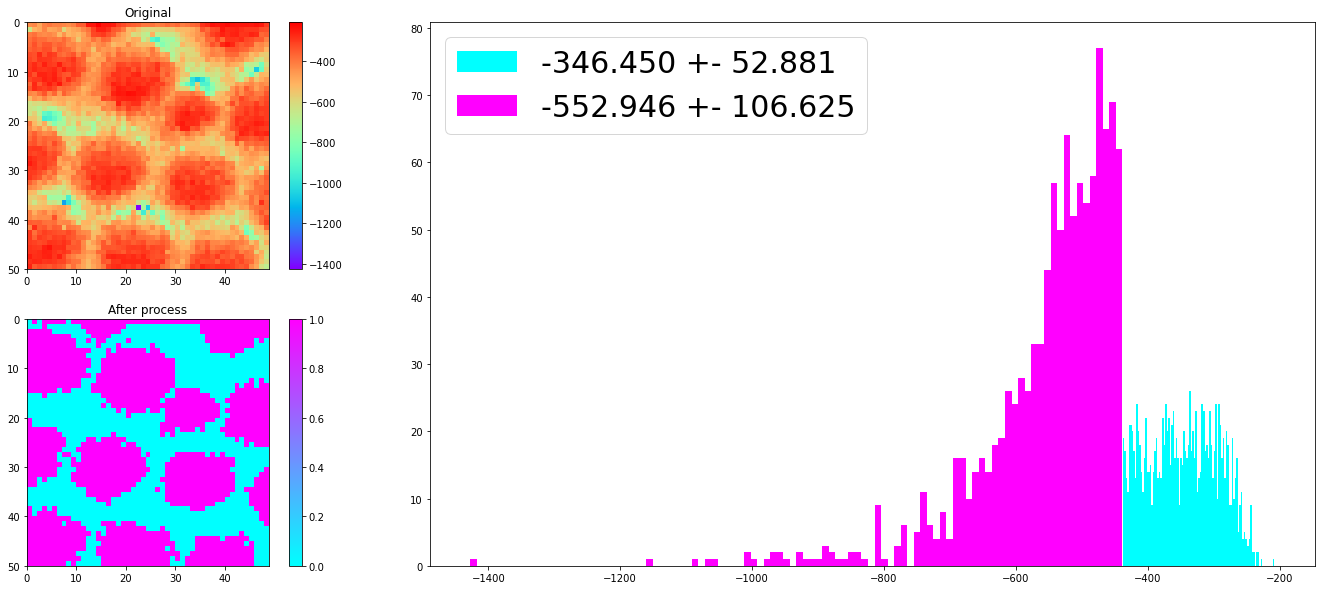

../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_div-pqty=25.csv
1185


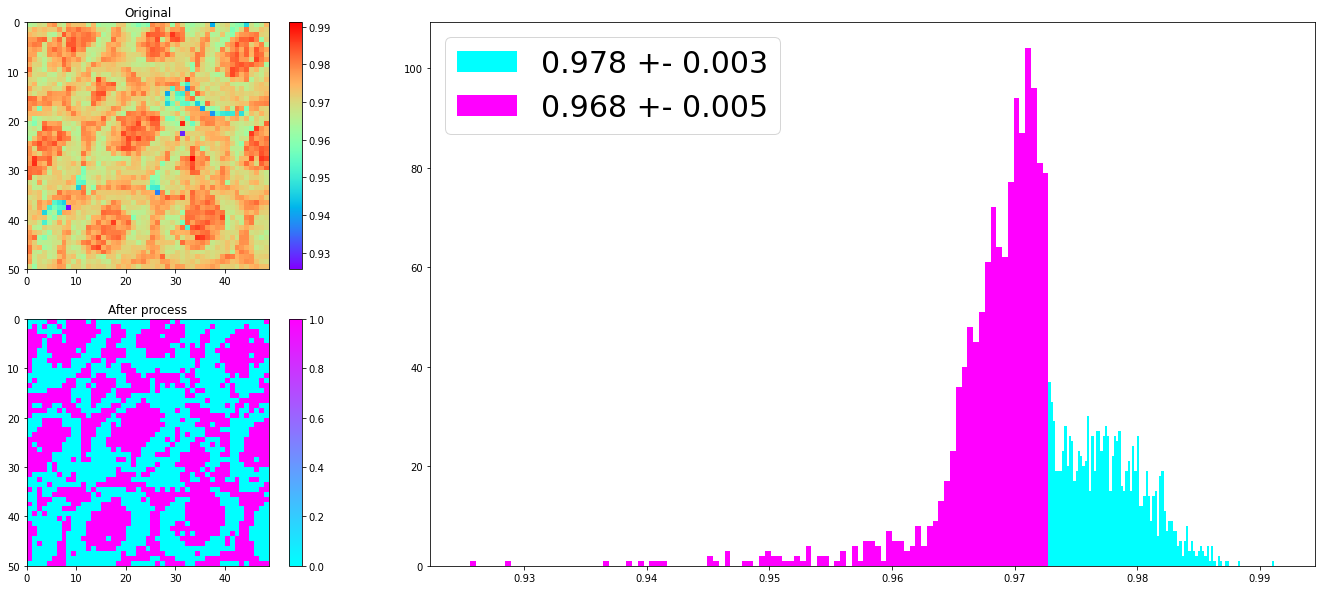

../data/221115_review/D_221011_750nm_postive/22o15012.abf_current_subs-pqty=25.csv
1183


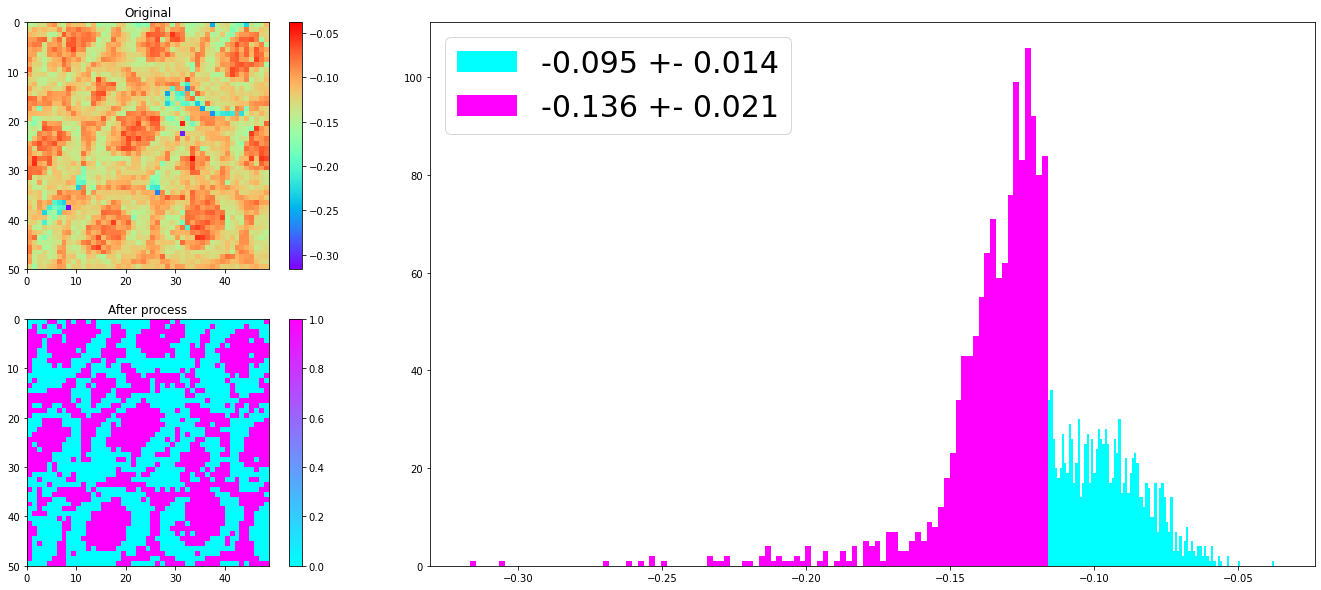

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_div-pqty=25.csv
841


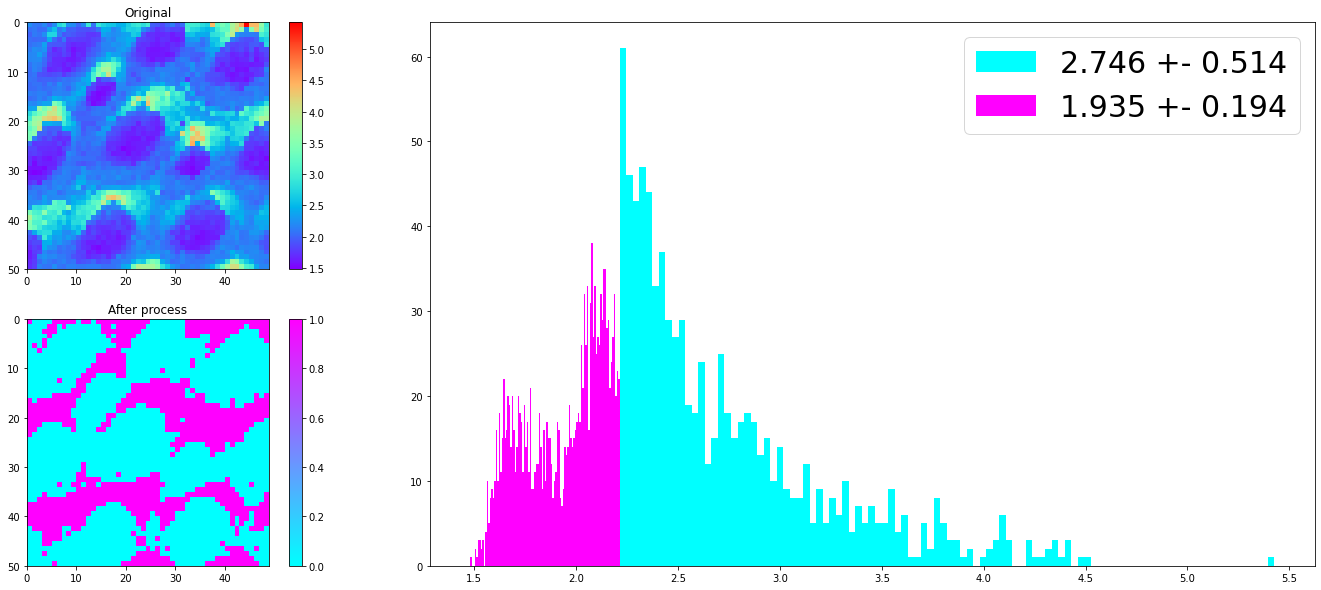

../data/221115_review/D_221011_750nm_postive/22o15012.abf_EMF_subs-pqty=25.csv
855


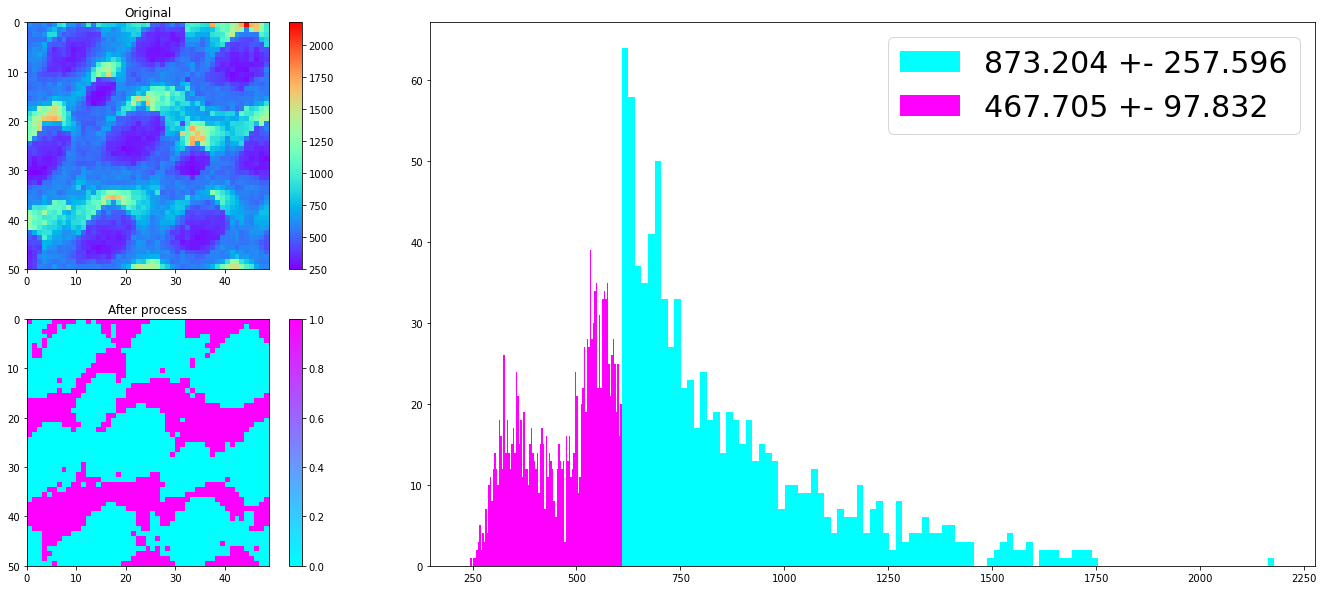

In [79]:
for p in files:
    process(p)

In [39]:
A.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])